In [1]:
include("astrobee_se3_script.jl")
using Plots
using JLD2, FileIO
using HDF5
using Keras
using Polynomials
using Statistics
using StatsPlots
using StatsBase

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /home/somrita/.julia/packages/CUDAdrv/3EzC1/src/CUDAdrv.jl:69


# Helper functions

## Main GuSTO function

In [2]:
function solve_gusto(model, N, MAX_ITERATIONS_NB, verbose = true, Xp = [], Up = [])
    
    if (Xp == [] && Up == [])
        Xp,Up = initialize_trajectory(model, N)
    elseif Up == []
        println("GuSTO X has been warm-started.")
        Up = zeros(model.u_dim, N-1)
    else
        if verbose
            println("GuSTO has been warm-started.")
        end
    end
    X, U  = copy(Xp)  , copy(Up) 

    SCPproblem = GuSTOProblem(model, N, Xp, Up)

    x_dim, u_dim = model.x_dim, model.u_dim

    Delta0, omega0, omegamax, 
        epsilon, rho0, rho1, 
        beta_succ, beta_fail, gamma_fail, 
        convergence_threshold = get_initial_gusto_parameters(model)

    Delta = Delta0
    omega = omega0

    X_all, U_all = [], []
    push!(X_all, copy(X))
    push!(U_all, copy(U))

    B_success = false
    it = 0

    while it<MAX_ITERATIONS_NB && 
            !(it!=0 && it!=1 && it!=2 && it!=3 && B_success && 
                convergence_metric(model,X,U,Xp,Up)<convergence_threshold) &&
            omega<omegamax
        if verbose
            println("-----------")
            println("Iteration $it")
            println("metric=$(convergence_metric(model,X,U,Xp,Up))")
            println("-----------")
        end

        Xp = copy(X)
        Up = copy(U)

        model.f, model.A, model.B = compute_dynamics(model, Xp, Up)

        reset_problem(SCPproblem, model)
        set_parameters(SCPproblem, model, Xp, Up, omega, Delta)
        define_cost(SCPproblem, model)
        define_constraints(SCPproblem, model)

        JuMP.optimize!(SCPproblem.solver_model)    

        # get solution
        X_sol = JuMP.value.(SCPproblem.X)
        U_sol = JuMP.value.(SCPproblem.U)

        # -----------
        # GuSTO Logic
        if it > 3
            if is_in_trust_region(model, X_sol, U_sol, Xp, Up, Delta)
                rho = accuracy_ratio(SCPproblem, model, X_sol, U_sol, Xp, Up)

                if rho > rho1
                    if verbose
                        println("Reject solution.")
                    end
                    Delta = beta_fail * Delta
                    omega     = omega
                    B_success = false

                else
                    if verbose
                        println("Accept solution.")
                    end
                    X = copy(X_sol)
                    U = copy(U_sol)
                    B_success = true
                    if rho < rho0
                        Delta = min(beta_succ*Delta, Delta0)
                    else
                        Delta = Delta
                    end
                    if satisfies_state_inequality_constraints(SCPproblem, model, X_sol, U_sol, Xp, Up, Delta)
                        omega = omega0
                    else
                        if verbose
                            println("Solution does not satisfy state constraints, increasing omega.")
                        end
                        omega = gamma_fail * omega
                        B_success = false
                    end
                end
            else
                if verbose
                    println("Reject solution (Outside trust region)")
                end
                Delta = Delta
                omega     = gamma_fail * omega
                B_success = false
            end

        else # always accept first solution
            X = copy(X_sol)
            U = copy(U_sol)
        end


        # -----------

        push!(X_all, copy(X))
        push!(U_all, copy(U))


        it += 1

        diff_with_prev = norm(copy(X) - copy(Xp), Inf)
        if verbose
            println("x(k) - x(k-1) = $diff_with_prev")
            println("Parameters:")
            println("omega=$omega")
            println("delta=$Delta")
        end
    end
    curr_conv_metric = convergence_metric(model,X,U,Xp,Up)
    if (B_success && 
                curr_conv_metric<convergence_threshold)
        if verbose
            println("Converged")
        end
        isConverged = true
    else
        if verbose
            println("Not converged. Metric =$curr_conv_metric")
        end
        isConverged = false
    end
    return isConverged, it, X_all, U_all
end

solve_gusto (generic function with 4 methods)

## Function to check if inside obstacle

In [3]:
function isInsideObstacle(x, model)
    isInside = false
    for obs in model.obstacles
        center = obs[1]
        radius = obs[2]
        if norm(x[1:3] - center) < radius
            isInside = true
            return isInside
        end
    end
    for obs in model.poly_obstacles
        center = obs.c
        dx = obs.dx
        dy = obs.dy
        dz = obs.dz
        x_max = center[1]+dx
        y_max = center[2]+dy
        z_max = center[3]+dz
        x_min = center[1]-dx
        y_min = center[2]-dy
        z_min = center[3]-dz
        if (x[1]<= x_max && x[1] >= x_min && 
            x[2]<= y_max && x[2] >= y_min &&
            x[3]<= z_max && x[3] >= z_min)
            isInside = true
            return isInside
        end
    end
    return isInside
end

isInsideObstacle (generic function with 1 method)

## Plotting functions

In [4]:
function plot_env_solution(model, X_all)
    N = length(X_all)

    idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter ==1 
            color = :darkblue
            plot!(fig, X[1,:], X[2,:], line=(5, :dash); c=color, lab = "Initial guess")
        elseif iter == length(X_all)
            color = :green
            plot!(fig, X[1,:], X[2,:], line=(5, :dash), c=color, lab = "Final solution")
        else
            color = :blue
            plot!(fig, X[1,:], X[2,:]; c=color, lab = "")
        end
        
    end

    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black,
                legend = false, fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[1],model.x_max[1]))
    ylims!((model.x_min[2],model.x_max[2]))
    plot!(leg = true)
    return fig
end

plot_env_solution (generic function with 1 method)

In [5]:
function plot_env_and_trajs(model, X_all, labls = :None)
    N = length(X_all)
    if labls == :None
        labls = fill("",(size(X_all,1),1))
    end
    
    idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    for iter = 1:length(X_all)
        X = X_all[iter]
        plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter])
    end

    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black,
                legend = false, fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(leg = true)
    return fig
end

plot_env_and_trajs (generic function with 2 methods)

In [6]:
function plot_three_comp_3D(model, X_all, labls = :None, time1="", iter1="", time2 ="", time3="", iter3="")
    N = length(X_all)
    labls = ["GuSTO solution ($iter1 iterations, $time1 seconds)", "NN prediction   ($time2 seconds)", "GuSTO warm-started ($iter3 iterations, $time3 seconds)"]
    idx = [1,2]
    local fig
#     fig = plot()
    fig = plot(framestyle = :box)
    


    for obs_i = 1
        (c1,c2,c3)  =  model.poly_obstacles[obs_i].c
        dx = model.poly_obstacles[obs_i].dx
        dy = model.poly_obstacles[obs_i].dy
        dz = model.poly_obstacles[obs_i].dz
        
        xmin = c1 - dx
        xmax = c1 + dx
        ymin = c2 - dy
        ymax = c2 + dy
        zmin = c3 - dz
        zmax = c3 + dz
        zmin = 0.2
        zmax = 0.8

        a = (zmax-zmin)/0.002
        b = zmax-0.003*a

        # top and bottom surfaces
        x = range(xmin, stop = xmax, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        f(x,y) = zmax
        g(x,y) = zmin
        plot!(x,y,f, seriestype = :surface, fillalpha = 1.0)
        plot!(x,y,g, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        

        dx = range(xmin + 0.001, stop = xmin + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        h(x,y) = a*(x-xmin) +b
        plot!(dx,y,h, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymax + 0.001, stop = ymax + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        m(x,y) = a*(y-ymax)+b
        plot!(x,dy,m, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        
        dx = range(xmax + 0.001, stop = xmax + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        k(x,y) = a*(x-xmax) +b
        plot!(dx,y,k, seriestype = :surface, fillalpha = 1.0)

        
    end
    
    for obs_i = 2
        (c1,c2,c3)  =  model.poly_obstacles[obs_i].c
        dx = model.poly_obstacles[obs_i].dx
        dy = model.poly_obstacles[obs_i].dy
        dz = model.poly_obstacles[obs_i].dz
        
        xmin = c1 - dx
        xmax = c1 + dx
        ymin = c2 - dy
        ymax = c2 + dy
        zmin = c3 - dz
        zmax = c3 + dz
        zmin = 0.2
        zmax = 0.8

        a = (zmax-zmin)/0.002
        b = zmax-0.003*a

        # top and bottom surfaces
        x = range(xmin, stop = xmax, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        f(x,y) = zmax
        g(x,y) = zmin
        plot!(x,y,f, seriestype = :surface, fillalpha = 1.0)
        plot!(x,y,g, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        

        dx = range(xmin + 0.001, stop = xmin + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        h(x,y) = a*(x-xmin) +b
        plot!(dx,y,h, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymax + 0.001, stop = ymax + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        m(x,y) = a*(y-ymax)+b
        plot!(x,dy,m, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        
        dx = range(xmax + 0.001, stop = xmax + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        k(x,y) = a*(x-xmax) +b
        plot!(dx,y,k, seriestype = :surface, fillalpha = 1.0)

        
    end
    
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 6, markershape = :octagon,  markerstrokealpha = 0.5, lab = labls[iter], color = iter )
        elseif iter ==2 
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 4, lab = labls[iter], color = iter )
        else
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 4, markeralpha=0.5,  markerstrokealpha = 0.5, lab = labls[iter], color = iter )
        end       
    end
    
    st_pt = X_all[1][:,1]
    scatter!([st_pt[1]], [st_pt[2]],[st_pt[3]], shape = :circle, markersize = 6, color = :white, lab = "Start point")
    end_pt = X_all[1][:,end]
    scatter!([end_pt[1]], [end_pt[2]],[end_pt[3]], shape = :star, markersize = 8, color = :white, lab = "Goal point")

    xlims!((model.x_min[1],model.x_max[1]))
    ylims!((model.x_min[2],model.x_max[2]))
    plot!(zlim = (model.x_min[3]+0.3,model.x_max[3]-0.2), zaxis = "Z")
    plot!(leg =  :best, legfontsize = 10)
    xlabel!("X")
    ylabel!("Y")
    plot!(camera=(120,30), colorbar = :false)
    plot!(size=(700,700,700))
    return fig
end

plot_three_comp_3D (generic function with 7 methods)

In [7]:
function plot_three_comp(model, X_all, labls = :None, time1="", iter1="", time2 ="", time3="", iter3="")
    N = length(X_all)
    labls = ["GuSTO solution ($iter1 iterations, $time1 seconds)", "NN prediction   ($time2 seconds)", "GuSTO warm-started ($iter3 iterations, $time3 seconds)"]
    idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    
    
    
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 1)
        elseif iter == 2
            r = plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 2)
#             @show r.color
        else
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(6, :dashdot), linealpha = 0.7, lab = labls[iter], color = 3)
        end        
    end
    
    st_pt = X_all[1][idx[1]:idx[2],1]
    scatter!([st_pt[1]], [st_pt[2]], shape = :circle, markersize = 6, color = :black, lab = "")
    end_pt = X_all[1][idx[1]:idx[2],end]
    scatter!([end_pt[1]], [end_pt[2]], shape = :star, markersize = 8, color = :black, lab = "")
    annotate!([(st_pt[1]-0.5, st_pt[2]+0.4, text("Start", 14, :black, :left)), 
            (end_pt[1]+0.3, end_pt[2]-0.4, text("Goal", 14, :black, :right))])


    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black, linealpha = 0.7,
                fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(leg =  :bottomright)
    return fig
end

plot_three_comp (generic function with 7 methods)

## Reading and writing to files

In [8]:
function getXYValid(filename)
    f = h5open(filename,"r")
    X_valid_norm = read(f["X_valid_norm"])
    Y_valid_norm = read(f["Y_valid_norm"])
    close(f)
    return (X_valid_norm, Y_valid_norm) 
end


getXYValid (generic function with 1 method)

In [9]:
function getDataParamsFromHDF5Combo(filename)
    f = h5open(filename,"r")
    xMin = read(f["xMin"])
    yMin = read(f["yMin"])
    xRange = read(f["xRange"])
    yRange = read(f["yRange"])
    close(f)
    return (xMin, yMin, xRange, yRange) 
end
    

getDataParamsFromHDF5Combo (generic function with 1 method)

In [10]:
function getDataParamsFromHDF5(filename)
    f = h5open(filename,"r")
    xMin_train = read(f["xMin_train"])
    yMin_train = read(f["yMin_train"])
    xRange_train = read(f["xRange_train"])
    yRange_train = read(f["yRange_train"])
    xMin_test = read(f["xMin_test"])
    yMin_test = read(f["yMin_test"])
    xRange_test = read(f["xRange_test"])
    yRange_test = read(f["yRange_test"])
    xMin_valid = read(f["xMin_valid"])
    yMin_valid = read(f["yMin_valid"])
    xRange_valid = read(f["xRange_valid"])
    yRange_valid = read(f["yRange_valid"])
    close(f)
    return (xMin_train, yMin_train, xRange_train, yRange_train, 
    xMin_test, yMin_test, xRange_test, yRange_test, 
    xMin_valid, yMin_valid, xRange_valid, yRange_valid) 
end
    

getDataParamsFromHDF5 (generic function with 1 method)

## NN helper functions

In [11]:
function recoverCoeffsfromNNOutput(NN_output, yMin, yRange)
    output_coeffs = (NN_output.*yRange)+yMin    
    return output_coeffs
end

recoverCoeffsfromNNOutput (generic function with 1 method)

In [12]:
function recoverXUfromCoeffsSingleDim(coeffs, dim)
    N = 50
    tf_guess = 110.
    t_array = range(0,stop=tf_guess,length=N)
    t_minus_one_array = t_array[1:end-1]
    num_coeffs = 5
    x_dim = 13
    u_dim = 6
    
    if dim<=x_dim
        cf_this = coeffs
        this_poly = polyval(Poly(cf_this), t_array)
        traj = this_poly
    else
        cf_this = coeffs
        this_poly = polyval(Poly(cf_this), t_minus_one_array)
        traj = this_poly
    end
    
    return traj
end

recoverXUfromCoeffsSingleDim (generic function with 1 method)

In [13]:
function recoverXUfromCoeffs(coeffs)
    N = 50
    tf_guess = 110.
    t_array = range(0,stop=tf_guess,length=N)
    t_minus_one_array = t_array[1:end-1]
    num_coeffs = 5
    x_dim = 13
    u_dim = 6
    
    X_soln = zeros(x_dim, N)
    U_soln = zeros(u_dim, N-1)
    
    for dim = 1:x_dim
        cf_this = coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
        this_poly = polyval(Poly(cf_this), t_array)
        X_soln[dim, :] = this_poly
    end
    
    for dim = 1:u_dim
        cf_this = coeffs[(x_dim*num_coeffs + (dim-1)*num_coeffs + 1): (x_dim*num_coeffs + dim*num_coeffs)]
        this_poly = polyval(Poly(cf_this), t_minus_one_array)
        U_soln[dim, :] = this_poly
    end
    
    return X_soln, U_soln
end

recoverXUfromCoeffs (generic function with 1 method)

In [14]:
function recoverXUfromNNOutput(NN_output, yMin, yRange)
    outputCoeffs = recoverCoeffsfromNNOutput(NN_output, yMin, yRange)
    X_soln, U_soln = recoverXUfromCoeffs(outputCoeffs)
end

recoverXUfromNNOutput (generic function with 1 method)

In [15]:
function createNNInput(x_init, x_final, xMin, xRange)
    # x_init and x_goal need to be of size 13
    NN_input = hcat([x_init', x_final']...)'
    NN_input = (NN_input-xMin)./xRange
    return NN_input
end

createNNInput (generic function with 1 method)

In [16]:
function getNNStructureCombo(NNDualParams, NNDualJSON, NNDualWeights)
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(NNDualParams)
    NN = Keras.load(NNDualJSON, NNDualWeights)
    return (NN, xMin, yMin, xRange, yRange)  
end

getNNStructureCombo (generic function with 1 method)

In [17]:
function getNNStructure(NNDualParams, NNDualJSON, NNDualWeights)
    (xMin_train, yMin_train, xRange_train, yRange_train, 
    xMin_test, yMin_test, xRange_test, yRange_test, 
    xMin_valid, yMin_valid, xRange_valid, yRange_valid)  = getDataParamsFromHDF5(NNDualParams)
    NN = Keras.load(NNDualJSON, NNDualWeights)
    return (NN, xMin_train, yMin_train, xRange_train, yRange_train, 
    xMin_test, yMin_test, xRange_test, yRange_test, 
    xMin_valid, yMin_valid, xRange_valid, yRange_valid) 
end

getNNStructure (generic function with 1 method)

In [18]:
function getNNPredictionCombo(x_init, x_final, NNDualParams, NNDualJSON, NNDualWeights)
    # x_init and x_goal need to be of size 13
    (NN, xMin, yMin, xRange, yRange) = getNNStructureCombo(NNDualParams, NNDualJSON, NNDualWeights)
    NN_input = zeros(1,26)
    NN_input = createNNInput(x_init, x_final, xMin, xRange)
    NN_output = NN(NN_input)
    X_soln, U_soln = recoverXUfromNNOutput(NN_output, yMin, yRange)
    return (X_soln, U_soln)
end

getNNPredictionCombo (generic function with 1 method)

In [19]:
function getNNPrediction(x_init, x_final, NNDualParams, NNDualJSON, NNDualWeights)
    # x_init and x_goal need to be of size 13
    (NN, xMin_train, yMin_train, xRange_train, yRange_train, 
    xMin_test, yMin_test, xRange_test, yRange_test, 
    xMin_valid, yMin_valid, xRange_valid, yRange_valid) = getNNStructure(NNDualParams, NNDualJSON, NNDualWeights)
    NN_input = zeros(1,26)
    NN_input = createNNInput(x_init, x_final, xMin_train, xRange_train)
    NN_output = NN(NN_input)
    X_soln, U_soln = recoverXUfromNNOutput(NN_output, yMin_train, yRange_train)
    return (X_soln, U_soln)
end

getNNPrediction (generic function with 1 method)

In [20]:
function getNNCoeffsCombo(x_init, x_final, NNDualParams, NNDualJSON, NNDualWeights)
    # x_init and x_goal need to be of size 13
    (NN, xMin, yMin, xRange, yRange) = getNNStructureCombo(NNDualParams, NNDualJSON, NNDualWeights)
    NN_input = zeros(1,26)
    NN_input = createNNInput(x_init, x_final, xMin, xRange)
    NN_output = NN(NN_input)
    outputCoeffs = recoverCoeffsfromNNOutput(NN_output, yMin, yRange)
    return (outputCoeffs)
end

getNNCoeffsCombo (generic function with 1 method)

## Get model on which data was collected and training done

In [21]:
function getModelWithTwoPolyObsOneAtCorner()
    N = 50
    MAX_ITERATIONS_NB = 100

    model = AstrobeeSE3()

    # Set up environment
    model.x_max[1:3] = [10.0; 10.0; 1.0]
    model.x_min[1:3] = [0.0; 0.0; 0.0]

    obstacles = []
    # obs = [[0.0,0.0,0.0], 6.0]
    # push!(obstacles, obs)
    model.obstacles = obstacles

    poly_obstacles = []
    obs = PolygonalObstacle([2.5,2.5,0], [5.0, 5.0, 2.0])
    push!(poly_obstacles, obs)
    obs = PolygonalObstacle([7.0,3.0,0], [1.0, 1.0, 2.0])
    push!(poly_obstacles, obs)
    model.poly_obstacles = poly_obstacles

    model.tf_guess = 110.
    model.convergence_threshold = 2.0
    
    return model
end

getModelWithTwoPolyObsOneAtCorner (generic function with 1 method)

In [22]:
function getModelWithCornerSpheres()
    N = 50
    MAX_ITERATIONS_NB = 100

    model = AstrobeeSE3()

    # Set up environment
    model.x_max[1:3] = [10.0; 10.0; 1.0]
    model.x_min[1:3] = [0.0; 0.0; 0.0]
    model.obstacles = []
    obstacles = []
    obs = [[0.0,0.0,0.0], 6.0]
    push!(obstacles, obs)
    obs = [[5.0,5.0,0.0], 1.3]
    push!(obstacles, obs)
    obs = [[3.0,5.0,0.0], 1.3]
    push!(obstacles, obs)
    obs = [[5.0,3.0,0.0], 1.3]
    push!(obstacles, obs)
    model.obstacles = obstacles

    model.tf_guess = 110.
    model.convergence_threshold = 0.7
    
    return model
end

getModelWithCornerSpheres (generic function with 1 method)

In [23]:
function findTrueGuSTOSolution(x_init, x_final, model = :None, verbose = false, Xinit = [], Uinit = [])
    N = 50
    MAX_ITERATIONS_NB = 200
    
    if model == :None
        println("No model supplied. Using spheres model.")
        model = getModelWithCornerSpheres()
    end
    
    isConverged = false
    X_all = []
    U_all = []
    numIter = 0

    problemNumber = 0

    train_input_collected = Array{Float64}(undef,0,26)
    train_output_collected = Array{Float64}(undef,0,944)

    if isInsideObstacle(x_init, model)
        println("x_init is inside an obstacle. Not valid.")
        return model, isConverged, X_all, U_all
    end
    if isInsideObstacle(x_final, model)
        println("x_final is inside an obstacle. Not valid.")
        return model, isConverged, X_all, U_all
    end
    if norm(x_final[1:3] - x_init[1:3])<1.0
        println("x_init and x_final too close. Not valid.")
        return model, isConverged, X_all, U_all
    end


    model.x_init = x_init
    model.x_final = x_final
    
    if verbose
        println("Starting to solve GuSTO")
    end
    try
        isConverged, numIter, X_all, U_all = solve_gusto(model, N, MAX_ITERATIONS_NB, verbose, Xinit, Uinit)
    catch e
        isConverged = false
        println("$e")
    end
    if verbose
        println("Converged: $isConverged")
    end

    return model, isConverged, numIter, X_all, U_all
end



findTrueGuSTOSolution (generic function with 5 methods)

# Compare GuSTO to NN for all full validation set

In [24]:
# Helper function
function getRelDiff(x_true, x_NN, x_threshold, error_threshold, verbose = false)
    relDiff = 0
    tentativeDiff = abs(x_true-x_NN)
    relDiff = 0
    den = 0
#     return relDiff
    
    tentativeError = abs(x_true-x_NN)/abs(x_NN)
    if x_true<=x_threshold && x_NN<=x_threshold
        if tentativeError < error_threshold
            if verbose
                println("Numbers are small but tent error is not large")
                @show tentativeError
                @show x_true
                @show x_NN
            end
            relDiff = tentativeDiff
            den = abs(x_true)
        else
            relDiff = 0
            den = 0
        end
    elseif x_true<=x_threshold
        if tentativeError < error_threshold
            relDiff = tentativeError
            den = abs(x_true)
        else
            if verbose
                println("x_true is small but x_NN is not")
                @show tentativeError
                @show x_true
                @show x_NN
            end
            relDiff = 0
            den = 0
        end
    elseif x_NN<=x_threshold
        if tentativeError < error_threshold
            relDiff = tentativeDiff
            den = abs(x_true)
        else
            if verbose
                println("x_NN is small but x_true is not")
                @show tentativeError
                @show x_true
                @show x_NN
            end
            relError = 0
            den = 0
#             relDiff = tentativeDiff
#             den = abs(x_true)
        end
    else
        if tentativeError >= error_threshold
            if verbose
                println("Error too high")
                @show tentativeError
                @show x_true
                @show x_NN
                @show x_threshold
            end
            relDiff = 0
            den = 0
#             relDiff = tentativeDiff
#             den = abs(x_true)
        else
            relDiff = tentativeDiff
            den = abs(x_true)
        end
    end
    return relDiff, den
end

getRelDiff (generic function with 2 methods)

# Use num/den average error

In [26]:
x_dim = 13
u_dim = 6

filename = "PolyComboCoeffsNormalized.jld2"
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
(X_valid_norm, Y_valid_norm)  =getXYValid(filename)
X_valid_norm = X_valid_norm'
Y_valid_norm = Y_valid_norm'
@show size(X_valid_norm)
@show size(Y_valid_norm)

# row = 10
allErrors = zeros(size(X_valid_norm,1), x_dim + u_dim)

error_threshold = 0.9
for row in 1:size(X_valid_norm,1)
# for row in 1:100
    @show row
    # For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
    x_v_norm = X_valid_norm[row,:] # size 26
    # First convert to X_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    x_v = x_v_norm.*xRange + xMin
    x_init = x_v[1:13]
    x_final = x_v[14:26]
#     @show x_init
#     @show x_final
    
    
    # NN prediction time and trajectory
    X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
#     @show size(X_soln_NN)
#     @show size(U_soln_NN)

    # For the Y_valid_norm, these are 95 coefficients
    y_v_norm = Y_valid_norm[row,:] # size 95
    # First convert to Y_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    y_v = y_v_norm.*yRange + yMin
    # Using these, we recover the poly X and poly U
    (X_soln_poly, U_soln_poly)= recoverXUfromCoeffs(y_v)
#     @show size(X_soln_poly)
#     @show size(U_soln_poly)


    totalerror = 0
    for j in 1:x_dim
        mean_poly = mean(X_soln_poly[j,:])
        mean_NN = mean(X_soln_NN[j,:])
#         @show mean_poly
#         @show mean_NN
#         std_poly = std(X_soln_poly[j,:])
#         std_NN = std(X_soln_NN[j,:])
#         x_threshold = max(mean_poly - 2*std_poly, mean_NN - 2*std_NN)
        x_threshold = max(mean_poly/20, mean_NN/20)
#         @show x_threshold
        these_errors = map((x_true,x_NN) -> getRelDiff(x_true,x_NN, x_threshold, error_threshold), X_soln_poly[j,:],X_soln_NN[j,:])
#         @show (these_errors[1])
        these_errors_num = [t[1] for t in these_errors]
        these_errors_den = [t[2] for t in these_errors]
#         these_errors_den = sum(abs.(X_soln_poly[j,:]))
#         @show size(these_errors)
        if sum(these_errors_den) ==0
            tentative_error = 0
        else
            tentative_error = sum(these_errors_num)/sum(these_errors_den)
        end
        @show tentative_error
        if tentative_error <= error_threshold
            allErrors[row, j] = tentative_error
        else
            allErrors[row, j] = 0
        end
    end

    for j in 1:u_dim
        mean_poly = mean(U_soln_poly[j,:])
        mean_NN = mean(U_soln_NN[j,:])
#         @show mean_poly
#         @show mean_NN
#         std_poly = std(U_soln_poly[j,:])
#         std_NN = std(U_soln_NN[j,:])
#         x_threshold = max(mean_poly - 2*std_poly, mean_NN - 2*std_NN)
        u_threshold = max(mean_poly/20, mean_NN/20)
#         @show u_threshold
        these_errors = map((u_true,u_NN) -> getRelDiff(u_true,u_NN, u_threshold, error_threshold), U_soln_poly[j,:],U_soln_NN[j,:])
#         @show (these_errors[1])
        these_errors_num = [t[1] for t in these_errors]
        these_errors_den = [t[2] for t in these_errors]
        if sum(these_errors_den) ==0
            tentative_error = 0
        else
            tentative_error = sum(these_errors_num)/sum(these_errors_den)
        end
        @show tentative_error
        if tentative_error <= error_threshold
            allErrors[row, x_dim + j] = tentative_error
        else
            allErrors[row, x_dim + j] = 0
        end
    end
end
@save "relAvgNumDenErrorPolyNN.jld2" allErrors



size(X_valid_norm) = (1130, 26)
size(Y_valid_norm) = (1130, 95)
row = 1
tentative_error = 1.3267224683260057
tentative_error = 0.051670153912447676
tentative_error = 0.21077905538981093
tentative_error = 3.1489615902863384
tentative_error = 0.6633373450996913
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.09026904217581921
tentative_error = 0.11923051427973166
tentative_error = 0.11540046276579201
tentative_error = 0
tentative_error = 0
tentative_error = 1.082947312572385
tentative_error = 0.20756009650702245
tentative_error = 0
tentative_error = 0.3743325405168653
tentative_error = 0
tentative_error = 0
row = 2
tentative_error = 0.010724552291979344
tentative_error = 0.01180567190459487
tentative_error = 0.024667028842338255
tentative_error = 0.029922901863093543
tentative_error = 0.035561133901757705
tentative_error = 4.798348175293494
tentative_error = 2.758460011424611
tentative_error = 0
tentative_error = 0.0021135928777405075
tentative_error = 0.0

tentative_error = 0.008956781097110147
tentative_error = 0.006109934598397704
tentative_error = 0.006153728804523871
tentative_error = 0.01631333722302699
tentative_error = 0.048269666153422056
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.004898749906710013
tentative_error = 0.0005489643604535804
tentative_error = 0.010507584886846133
tentative_error = 0
tentative_error = 2.543666030356198
tentative_error = 0.15998699749001163
tentative_error = 0.15618043066659693
tentative_error = 0
tentative_error = 0.01451904276791493
tentative_error = 2.6484117967292318
tentative_error = 0
row = 20
tentative_error = 0.03873418801473481
tentative_error = 0.0164354377889782
tentative_error = 0.05948589545668505
tentative_error = 0.09451409776875974
tentative_error = 0.17607433941991277
tentative_error = 193.97495100329218
tentative_error = 0
tentative_error = 0
tentative_error = 0.01135587462362124
tentative_error = 0.0019627952385429842
tentative_error = 0.02206411

tentative_error = 0.006569541234300175
tentative_error = 0.0034873201649788083
tentative_error = 0.02485322275700175
tentative_error = 0.03532872227345691
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.007944203613822778
tentative_error = 0.002295926785020529
tentative_error = 0.01235974354210459
tentative_error = 0
tentative_error = 0
tentative_error = 0.13489331907762
tentative_error = 4.504195339789647
tentative_error = 0
tentative_error = 0.0496166254917448
tentative_error = 0
tentative_error = 0
row = 45
tentative_error = 0.08242254268524785
tentative_error = 0.03158265033150063
tentative_error = 0.032625451444832435
tentative_error = 0.0676356010191927
tentative_error = 0.2345843762188509
tentative_error = 4.497043579683966
tentative_error = 0
tentative_error = 0
tentative_error = 0.03266653641334255
tentative_error = 0.00572223954042193
tentative_error = 0.057998150129407344
tentative_error = 0
tentative_error = 0
tentative_er

tentative_error = 0.7917454188284707
tentative_error = 0.47098860957994115
tentative_error = 0.648399738344946
tentative_error = 0.2633540349794836
tentative_error = 5.033644751982622
tentative_error = 0.10810351630987455
tentative_error = 0.44203709019987103
tentative_error = 1.1379644984974207
row = 69
tentative_error = 0.0032257477149080496
tentative_error = 0.0052124327166360295
tentative_error = 0.009574093115296292
tentative_error = 0.025944738364871607
tentative_error = 0.03576273379317121
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.004553683305700169
tentative_error = 0.001707923144428541
tentative_error = 0.00746646696588314
tentative_error = 0
tentative_error = 0
tentative_error = 0.015387028280033813
tentative_error = 0.07335247077392747
tentative_error = 0
tentative_error = 0.012379696193434202
tentative_error = 0
tentative_error = 0
row = 70
tentative_error = 0.0025786316584064336
tentative_error = 0.004182783161412266
tentative_error = 

tentative_error = 0.0086871144601676
tentative_error = 0.005175329577611441
tentative_error = 0.00466314812999051
tentative_error = 0.017062835793980758
tentative_error = 0.0521557226908925
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.004547665637143919
tentative_error = 0.0006350536285220122
tentative_error = 0.007298346933773888
tentative_error = 0
tentative_error = 0
tentative_error = 0.0674634663558599
tentative_error = 0.08627631589942007
tentative_error = 0
tentative_error = 0.017709667537842793
tentative_error = 0
tentative_error = 0
row = 88
tentative_error = 0.08439222945443056
tentative_error = 0.05219898729140222
tentative_error = 0.06022770901890412
tentative_error = 0.11163968915595515
tentative_error = 0.14088229790643816
tentative_error = 3.7426971564885907
tentative_error = 0
tentative_error = 0
tentative_error = 0.0317363407053307
tentative_error = 0.0010538542094454043
tentative_error = 0.05590540805000141
tentative_error = 0
tentati

tentative_error = 0.07807919721406838
tentative_error = 0
tentative_error = 0.025887181145359917
tentative_error = 8.67359470074388
tentative_error = 0
row = 111
tentative_error = 0.027658043906891437
tentative_error = 0.0064116758238345894
tentative_error = 0.034395223276514134
tentative_error = 0.1280701398389402
tentative_error = 0.0699803063856674
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.0019331418195052946
tentative_error = 0.0013880354809927614
tentative_error = 0.004678920569343243
tentative_error = 0
tentative_error = 0
tentative_error = 0.1394235691969397
tentative_error = 0.07936392757437817
tentative_error = 0
tentative_error = 0.02752778872629386
tentative_error = 0
tentative_error = 0
row = 112
tentative_error = 0.0037831104109416237
tentative_error = 0.014151662078956809
tentative_error = 0.026185099928420486
tentative_error = 0.37863708003246294
tentative_error = 0.050537861514451485
tentative_error = 0
tentative_error = 0
tentative

tentative_error = 0.12911365124498347
tentative_error = 0.04798281905236639
tentative_error = 0.1019384186194038
tentative_error = 0.38827828468112596
tentative_error = 0.186666095724484
tentative_error = 5.621138460302229
tentative_error = 0
tentative_error = 0
tentative_error = 0.025616785028608275
tentative_error = 0.006322321475095614
tentative_error = 0.07089317057210279
tentative_error = 0
tentative_error = 0
tentative_error = 0.5145002229674671
tentative_error = 0.37090879343730687
tentative_error = 0
tentative_error = 0.1076604979792999
tentative_error = 0
tentative_error = 0
row = 134
tentative_error = 0.09145568112399238
tentative_error = 0.031148926788313228
tentative_error = 0.07745518816028885
tentative_error = 0.46908524051685757
tentative_error = 0.7407210665660509
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.028359228717921924
tentative_error = 0.04336113609080691
tentative_error = 0.05619418166609127
tentative_error = 0
tentative_erro

tentative_error = 0.0374015406400276
tentative_error = 0.010738638806807085
tentative_error = 0.08772958972699343
tentative_error = 0.3367566605269657
tentative_error = 0.13505767545528147
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.02523103469677517
tentative_error = 0.0044728032781314
tentative_error = 0.045066217625801576
tentative_error = 0
tentative_error = 0
tentative_error = 0.18036263699467825
tentative_error = 0.056578057272290774
tentative_error = 0
tentative_error = 0.08497202826335594
tentative_error = 0
tentative_error = 0
row = 160
tentative_error = 0.03435025907775694
tentative_error = 0.030379983446559206
tentative_error = 0.04267873497311976
tentative_error = 0.3418441697433018
tentative_error = 0.196444433407343
tentative_error = 3.179642632305291
tentative_error = 3.4564447525045545
tentative_error = 0
tentative_error = 0.004711115747552798
tentative_error = 0.004665672406005067
tentative_error = 0.017805236638649663
tentative_erro

tentative_error = 6.655481457887093
tentative_error = 0
row = 177
tentative_error = 0.01756118099904637
tentative_error = 0.023905003228683688
tentative_error = 0.017030230496676388
tentative_error = 0.08645262472169975
tentative_error = 0.09286617715093262
tentative_error = 2.288685579736379
tentative_error = 0
tentative_error = 0
tentative_error = 0.020295528691288273
tentative_error = 0.004080813593695831
tentative_error = 0.027281324174970756
tentative_error = 0
tentative_error = 0
tentative_error = 0.2793925554449844
tentative_error = 0.12608475269292718
tentative_error = 4.088616819053851
tentative_error = 0.0417245937618119
tentative_error = 0.4445401824001254
tentative_error = 0
row = 178
tentative_error = 0.06418887184003967
tentative_error = 0.01836484408628263
tentative_error = 0.09505422092085175
tentative_error = 0.13616542749216448
tentative_error = 0.17889397528317116
tentative_error = 1.0073839048088107
tentative_error = 1.0138746735146125
tentative_error = 0
tentative_

tentative_error = 0.0221419451725311
tentative_error = 0.015611284339586142
tentative_error = 0.05374934689348942
tentative_error = 0.07317032928723967
tentative_error = 0.9283254016184803
tentative_error = 2.4877562209699753
tentative_error = 0
tentative_error = 0
tentative_error = 0.017047213753315988
tentative_error = 0.0025862955487595857
tentative_error = 0.03032307677279527
tentative_error = 0
tentative_error = 0
tentative_error = 0.17286569980499245
tentative_error = 0.271578672404104
tentative_error = 5.56898477933472
tentative_error = 0.05871102110840733
tentative_error = 0
tentative_error = 0
row = 204
tentative_error = 0.020885505765810317
tentative_error = 0.013798628513395337
tentative_error = 0.007330040305066962
tentative_error = 0.514522543455421
tentative_error = 0.0664768816371316
tentative_error = 0.31695195731656295
tentative_error = 0
tentative_error = 0
tentative_error = 0.0033744757746807944
tentative_error = 0.0008376281895957045
tentative_error = 0.006053135263

tentative_error = 0.05570585811712392
tentative_error = 0.04683717244781883
tentative_error = 0.1043714994544104
tentative_error = 0.40294809126614944
tentative_error = 0.13909221617808917
tentative_error = 6.841740200313272
tentative_error = 0
tentative_error = 0
tentative_error = 0.019408763448241346
tentative_error = 0.008323623257493983
tentative_error = 0.09634815807164299
tentative_error = 0
tentative_error = 0
tentative_error = 0.38939699497384844
tentative_error = 0.6044640565025583
tentative_error = 0
tentative_error = 0.16548631023143567
tentative_error = 0
tentative_error = 0
row = 230
tentative_error = 0.03591330193879223
tentative_error = 0.009764179169734741
tentative_error = 0.02225327899294602
tentative_error = 0.32521419853469663
tentative_error = 0.32504440948760993
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.002060504364488613
tentative_error = 0.0002452708705315712
tentative_error = 0.006154377174578426
tentative_error = 1.8954679

tentative_error = 0.01589459887376625
tentative_error = 0.017394698289567436
tentative_error = 0.012835713870387433
tentative_error = 0.09328611814948852
tentative_error = 0.12017812527981828
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.00818285004553629
tentative_error = 0.002522517023659624
tentative_error = 0.01621752812764971
tentative_error = 0
tentative_error = 4.528844761426278
tentative_error = 0.03796325119909344
tentative_error = 0.19054241560615193
tentative_error = 0
tentative_error = 0.049126838635299014
tentative_error = 0
tentative_error = 0
row = 253
tentative_error = 0.006347948691136692
tentative_error = 0.5692331101617438
tentative_error = 0.01430034516410295
tentative_error = 1.888509563653438
tentative_error = 0.2267300309278881
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.010603126035514127
tentative_error = 0.000952093377660354
tentative_error = 0.013246744553238377
tentative_error = 0
tentativ

tentative_error = 0.02951288000173082
tentative_error = 0.06619073281077198
tentative_error = 0.0881299713423257
tentative_error = 0.23881551739643508
tentative_error = 0.13840790233784542
tentative_error = 108.45195825155682
tentative_error = 0
tentative_error = 0
tentative_error = 0.013116410746589664
tentative_error = 0.003795518510739549
tentative_error = 0.03335100258528141
tentative_error = 0
tentative_error = 0
tentative_error = 0.19006413812285683
tentative_error = 0.2992536417578562
tentative_error = 3.3999944457888476
tentative_error = 0.05312944255373857
tentative_error = 0
tentative_error = 0
row = 270
tentative_error = 0.016229539497037367
tentative_error = 0.005899679697780365
tentative_error = 0.014006748302504495
tentative_error = 0
tentative_error = 0.06852841515362158
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.0015598691638373532
tentative_error = 0.00040235159873373795
tentative_error = 0.0041119348250541355
tentative_error = 5.27

tentative_error = 0.02419963497275195
tentative_error = 0.027453856178303013
tentative_error = 0.04823459594514195
tentative_error = 0.45206456632844705
tentative_error = 0.11016398854689824
tentative_error = 20957.583415191468
tentative_error = 0
tentative_error = 0
tentative_error = 0.013974016928036072
tentative_error = 0.0045355123825612164
tentative_error = 0.03207725432409173
tentative_error = 0
tentative_error = 0
tentative_error = 0.09336434302594007
tentative_error = 0.3048572863919564
tentative_error = 2.756235368971957
tentative_error = 0.04243659759699509
tentative_error = 0
tentative_error = 0
row = 292
tentative_error = 0.06193197815284686
tentative_error = 0.03172224874940882
tentative_error = 0.03436862705125692
tentative_error = 0.06538042274225418
tentative_error = 0.25986381111907475
tentative_error = 2.003097028243851
tentative_error = 0
tentative_error = 0
tentative_error = 0.014630566305261496
tentative_error = 0.0046256901971103315
tentative_error = 0.03526400690

tentative_error = 0.010827615709992914
tentative_error = 0.05968482897081427
tentative_error = 0.0591896360150027
tentative_error = 0.09319859667573713
tentative_error = 0.14577978220655813
tentative_error = 36.78740613470324
tentative_error = 0
tentative_error = 0
tentative_error = 0.014093412764576579
tentative_error = 0.018234275240866467
tentative_error = 0.036118172178134705
tentative_error = 0
tentative_error = 0
tentative_error = 0.10119638746074665
tentative_error = 1.8971592793415186
tentative_error = 1.0524375544971214
tentative_error = 0.0678709736317838
tentative_error = 0
tentative_error = 2.027944250785913
row = 316
tentative_error = 0.0017832243670716766
tentative_error = 0.01790201148291945
tentative_error = 0.02758887158005523
tentative_error = 0
tentative_error = 0.3027427905909219
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.008419795699472078
tentative_error = 0.0024351489497356806
tentative_error = 0.02097589113974899
tentative_er

tentative_error = 0.030383858369987016
tentative_error = 0.021489251336239926
tentative_error = 0.1043715409788817
tentative_error = 0.13805011187208144
tentative_error = 0.10495939685232586
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.039084906785036455
tentative_error = 0.019954116390875135
tentative_error = 0.05505275588919502
tentative_error = 0
tentative_error = 0
tentative_error = 0.09037501319412404
tentative_error = 0.32787618460898293
tentative_error = 0
tentative_error = 0.1530446088072009
tentative_error = 0
tentative_error = 2.3914749762093814
row = 342
tentative_error = 0.05416159637186149
tentative_error = 0.015428471692418375
tentative_error = 0.057782571492526934
tentative_error = 0.16245463199362925
tentative_error = 0.0975943693557104
tentative_error = 0
tentative_error = 0.5503022708065503
tentative_error = 0
tentative_error = 0.00033475405288656697
tentative_error = 0.0021902380061179457
tentative_error = 0.006113360149934026
tenta

tentative_error = 0.0044371558531325446
tentative_error = 0.009522951001537392
tentative_error = 0.044680200301336376
tentative_error = 0.1351507222159753
tentative_error = 0.05751678702031
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.0067580158818475915
tentative_error = 0.0011518700706446604
tentative_error = 0.002941064044704007
tentative_error = 0.0012045500206093079
tentative_error = 0
tentative_error = 10.002707738418382
tentative_error = 0.13829546208100685
tentative_error = 0
tentative_error = 0.03037031103728192
tentative_error = 0
tentative_error = 0
row = 365
tentative_error = 0.013163175485905936
tentative_error = 0.036038156910424515
tentative_error = 0.02473456568303305
tentative_error = 0.18334260380555836
tentative_error = 0.1596556179858595
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.00957066822523952
tentative_error = 0.0021484296387554148
tentative_error = 0.009335516583435005
tentative_error = 0


tentative_error = 0.0011405784428464524
tentative_error = 0.008405810611922757
tentative_error = 0.01630367361778643
tentative_error = 0.14679773839083254
tentative_error = 0.6765737518601372
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.006908102821729365
tentative_error = 0.0030021113110832204
tentative_error = 0.027201828314470756
tentative_error = 0
tentative_error = 0
tentative_error = 0.17788741626221674
tentative_error = 0.07746566865415586
tentative_error = 0
tentative_error = 0.03656504073355812
tentative_error = 0
tentative_error = 0
row = 390
tentative_error = 0.020460681384156104
tentative_error = 0.026491386371025282
tentative_error = 0.04513736944894035
tentative_error = 0.0963623732227903
tentative_error = 0.1425625751591614
tentative_error = 2.7082441522282568
tentative_error = 0
tentative_error = 0
tentative_error = 0.0119367716850401
tentative_error = 0.0031768980802777806
tentative_error = 0.015808790058127555
tentative_error = 0
ten

tentative_error = 0
tentative_error = 0.058200126287653135
tentative_error = 0.011281552126728107
tentative_error = 0.12754174544922287
tentative_error = 0
tentative_error = 0
tentative_error = 3.840106194106683
tentative_error = 0.5676131280156079
tentative_error = 0
tentative_error = 0.19969292684223075
tentative_error = 0
tentative_error = 0
row = 414
tentative_error = 0.01323436573091038
tentative_error = 0.06635419063446918
tentative_error = 0.049617404336143985
tentative_error = 0.1834025089489006
tentative_error = 0.19447747011062225
tentative_error = 5.280668446440411
tentative_error = 0.7464020849298812
tentative_error = 0
tentative_error = 0.021854009669926934
tentative_error = 0.002804877080197003
tentative_error = 0.04515928872537182
tentative_error = 2.7093363791866496
tentative_error = 8.7323779051542
tentative_error = 0.6934860086853427
tentative_error = 0.38120090807197876
tentative_error = 4.816899644277031
tentative_error = 0.12005559380468663
tentative_error = 1.7450

tentative_error = 0.016273810097849454
tentative_error = 0.0019949079373759978
tentative_error = 0.023031423427307008
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.033780773573466455
tentative_error = 0
tentative_error = 0.047496327122448806
tentative_error = 0
tentative_error = 1.5105133737702932
row = 439
tentative_error = 0.012570181801588889
tentative_error = 0.005564903050338064
tentative_error = 0.00923679052354659
tentative_error = 0.028148222437619025
tentative_error = 0.10049170389172862
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.005897498122319239
tentative_error = 0.0022079285503007824
tentative_error = 0.011495483233570665
tentative_error = 0
tentative_error = 0
tentative_error = 0.07485574524384321
tentative_error = 0.20325382766000127
tentative_error = 0
tentative_error = 0.030446860312110503
tentative_error = 0
tentative_error = 0
row = 440
tentative_error = 0.0063436048998881025
tentative_error = 0.0

tentative_error = 0.0029523020618602643
tentative_error = 0.006802397104567476
tentative_error = 0.017999473440103768
tentative_error = 0.06933808765702855
tentative_error = 0.09643675154028507
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.002199154447211526
tentative_error = 0.00040548139035820503
tentative_error = 0.0009080911942960197
tentative_error = 0
tentative_error = 0
tentative_error = 0.09623035322517227
tentative_error = 0.21324951389654143
tentative_error = 0
tentative_error = 0.005275689206740404
tentative_error = 2.171453497697364
tentative_error = 5.620442901692784
row = 463
tentative_error = 0.007971571987795249
tentative_error = 0.02573227605808745
tentative_error = 0.026299174867118975
tentative_error = 0.05483013102249435
tentative_error = 0.05349723164853119
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.0013551461805998521
tentative_error = 0.0005951363819830834
tentative_error = 0.00803336616889214

tentative_error = 0.01399918735366303
tentative_error = 0.0033294847313595937
tentative_error = 0.03953793553393636
tentative_error = 0.14315270443490088
tentative_error = 0.07875287353001235
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.0019390989972328308
tentative_error = 0.0002597215434695385
tentative_error = 0.001240634283075386
tentative_error = 0
tentative_error = 6.568043005476534
tentative_error = 0.08904082013131279
tentative_error = 0.12331754116296587
tentative_error = 0
tentative_error = 0.031119396230945208
tentative_error = 0
tentative_error = 0
row = 487
tentative_error = 0.020833202454725572
tentative_error = 0.0316391079220579
tentative_error = 0.023643711642227706
tentative_error = 0.08800620276732893
tentative_error = 0.12718298587978139
tentative_error = 3.9507211991109203
tentative_error = 0
tentative_error = 0
tentative_error = 0.012094184521294474
tentative_error = 0.0024831136887275116
tentative_error = 0.014401237227028517
te

tentative_error = 0.005169635508659854
tentative_error = 0.0023665205729430645
tentative_error = 0.0036135504567019762
tentative_error = 0.052421524631216486
tentative_error = 0.10306737744767863
tentative_error = 0
tentative_error = 7.759359114764234
tentative_error = 0
tentative_error = 0.0030734585001078387
tentative_error = 0.0004558772132085805
tentative_error = 0.002219071373100467
tentative_error = 0
tentative_error = 0
tentative_error = 0.14738677470761088
tentative_error = 0.0417821390951244
tentative_error = 0
tentative_error = 0.008774644045107896
tentative_error = 0
tentative_error = 0
row = 511
tentative_error = 0.022334588467557922
tentative_error = 0.01236538421375045
tentative_error = 0.015732291948322374
tentative_error = 0.07562810451296838
tentative_error = 0.039971530515412315
tentative_error = 0.31733420323286304
tentative_error = 0.9620086805020703
tentative_error = 0
tentative_error = 0.0014854102011123231
tentative_error = 0.0012391538570092377
tentative_error =

tentative_error = 0.036752303926338395
tentative_error = 0.0637887728038227
tentative_error = 0.0628118964215966
tentative_error = 0.10844573788768895
tentative_error = 0.37435302999387265
tentative_error = 0
tentative_error = 7.189252177225128
tentative_error = 0
tentative_error = 0.06057529658081371
tentative_error = 0.008271625700159156
tentative_error = 0.11113959348837878
tentative_error = 0
tentative_error = 0
tentative_error = 0.4462133133228988
tentative_error = 0.22559918794046252
tentative_error = 0
tentative_error = 0.1918255118261975
tentative_error = 0
tentative_error = 0
row = 534
tentative_error = 0.1357390960314153
tentative_error = 0.002340273511871541
tentative_error = 0.003720246665763824
tentative_error = 0
tentative_error = 0.12190235217427772
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.0031384747833578617
tentative_error = 0.0010553366096872486
tentative_error = 0.00616828303204987
tentative_error = 0
tentative_error = 0
tentati

tentative_error = 0.052681785091081464
tentative_error = 0.06907123687251408
tentative_error = 0.10340321645630049
tentative_error = 0.1524828258627501
tentative_error = 0.4890878189453986
tentative_error = 0.5064607028848996
tentative_error = 5.795601112692514
tentative_error = 0
tentative_error = 0.052253495534741776
tentative_error = 0.006216728236293596
tentative_error = 0.11179165112200853
tentative_error = 0
tentative_error = 0
tentative_error = 0.6102245344114028
tentative_error = 0.3228700901295804
tentative_error = 0
tentative_error = 0.21512018690860674
tentative_error = 0
tentative_error = 6.3175225341591705
row = 554
tentative_error = 0.04642925633864741
tentative_error = 0.09586851093623074
tentative_error = 0.1405852661191694
tentative_error = 1.4420149630058152
tentative_error = 0.14620372029967518
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.04593177189793498
tentative_error = 0.010151528332455842
tentative_error = 0.1048872522250418
t

tentative_error = 0
tentative_error = 0
tentative_error = 0.23841262162202553
tentative_error = 0.0860614108869709
tentative_error = 0
tentative_error = 0.16231104079930275
tentative_error = 0
tentative_error = 0
row = 570
tentative_error = 0.013547228200829254
tentative_error = 0.04899375118362917
tentative_error = 0.042013988258783025
tentative_error = 0.07006081846531587
tentative_error = 0.08577433212391407
tentative_error = 1.0264979037500357
tentative_error = 0
tentative_error = 0
tentative_error = 0.004001104942028474
tentative_error = 0.004472591862188123
tentative_error = 0.023768058010052186
tentative_error = 0
tentative_error = 0
tentative_error = 0.15521211384876227
tentative_error = 0.12989620930769286
tentative_error = 1.6907130774891683
tentative_error = 0.053542392920204525
tentative_error = 0
tentative_error = 0
row = 571
tentative_error = 0.05341013361219355
tentative_error = 0.013272618944416281
tentative_error = 0.02376340843949258
tentative_error = 0.05053568833867

tentative_error = 1.0503244402878498
tentative_error = 0.16735550709670458
tentative_error = 0
tentative_error = 0.18949649573037883
tentative_error = 0
tentative_error = 0
row = 594
tentative_error = 0.039848470052572665
tentative_error = 0.02861960011729462
tentative_error = 0.024089491187788203
tentative_error = 0.0917486430522725
tentative_error = 0.16336395091892927
tentative_error = 4.141232564265411
tentative_error = 0
tentative_error = 0
tentative_error = 0.019816596777226747
tentative_error = 0.003219870312702642
tentative_error = 0.03227435799312419
tentative_error = 0
tentative_error = 0
tentative_error = 0.05324593331204905
tentative_error = 0.19728307556351243
tentative_error = 0
tentative_error = 0.06772917346436987
tentative_error = 0
tentative_error = 0
row = 595
tentative_error = 0.008611253373445045
tentative_error = 0.004424730314126058
tentative_error = 0.026380859659453436
tentative_error = 0.38458852779878433
tentative_error = 0.03003680719939422
tentative_error =

tentative_error = 7.121056753359198
row = 608
tentative_error = 0.02918321356889666
tentative_error = 0.004922149166050767
tentative_error = 0.00984229965248867
tentative_error = 0.07070952281333433
tentative_error = 0.05193926758674611
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.0007800400437149353
tentative_error = 0.00021990992505326344
tentative_error = 0.003677419080830863
tentative_error = 0
tentative_error = 0
tentative_error = 0.2542099353870376
tentative_error = 0.03238543651740563
tentative_error = 0
tentative_error = 0.014076154110734752
tentative_error = 0
tentative_error = 0
row = 609
tentative_error = 0.015755034333409426
tentative_error = 0.2512502674825601
tentative_error = 0.0512140476084464
tentative_error = 0.7018233341407851
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.02921576012952454
tentative_error = 0.005490995888640125
tentative_error = 0.07959117921415523
tentative_erro

tentative_error = 0.030994932672921114
tentative_error = 0.059755157917990534
tentative_error = 0.06473861618141281
tentative_error = 0.13271496962723756
tentative_error = 0.07072941506053336
tentative_error = 1.9871838972921203
tentative_error = 0
tentative_error = 0
tentative_error = 0.009112320188292012
tentative_error = 0.0019407587084786127
tentative_error = 0.016048508537888535
tentative_error = 1.6081207309561933e6
tentative_error = 0
tentative_error = 0.12625495683058116
tentative_error = 0.1243166628594129
tentative_error = 3.0938778065601173
tentative_error = 0.014811282141545885
tentative_error = 0
tentative_error = 0
row = 625
tentative_error = 0.00615791068384063
tentative_error = 0.005416507365943874
tentative_error = 0.03251521588873284
tentative_error = 0.04563365493028976
tentative_error = 0.021714777205326923
tentative_error = 3.87580341597939
tentative_error = 3.199565762412705
tentative_error = 0
tentative_error = 0.004160022297899898
tentative_error = 0.00086364682

tentative_error = 0.006469863883935689
tentative_error = 0.009498420556429885
tentative_error = 0.006002239801999138
tentative_error = 0.01651250465108825
tentative_error = 0.11067012876967004
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.0017829219861925582
tentative_error = 0.0006151913467849048
tentative_error = 0.002223632544638043
tentative_error = 0
tentative_error = 0
tentative_error = 0.05172934496499211
tentative_error = 0.012792643908573022
tentative_error = 0
tentative_error = 0.012891979707850465
tentative_error = 0
tentative_error = 0
row = 645
tentative_error = 0.0037905621226989577
tentative_error = 0.014641253882895207
tentative_error = 0.026843341725682677
tentative_error = 0.47677119868964124
tentative_error = 0.06444494352201888
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.0015135122412613085
tentative_error = 0.001378574604849014
tentative_error = 0.008490970340423402
tentative_error = 0
tentative_

tentative_error = 0.004366131438697643
tentative_error = 0.008115902454971331
tentative_error = 0.011585293794541353
tentative_error = 0.01689936560372299
tentative_error = 0.17337674962512767
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.005661316186853788
tentative_error = 0.0018837649966871985
tentative_error = 0.0024902668722003364
tentative_error = 0
tentative_error = 0
tentative_error = 0.10400968615567796
tentative_error = 0.06985210918493295
tentative_error = 0
tentative_error = 0.0415543267527452
tentative_error = 0
tentative_error = 0
row = 669
tentative_error = 0.006113774733087622
tentative_error = 0.009468598542823661
tentative_error = 0.002931211796318822
tentative_error = 0.016713329442007163
tentative_error = 0.04584268854742529
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.009279821248428003
tentative_error = 0.0016032225722784272
tentative_error = 0.026753902798376614
tentative_error = 0
tentative_err

tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.002537819738653087
tentative_error = 0.000727809219525231
tentative_error = 0.001779622634030672
tentative_error = 3.336766171946719
tentative_error = 0
tentative_error = 0.12455930067460821
tentative_error = 0.08739072569205047
tentative_error = 0
tentative_error = 0.00950859398338657
tentative_error = 0
tentative_error = 0
row = 692
tentative_error = 0.028467031448796035
tentative_error = 0.07879358927536241
tentative_error = 0.11385930805460574
tentative_error = 0
tentative_error = 0.2069101193125959
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.039162574702527285
tentative_error = 0.007611895360454959
tentative_error = 0.085026042270006
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.769863905720821
tentative_error = 0
tentative_error = 0.15335153694997675
tentative_error = 0
tentative_error = 0
row = 693
tentative_error = 0.0667389421600

tentative_error = 0.013101427965275069
tentative_error = 0.003939414490935781
tentative_error = 0.028774424502323242
tentative_error = 0
tentative_error = 0
tentative_error = 0.5430798387954796
tentative_error = 0.08883801704768714
tentative_error = 0
tentative_error = 0.06091747609252878
tentative_error = 0
tentative_error = 0
row = 715
tentative_error = 0.12399434393735106
tentative_error = 0.2742750626299786
tentative_error = 0.2666533841811166
tentative_error = 0.2695314986928443
tentative_error = 5.2002027865360825
tentative_error = 0.9011859086971847
tentative_error = 41.89752852084309
tentative_error = 0
tentative_error = 0.10906935827777513
tentative_error = 0.11376285584277772
tentative_error = 0.12054240687576549
tentative_error = 1251.9563993854306
tentative_error = 5.588958786714317
tentative_error = 0.2605476349695936
tentative_error = 0.6366061493928735
tentative_error = 1010.9402270023535
tentative_error = 0.3681053480082067
tentative_error = 387975.4063501209
tentative_

tentative_error = 0.01080930756466545
tentative_error = 0.02870701569854981
tentative_error = 0.03469328980918416
tentative_error = 0.4470552291780261
tentative_error = 0.04874842991809717
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.007527987470524006
tentative_error = 0.0018473894667956588
tentative_error = 0.006522707940541496
tentative_error = 0
tentative_error = 0
tentative_error = 0.5132298388298824
tentative_error = 0.053074406018747904
tentative_error = 0
tentative_error = 0.009918936578047662
tentative_error = 0
tentative_error = 0
row = 739
tentative_error = 0.02121933995939127
tentative_error = 0.004393758011192344
tentative_error = 0.03204829127266517
tentative_error = 0.10003407801915942
tentative_error = 0.05688597556093799
tentative_error = 0.9090758076293214
tentative_error = 0
tentative_error = 0
tentative_error = 0.012440649023918513
tentative_error = 0.0026871752836978963
tentative_error = 0.025542002704019583
tentative_error = 0
te

tentative_error = 0.04306969694311422
tentative_error = 0.14480277865009347
tentative_error = 0.08959338519177933
tentative_error = 0
tentative_error = 0.3526274438030246
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.0034543518375643725
tentative_error = 0.0015870145086796879
tentative_error = 0.009754057041297037
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.2563514954509777
tentative_error = 0
tentative_error = 0.056757151374649865
tentative_error = 0
tentative_error = 0
row = 760
tentative_error = 0.026036772712066215
tentative_error = 0.013522303744477755
tentative_error = 0.043306489866729816
tentative_error = 0.115544319619784
tentative_error = 0.11160057133351271
tentative_error = 0.6301713685182467
tentative_error = 2.4362659349541844
tentative_error = 0
tentative_error = 0.004636067494069615
tentative_error = 0.0038050168242073083
tentative_error = 0.019825890583087976
tentative_error = 0
tentative_error = 2.2

tentative_error = 0.006124767590771501
tentative_error = 0.005770966722783316
tentative_error = 0.010998563660902953
tentative_error = 0.45129088870377804
tentative_error = 0.013306776057481628
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.0020379876323635194
tentative_error = 9.419340260219522e-5
tentative_error = 0.0029183317875985737
tentative_error = 0
tentative_error = 0
tentative_error = 0.027239935614847076
tentative_error = 0.033893021020033505
tentative_error = 0
tentative_error = 0.0028208344096456416
tentative_error = 0
tentative_error = 0
row = 786
tentative_error = 0.01264569564138501
tentative_error = 0.008610287377407147
tentative_error = 0.00778934493706637
tentative_error = 0.20542776010730918
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.008607271631918151
tentative_error = 0.0003242776989239077
tentative_error = 0.01692647062769117
tentative_error = 3.3163971880660514
tentative_er

tentative_error = 0.02495463469029475
tentative_error = 0.07285559579910765
tentative_error = 0.07513219385492492
tentative_error = 0.11773884175582257
tentative_error = 0.5943343040617322
tentative_error = 4.403466396830116
tentative_error = 0
tentative_error = 0
tentative_error = 0.04218431585673971
tentative_error = 0.008218318527610746
tentative_error = 0.08605517300729287
tentative_error = 0
tentative_error = 0
tentative_error = 0.5987358289611997
tentative_error = 0.41267689685244174
tentative_error = 0
tentative_error = 0.1397414387768901
tentative_error = 0
tentative_error = 0
row = 812
tentative_error = 0.010243789942558602
tentative_error = 0.04966270642709713
tentative_error = 0.050879747874864524
tentative_error = 0.038752700148838345
tentative_error = 0.07101440281746008
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.0023444775403507314
tentative_error = 0.000612710328253372
tentative_error = 0.0033394866443865394
tentative_error = 0
tentat

tentative_error = 0.01730333940650206
tentative_error = 0.007514882260005883
tentative_error = 0.022920983884585144
tentative_error = 0.014989163103217688
tentative_error = 0.06558505115934436
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.001196994616816801
tentative_error = 0.0008729551477572228
tentative_error = 0.005390305759598834
tentative_error = 0
tentative_error = 0
tentative_error = 0.015620206955142829
tentative_error = 0.07810231110177764
tentative_error = 0
tentative_error = 0.010696201854975702
tentative_error = 0
tentative_error = 0
row = 838
tentative_error = 0.0037058436237525326
tentative_error = 0.0067353674720985615
tentative_error = 0.029419284849662136
tentative_error = 0.11226361496873749
tentative_error = 0.23126057780182516
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.00842007527005939
tentative_error = 0.00400576230316265
tentative_error = 0.04046590425387966
tentative_error = 0
tentative_erro

Excessive output truncated after 524312 bytes.

0
row = 848
tentative_error = 0.010591754112914364
tentative_error = 0.005721682144077458
tentative_error = 0.009607311485814793
tentative_error = 0.08723815613835981
tentative_error = 0.008159550273542407
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.005476803352840328
tentative_error = 0.001796913273587329
tentative_error = 0.01604367122708151
tentative_error = 3.8343719023198837
tentative_error = 0
tentative_error = 0.01635481753561031
tentative_error = 0.08414782728497569
tentative_error = 0
tentative_error = 0.021375812737868066
tentative_error = 3.34103370076188
tentative_error = 0
row = 849
tentative_error = 0.018692390455449903
tentative_error = 0.012376536585094543
tentative_error = 0.02506408026647523
tentative_error = 0
tentative_error = 0.014018151335483535
tentative_error = 0
tentative_error = 0
tentative_error = 0
tentative_error = 0.004824953697862079
tentative_error = 0.0014788533201901273
tentative_error = 0.013576551936718789
tentativ

In [27]:
a = [(1,2); (2,3); (3,4)]
# a[1] = (1,2)
# a[2]=(4,5_)
# a[3] = (5,7)
@show size(a)
@show a[1]
a[:]
nums = [x[1] for x in a]
dens = [x[2] for x in a]

size(a) = (3,)
a[1] = (1, 2)


3-element Array{Int64,1}:
 2
 3
 4

# Statistics

In [28]:
#Grouped by state and control type
@load "relAvgNumDenErrorPolyNN.jld2" allErrors
using Printf
println("position:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,1:3])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,1:3])),"%")
# println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,1:3])),"%")
println("velocity:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,4:6])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,4:6])),"%")
# println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,4:6])),"%")
println("quaternion attitude:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,7:10])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,7:10])),"%")
# println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,7:10])),"%")
println("angular velocity:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,11:13])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,11:13])),"%")
# println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,11:13])),"%")
println("input force:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,14:16])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,14:16])),"%")
# println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,14:16])),"%")
println("input torque:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,17:19])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,17:19])),"%")
# println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,17:19])),"%")


position:
  mean:3.66%
  std dev:4.55%
velocity:
  mean:13.13%
  std dev:16.96%
quaternion attitude:
  mean:1.19%
  std dev:6.63%
angular velocity:
  mean:2.34%
  std dev:9.21%
input force:
  mean:13.96%
  std dev:17.62%
input torque:
  mean:3.24%
  std dev:9.40%


In [197]:
# Helper function
function getRelError(x_true, x_NN, x_threshold, error_threshold, verbose = false)
    relError = 0
    tentativeError = abs(x_true-x_NN)/abs(x_NN)
    if x_true<=x_threshold && x_NN<=x_threshold
        if tentativeError < error_threshold
            if verbose
                println("Numbers are small but tent error is not large")
                @show tentativeError
                @show x_true
                @show x_NN
            end
            relError = tentativeError
        else
            relError = 0
        end
    elseif x_true<=x_threshold
        if tentativeError < error_threshold
            relError = tentativeError
        else
            if verbose
                println("x_true is small but x_NN is not")
                @show tentativeError
                @show x_true
                @show x_NN
            end
            relError = 0
        end
    elseif x_NN<=x_threshold
        if tentativeError < error_threshold
            relError = tentativeError
        else
            if verbose
                println("x_NN is small but x_true is not")
                @show tentativeError
                @show x_true
                @show x_NN
            end
            relError = 0
        end
    else
        if tentativeError >= error_threshold
            if verbose
                println("Error too high")
                @show tentativeError
                @show x_true
                @show x_NN
                @show x_threshold
            end
            relError = 0
        else
            relError = tentativeError
        end
    end
    return relError
end

getRelError (generic function with 2 methods)

In [198]:
col1 = [0.00006, 0.05, 0.01]
col2 = [0.000007, 0.04, 0.000007]
map((x,y) -> getRelError(x,y, 0.001, 0.7), col2,col1)

3-element Array{Real,1}:
 0                  
 0.20000000000000004
 0                  

# Use average error

In [224]:
x_dim = 13
u_dim = 6

filename = "PolyComboCoeffsNormalized.jld2"
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
(X_valid_norm, Y_valid_norm)  =getXYValid(filename)
X_valid_norm = X_valid_norm'
Y_valid_norm = Y_valid_norm'
@show size(X_valid_norm)
@show size(Y_valid_norm)

# row = 10
allErrors = zeros(size(X_valid_norm,1), x_dim + u_dim)

error_threshold = 0.9
for row in 1:size(X_valid_norm,1)
# for row in 1:100
    @show row
    # For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
    x_v_norm = X_valid_norm[row,:] # size 26
    # First convert to X_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    x_v = x_v_norm.*xRange + xMin
    x_init = x_v[1:13]
    x_final = x_v[14:26]
#     @show x_init
#     @show x_final
    
    
    # NN prediction time and trajectory
    X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
#     @show size(X_soln_NN)
#     @show size(U_soln_NN)

    # For the Y_valid_norm, these are 95 coefficients
    y_v_norm = Y_valid_norm[row,:] # size 95
    # First convert to Y_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    y_v = y_v_norm.*yRange + yMin
    # Using these, we recover the poly X and poly U
    (X_soln_poly, U_soln_poly)= recoverXUfromCoeffs(y_v)
#     @show size(X_soln_poly)
#     @show size(U_soln_poly)


    totalerror = 0
    for j in 1:x_dim
        mean_poly = mean(X_soln_poly[j,:])
        mean_NN = mean(X_soln_NN[j,:])
#         @show mean_poly
#         @show mean_NN
#         std_poly = std(X_soln_poly[j,:])
#         std_NN = std(X_soln_NN[j,:])
#         x_threshold = max(mean_poly - 2*std_poly, mean_NN - 2*std_NN)
        x_threshold = max(mean_poly/20, mean_NN/20)
#         @show x_threshold
        these_errors = map((x_true,x_NN) -> getRelError(x_true,x_NN, x_threshold, error_threshold), X_soln_poly[j,:],X_soln_NN[j,:])
#         @show size(these_errors)
        tentative_error = mean(these_errors)
        @show tentative_error
        allErrors[row, j] = tentative_error
    end

    for j in 1:u_dim
        mean_poly = mean(U_soln_poly[j,:])
        mean_NN = mean(U_soln_NN[j,:])
#         @show mean_poly
#         @show mean_NN
#         std_poly = std(U_soln_poly[j,:])
#         std_NN = std(U_soln_NN[j,:])
#         x_threshold = max(mean_poly - 2*std_poly, mean_NN - 2*std_NN)
        u_threshold = max(mean_poly/20, mean_NN/20)
#         @show u_threshold
        these_errors = map((u_true,u_NN) -> getRelError(u_true,u_NN, u_threshold, error_threshold), U_soln_poly[j,:],U_soln_NN[j,:])
#         @show size(these_errors)
        tentative_error = mean(these_errors)
#         @show tentative_error
        allErrors[row, x_dim+j] = tentative_error
    end
end
@save "relAvgErrorPolyNN.jld2" allErrors



size(X_valid_norm) = (1130, 26)
size(Y_valid_norm) = (1130, 95)
row = 1
tentative_error = 0.5264708221456424
tentative_error = 0.04798083923561505
tentative_error = 0.1497767132830667
tentative_error = 0.48225651355187765
tentative_error = 0.261640218980635
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0634316284359971
tentative_error = 0.11602606889071715
tentative_error = 0.1100855988517416
tentative_error = 0.0
tentative_error = 0.0
row = 2
tentative_error = 0.010495371557509143
tentative_error = 0.013023696572674937
tentative_error = 0.026000616943222834
tentative_error = 0.05356430329987592
tentative_error = 0.06661200027589605
tentative_error = 0.46367023820183045
tentative_error = 0.04251927835646816
tentative_error = 0.0
tentative_error = 0.0018770301593582376
tentative_error = 0.04633619561279991
tentative_error = 0.017037689155650286
tentative_error = 0.01777956564389442
tentative_error = 0.0
row = 3
tentative_error = 0.0081297520691163

tentative_error = 0.01252406806505969
tentative_error = 0.03067717327404087
tentative_error = 0.08708498053780434
tentative_error = 0.13203726481818492
tentative_error = 0.10990191099747432
tentative_error = 0.18819631043408808
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.01336205013668102
tentative_error = 0.02746952652290662
tentative_error = 0.06510180180241219
tentative_error = 0.0
tentative_error = 0.008838458846135312
row = 34
tentative_error = 0.0090470055571403
tentative_error = 0.021231674818368084
tentative_error = 0.040338325949565414
tentative_error = 0.33316010994463746
tentative_error = 0.035362276075078525
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.006573190143953293
tentative_error = 0.026174816864057662
tentative_error = 0.010973433332595716
tentative_error = 0.0
tentative_error = 0.0
row = 35
tentative_error = 0.01670300933049669
tentative_error = 0.003116285528679358
tentative_error = 0.019930786280950977


tentative_error = 0.02078193549955831
tentative_error = 0.005885706157148618
tentative_error = 0.04930296299887711
tentative_error = 0.32071215985185075
tentative_error = 0.29057212397906507
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.01313169654726436
tentative_error = 0.055999541656323155
tentative_error = 0.06144797494785263
tentative_error = 0.0
tentative_error = 0.0
row = 65
tentative_error = 0.012951817175205606
tentative_error = 0.018573348194631703
tentative_error = 0.019711104026008716
tentative_error = 0.09638160528366779
tentative_error = 0.05379160916453738
tentative_error = 0.37318995200752825
tentative_error = 0.051991306303014594
tentative_error = 0.0
tentative_error = 0.01560559506357602
tentative_error = 0.04047755494042562
tentative_error = 0.01670023384892976
tentative_error = 0.0
tentative_error = 0.4142916474362091
row = 66
tentative_error = 0.03453962431908633
tentative_error = 0.015665660292429252
tentative_error = 0.0248

tentative_error = 0.06593626154289779
tentative_error = 0.03815293285583019
tentative_error = 0.09592688829056727
tentative_error = 0.06991044894406945
tentative_error = 0.20196973023678447
tentative_error = 0.30512115758498476
tentative_error = 0.10653516175012279
tentative_error = 0.0
tentative_error = 0.02601910190472128
tentative_error = 0.04044854738376299
tentative_error = 0.056995960491800446
tentative_error = 0.22701989859406502
tentative_error = 0.0
row = 98
tentative_error = 0.04158185259620319
tentative_error = 0.09347394738286642
tentative_error = 0.019306396942595297
tentative_error = 0.09855157975725001
tentative_error = 0.14749125635986385
tentative_error = 0.40941481922140205
tentative_error = 0.01752078183436482
tentative_error = 0.0
tentative_error = 0.010244540928942362
tentative_error = 0.01983502256829353
tentative_error = 0.027068126422107902
tentative_error = 0.0
tentative_error = 0.0
row = 99
tentative_error = 0.049661430520732616
tentative_error = 0.02854562917

tentative_error = 0.009663409396952713
tentative_error = 0.01410813937341626
tentative_error = 0.04087298686242376
tentative_error = 0.1618376414530367
tentative_error = 0.13027310979362666
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0010976206631880408
tentative_error = 0.015914781269189465
tentative_error = 0.015818488006135452
tentative_error = 0.0
tentative_error = 0.10533485035338405
row = 128
tentative_error = 0.024640322938848963
tentative_error = 0.04159682087440435
tentative_error = 0.057347858691843424
tentative_error = 0.09623666361835898
tentative_error = 0.07315100115167121
tentative_error = 0.49322734927679895
tentative_error = 0.0293210310553284
tentative_error = 0.0
tentative_error = 0.004684592562430418
tentative_error = 0.018266501926082077
tentative_error = 0.0361185526973183
tentative_error = 0.0
tentative_error = 0.0
row = 129
tentative_error = 0.03249424656633725
tentative_error = 0.09832509333677007
tentative_error = 0.02

tentative_error = 0.02825969407863574
tentative_error = 0.004978091311295664
tentative_error = 0.0008045447356269414
tentative_error = 0.09068014667149084
tentative_error = 0.09912094931592709
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0014487952801120689
tentative_error = 0.011099227554956998
tentative_error = 0.016086108168366472
tentative_error = 0.0
tentative_error = 0.0
row = 147
tentative_error = 0.007317661814777059
tentative_error = 0.0064418075686716045
tentative_error = 0.01674570995479025
tentative_error = 0.07843763254322535
tentative_error = 0.10476888318298061
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0016535652323143373
tentative_error = 0.0038077949726231398
tentative_error = 0.009058223542993543
tentative_error = 0.0
tentative_error = 0.016315622740936196
row = 148
tentative_error = 0.01924705640090082
tentative_error = 0.011022320331110851
tentative_error = 0.0024799755152907377
ten

tentative_error = 0.011198005518465509
tentative_error = 0.05073508061128509
tentative_error = 0.031401275503098194
tentative_error = 0.09595679021325204
tentative_error = 0.06989134934293613
tentative_error = 0.4410013074376075
tentative_error = 0.017584337518961074
tentative_error = 0.0
tentative_error = 0.0024919647385803633
tentative_error = 0.006191569878649785
tentative_error = 0.03193008718870123
tentative_error = 0.0
tentative_error = 0.006141954470942509
row = 175
tentative_error = 0.011672116960454493
tentative_error = 0.00524545931419949
tentative_error = 0.03361804941449131
tentative_error = 0.0999182225520623
tentative_error = 0.10986793750253769
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.014308803871035315
tentative_error = 0.04727613065233204
tentative_error = 0.0552966732835063
tentative_error = 0.0
tentative_error = 0.0
row = 176
tentative_error = 0.013813159196118812
tentative_error = 0.04429032423498297
tentative_error = 0.0

tentative_error = 0.006418894257726493
tentative_error = 0.00632253492667745
tentative_error = 0.019338656695837005
tentative_error = 0.09263360668156789
tentative_error = 0.08409626544332845
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0027030526613417306
tentative_error = 0.00875274044224286
tentative_error = 0.008700810588143704
tentative_error = 0.0
tentative_error = 0.027170536518976787
row = 208
tentative_error = 0.01155692622495705
tentative_error = 0.1738475299021652
tentative_error = 0.047838546719646755
tentative_error = 0.16077229655853642
tentative_error = 0.10589647061169828
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.005938888892374022
tentative_error = 0.04144547517364832
tentative_error = 0.02559108115480417
tentative_error = 0.0
tentative_error = 0.0
row = 209
tentative_error = 0.044219210396815256
tentative_error = 0.11341718349238303
tentative_error = 0.05823609505451304
tentative_erro

tentative_error = 0.031989024224307994
tentative_error = 0.017240220905670588
tentative_error = 0.02154820714870149
tentative_error = 0.18260198844892972
tentative_error = 0.046063798327822474
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.007895786364176963
tentative_error = 0.008435686469425739
tentative_error = 0.0252250642127002
tentative_error = 0.0
tentative_error = 0.0
row = 243
tentative_error = 0.027332638872339565
tentative_error = 0.031093209479728313
tentative_error = 0.04627319508808423
tentative_error = 0.17263321709891655
tentative_error = 0.09006866077032537
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.01720528993583447
tentative_error = 0.03367298802007048
tentative_error = 0.0448660522219298
tentative_error = 0.0
tentative_error = 0.0
row = 244
tentative_error = 0.021878280521542604
tentative_error = 0.037080503327192635
tentative_error = 0.044153875962975
tentative_error = 0.1644210114633

tentative_error = 0.016505516159817865
tentative_error = 0.005557031147202483
tentative_error = 0.014317159761937264
tentative_error = 0.0
tentative_error = 0.09276614542023393
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0017713254957685306
tentative_error = 0.011478242661896544
tentative_error = 0.012243937535779818
tentative_error = 0.016811290467896194
tentative_error = 0.0
row = 271
tentative_error = 0.02815433948451026
tentative_error = 0.0030602819786588182
tentative_error = 0.006658265880143856
tentative_error = 0.04041979461609801
tentative_error = 0.05362664369661097
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0010621859929763825
tentative_error = 0.01995177164926012
tentative_error = 0.02056136536251171
tentative_error = 0.0
tentative_error = 0.0
row = 272
tentative_error = 0.05241047117796025
tentative_error = 0.10526632716532118
tentative_error = 0.07695175980791998
tentative_error = 0.13015

tentative_error = 0.013516098506655982
tentative_error = 0.003613778453449922
tentative_error = 0.007214577663160584
tentative_error = 0.016615416144028193
tentative_error = 0.1433000777877551
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.002331673071926726
tentative_error = 0.021888224566414625
tentative_error = 0.003887333306542199
tentative_error = 0.0
tentative_error = 0.0
row = 304
tentative_error = 0.10461899226867041
tentative_error = 0.020246130110314276
tentative_error = 0.060833318118849185
tentative_error = 0.16616868548324693
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.023283970285663785
tentative_error = 0.02382653639601971
tentative_error = 0.06846795155977914
tentative_error = 0.0
tentative_error = 0.0
row = 305
tentative_error = 0.05462944061262896
tentative_error = 0.10286792230653968
tentative_error = 0.059160500666642975
tentative_error = 0.4383546838551602
tentati

tentative_error = 0.02423980985728363
tentative_error = 0.009201148007722877
tentative_error = 0.006578521559637494
tentative_error = 0.039050923803059946
tentative_error = 0.16495616212939
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0028860093882904186
tentative_error = 0.009444239614291609
tentative_error = 0.007433681196613317
tentative_error = 0.0
tentative_error = 0.0
row = 335
tentative_error = 0.00807519176041205
tentative_error = 0.03232028527281006
tentative_error = 0.04139977366811804
tentative_error = 0.11590873631444908
tentative_error = 0.11430182375538082
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.005268304980750396
tentative_error = 0.009340335434836915
tentative_error = 0.011465398069483048
tentative_error = 0.0
tentative_error = 0.0
row = 336
tentative_error = 0.004350199595116498
tentative_error = 0.012222734516400435
tentative_error = 0.028002467639756428
tentative_error = 0.15289357

tentative_error = 0.013898916778120224
tentative_error = 0.0884867550465861
tentative_error = 0.023877782764567153
tentative_error = 0.15681690718931743
tentative_error = 0.14277665343819165
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.008513849783313187
tentative_error = 0.03194595181443188
tentative_error = 0.014665437056526197
tentative_error = 0.0
tentative_error = 0.0
row = 366
tentative_error = 0.013843455933898257
tentative_error = 0.012966442570882633
tentative_error = 0.0026292938868449065
tentative_error = 0.0
tentative_error = 0.17584631037650778
tentative_error = 0.0
tentative_error = 0.017141663939097832
tentative_error = 0.0
tentative_error = 0.0061957841736583604
tentative_error = 0.015246319521002067
tentative_error = 0.036402643800138995
tentative_error = 0.0
tentative_error = 0.0
row = 367
tentative_error = 0.07019766283867103
tentative_error = 0.10446581738750303
tentative_error = 0.08372858793072205
tentative_error = 0.054005

tentative_error = 0.028585464951790082
tentative_error = 0.04369350626669064
tentative_error = 0.058500674761515006
tentative_error = 0.17860976349226632
tentative_error = 0.09761553488931281
tentative_error = 0.24242966000357188
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.007101534075590461
tentative_error = 0.012511505453220573
tentative_error = 0.05170488644658879
tentative_error = 0.0
tentative_error = 0.01776975622807641
row = 397
tentative_error = 0.02158410002242758
tentative_error = 0.03831675403925501
tentative_error = 0.07047174029250453
tentative_error = 0.18707098304073588
tentative_error = 0.11169774798843797
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.02223969103711248
tentative_error = 0.06155838249643333
tentative_error = 0.0686111584584448
tentative_error = 0.0
tentative_error = 0.0
row = 398
tentative_error = 0.011192261228659848
tentative_error = 0.011709364619686248
tentative_error = 0.07808607552637878
t

tentative_error = 0.009471623199697004
tentative_error = 0.0066457982900552295
tentative_error = 0.027489050690888313
tentative_error = 0.06539564334507408
tentative_error = 0.15812690668120905
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.007343272508856361
tentative_error = 0.03272329119739692
tentative_error = 0.032426822329482886
tentative_error = 0.0
tentative_error = 0.0
row = 428
tentative_error = 0.04075102668252131
tentative_error = 0.04533675836282313
tentative_error = 0.03808015312859558
tentative_error = 0.17527108258930554
tentative_error = 0.1695911617773578
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.010841291406318143
tentative_error = 0.0011569845631482609
tentative_error = 0.04222863429118396
tentative_error = 0.0
tentative_error = 0.0
row = 429
tentative_error = 0.04699605262077847
tentative_error = 0.022755054323926806
tentative_error = 0.051455033120435
tentative_error = 0.09473511128

tentative_error = 0.010544575275840563
tentative_error = 0.021680909351435174
tentative_error = 0.037067144646070915
tentative_error = 0.13970520910354334
tentative_error = 0.12287782212388994
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.004073044311713373
tentative_error = 0.024563920034022826
tentative_error = 0.01469032608424672
tentative_error = 0.0
tentative_error = 0.0
row = 451
tentative_error = 0.020131605031364335
tentative_error = 0.042469326855129275
tentative_error = 0.042975156383309836
tentative_error = 0.06820619990544859
tentative_error = 0.09935336726411864
tentative_error = 0.2302304142855482
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.004921205723579809
tentative_error = 0.030920930444576732
tentative_error = 0.05032212742514257
tentative_error = 0.04060840949429632
tentative_error = 0.2109271291811548
row = 452
tentative_error = 0.05262257769146769
tentative_error = 0.04388093803333693
tentative_error = 0.

tentative_error = 0.0093176633830172
tentative_error = 0.00567340224855166
tentative_error = 0.027567949363737614
tentative_error = 0.05032163824755721
tentative_error = 0.13902134496296187
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.004602767535495389
tentative_error = 0.04013988615635409
tentative_error = 0.009089386439911471
tentative_error = 0.0
tentative_error = 0.0
row = 476
tentative_error = 0.006518895988565093
tentative_error = 0.008417808279605974
tentative_error = 0.0325437996711264
tentative_error = 0.06142397646517876
tentative_error = 0.0527899591887919
tentative_error = 0.2555536689488772
tentative_error = 0.02485890818938434
tentative_error = 0.0
tentative_error = 0.003288754656961549
tentative_error = 0.012689151764468422
tentative_error = 0.009578623003629227
tentative_error = 0.0
tentative_error = 0.0
row = 477
tentative_error = 0.007260002383579508
tentative_error = 0.006574671791849968
tentative_error = 0.018434774293352784

tentative_error = 0.014078204564620406
tentative_error = 0.023526409239819395
tentative_error = 0.10249881417450535
tentative_error = 0.1859816258177818
tentative_error = 0.10248326871447488
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.032315722664719104
tentative_error = 0.06478639102533296
tentative_error = 0.08566757907885775
tentative_error = 0.0
tentative_error = 0.0
row = 510
tentative_error = 0.0059563794714648744
tentative_error = 0.0024880770082097857
tentative_error = 0.0036410604629846105
tentative_error = 0.07494317042554671
tentative_error = 0.11278954489234314
tentative_error = 0.0
tentative_error = 0.017716727932036803
tentative_error = 0.0
tentative_error = 0.0023856931252943174
tentative_error = 0.00761914763747416
tentative_error = 0.005466766073239886
tentative_error = 0.0
tentative_error = 0.0
row = 511
tentative_error = 0.022592296346447924
tentative_error = 0.02150327041339314
tentative_error = 0.01535199301181252
tentative

tentative_error = 0.012469482067214585
tentative_error = 0.06454986133276319
tentative_error = 0.008146844335753927
tentative_error = 0.0556219376649504
tentative_error = 0.11842670024129505
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.003373716647543456
tentative_error = 0.019152054885860085
tentative_error = 0.01585038072220358
tentative_error = 0.0
tentative_error = 0.0
row = 544
tentative_error = 0.05159932301398431
tentative_error = 0.043412834802461074
tentative_error = 0.375597813414124
tentative_error = 0.14712098988603656
tentative_error = 0.07013647526551846
tentative_error = 0.014961275759352537
tentative_error = 0.016157960556360852
tentative_error = 0.0
tentative_error = 0.01803939437989377
tentative_error = 0.02545994390890539
tentative_error = 0.03008880807606039
tentative_error = 0.21942863585897007
tentative_error = 0.0
row = 545
tentative_error = 0.0296085313177529
tentative_error = 0.13862977699983337
tentative_error = 0.08952

tentative_error = 0.0
row = 571
tentative_error = 0.0690868047046728
tentative_error = 0.013336573390309253
tentative_error = 0.02271863499802016
tentative_error = 0.051816776351382696
tentative_error = 0.1338202002453386
tentative_error = 0.0
tentative_error = 0.016697732415115258
tentative_error = 0.0
tentative_error = 0.0018836636614670793
tentative_error = 0.00742308854513245
tentative_error = 0.006211955922606716
tentative_error = 0.0
tentative_error = 0.0
row = 572
tentative_error = 0.022874062349181788
tentative_error = 0.013382610619484172
tentative_error = 0.06255153556367997
tentative_error = 0.09276096160600923
tentative_error = 0.1852399164436914
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.021707897382423503
tentative_error = 0.03166442795392127
tentative_error = 0.06132965924730109
tentative_error = 0.0
tentative_error = 0.0
row = 573
tentative_error = 0.002751636307591722
tentative_error = 0.013358102705508412
tentative_error = 0.

tentative_error = 0.007113290028400236
tentative_error = 0.006003431044489125
tentative_error = 0.02533410658083768
tentative_error = 0.10303349781117031
tentative_error = 0.046192713970962564
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.004851780673716599
tentative_error = 0.02402406777861918
tentative_error = 0.012289696679057818
tentative_error = 0.0
tentative_error = 0.0
row = 596
tentative_error = 0.013481050332109721
tentative_error = 0.012124376402966068
tentative_error = 0.007150902490509501
tentative_error = 0.03765425973281075
tentative_error = 0.27179876389400903
tentative_error = 0.0
tentative_error = 0.04435839631251227
tentative_error = 0.0
tentative_error = 0.0031113268460835736
tentative_error = 0.014044505699518898
tentative_error = 0.0070548142373129275
tentative_error = 0.0
tentative_error = 0.0
row = 597
tentative_error = 0.025735047654672404
tentative_error = 0.010308902341859811
tentative_error = 0.0031721552860411078
tenta

tentative_error = 0.07054698756476825
tentative_error = 0.10732303579468078
tentative_error = 0.0638714899653538
tentative_error = 0.10482118784586478
tentative_error = 0.16973274146691128
tentative_error = 0.20762769110466472
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.007370892886913056
tentative_error = 0.023326833593487376
tentative_error = 0.010908499551047238
tentative_error = 0.0
tentative_error = 0.0
row = 620
tentative_error = 0.015862752084248855
tentative_error = 0.011814386535808956
tentative_error = 0.02813544759485371
tentative_error = 0.10894676880607874
tentative_error = 0.16908540773963945
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.009898223734601166
tentative_error = 0.03445884515362822
tentative_error = 0.03936505327721731
tentative_error = 0.0
tentative_error = 0.0
row = 621
tentative_error = 0.023068508002629197
tentative_error = 0.1263478707060563
tentative_error = 0.08466568148912579
tentative_error =

tentative_error = 0.00881692542494246
tentative_error = 0.0063979060450748085
tentative_error = 0.0063632651911904444
tentative_error = 0.04489641403521866
tentative_error = 0.040264384184099805
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.002804836222064835
tentative_error = 0.013189570431381274
tentative_error = 0.01910600845006946
tentative_error = 0.0
tentative_error = 0.03259799813379583
row = 643
tentative_error = 0.021126466654262998
tentative_error = 0.19302633382008508
tentative_error = 0.11254410099172692
tentative_error = 0.2207548379472213
tentative_error = 0.22562567676928322
tentative_error = 0.3407256344752762
tentative_error = 0.14882457005671137
tentative_error = 0.0
tentative_error = 0.031806017834421316
tentative_error = 0.07646494118747435
tentative_error = 0.07979689978968182
tentative_error = 0.0
tentative_error = 0.0
row = 644
tentative_error = 0.012741774840858179
tentative_error = 0.011212443258129002
tentative_error = 0

tentative_error = 0.01423596170951109
tentative_error = 0.011188999154962609
tentative_error = 0.0
tentative_error = 0.0
row = 665
tentative_error = 0.03282700193056035
tentative_error = 0.08054650850098531
tentative_error = 0.10715710851943924
tentative_error = 0.06812351659009779
tentative_error = 0.20680025788170606
tentative_error = 0.23439004290826204
tentative_error = 0.017485669644080538
tentative_error = 0.0
tentative_error = 0.06311668130766154
tentative_error = 0.040007591050711444
tentative_error = 0.08467112828199767
tentative_error = 0.0
tentative_error = 0.017492010879818706
row = 666
tentative_error = 0.010211892608260685
tentative_error = 0.028445875628551723
tentative_error = 0.016615637557364296
tentative_error = 0.04437598595191614
tentative_error = 0.06785782763712829
tentative_error = 0.39476877454845405
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.01222969766166621
tentative_error = 0.03003467339710568
tentative_error = 0.031245195066663223
tent

tentative_error = 0.028747672379479557
tentative_error = 0.008856369256193923
tentative_error = 0.05452695303221053
tentative_error = 0.10266204872046042
tentative_error = 0.14811090195661983
tentative_error = 0.5014282475123197
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.010742393771369298
tentative_error = 0.03778958046192962
tentative_error = 0.0451874510066366
tentative_error = 0.0
tentative_error = 0.0
row = 688
tentative_error = 0.007193215562829949
tentative_error = 0.04715106391654144
tentative_error = 0.016356359996110684
tentative_error = 0.06637644093043849
tentative_error = 0.09546504552929937
tentative_error = 0.0
tentative_error = 0.016888833826428144
tentative_error = 0.0
tentative_error = 0.001964532647458324
tentative_error = 0.022184875300722825
tentative_error = 0.02324054054004993
tentative_error = 0.0
tentative_error = 0.0
row = 689
tentative_error = 0.040806259027054724
tentative_error = 0.09748707187746161
tentative_error = 0.0491894350364777


tentative_error = 0.02539382700879433
tentative_error = 0.009688651279369534
tentative_error = 0.03940969709934312
tentative_error = 0.10383703250241128
tentative_error = 0.3458637315530671
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0019298753800163625
tentative_error = 0.03552378536773976
tentative_error = 0.03162120906977995
tentative_error = 0.0
tentative_error = 0.0
row = 710
tentative_error = 0.021467558416064406
tentative_error = 0.017840253628297397
tentative_error = 0.00655949819272345
tentative_error = 0.06428663503216786
tentative_error = 0.1844992544056417
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.002936071961571026
tentative_error = 0.004838449006917271
tentative_error = 0.00805017044938169
tentative_error = 0.0
tentative_error = 0.0
row = 711
tentative_error = 0.023971157051786575
tentative_error = 0.062180977332654326
tentative_error = 0.027755485610171004
tentative_error = 0.0777934208

tentative_error = 0.026287623089345246
tentative_error = 0.05895237564594744
tentative_error = 0.0779859250391916
tentative_error = 0.10947475545482467
tentative_error = 0.19380190061813052
tentative_error = 0.38144820910622196
tentative_error = 0.10316279356510268
tentative_error = 0.0
tentative_error = 0.012420865938340589
tentative_error = 0.04868043168899842
tentative_error = 0.05413965362357031
tentative_error = 0.16669159905574119
tentative_error = 0.0
row = 732
tentative_error = 0.026272672911694057
tentative_error = 0.0034190279387298485
tentative_error = 0.0170421114162688
tentative_error = 0.04008259894515174
tentative_error = 0.045013480002992746
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.003722866699449202
tentative_error = 0.020860505957368068
tentative_error = 0.022622357281062454
tentative_error = 0.0
tentative_error = 0.0
row = 733
tentative_error = 0.006106534191700651
tentative_error = 0.004799317323989996
tentative_error = 0

tentative_error = 0.02949563025688863
tentative_error = 0.011328895346535235
tentative_error = 0.013620559547715
tentative_error = 0.0673080080562293
tentative_error = 0.12912938343526423
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0027891630202408753
tentative_error = 0.0036527021038689944
tentative_error = 0.003480655744435486
tentative_error = 0.0
tentative_error = 0.0
row = 754
tentative_error = 0.03125978779240291
tentative_error = 0.010773216956121521
tentative_error = 0.06177003174737281
tentative_error = 0.3149663934520799
tentative_error = 0.1600611139523464
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.00922008274854057
tentative_error = 0.05066417514423922
tentative_error = 0.04465135005460556
tentative_error = 0.0
tentative_error = 0.0
row = 755
tentative_error = 0.03254358027552309
tentative_error = 0.01328732935722214
tentative_error = 0.026941170099906927
tentative_error = 0.130412326896795

tentative_error = 0.02165305364759436
tentative_error = 0.005156253597881764
tentative_error = 0.03192530480229677
tentative_error = 0.1503914603756635
tentative_error = 0.0994694449574358
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.004192141220560392
tentative_error = 0.051026420812831326
tentative_error = 0.022151627740048693
tentative_error = 0.0
tentative_error = 0.0
row = 776
tentative_error = 0.0687501144444147
tentative_error = 0.06131671633553958
tentative_error = 0.40550628026223323
tentative_error = 0.23528680799830334
tentative_error = 0.26705927427304477
tentative_error = 0.02163599594919297
tentative_error = 0.26489982684485347
tentative_error = 0.0
tentative_error = 0.09587224809482692
tentative_error = 0.03425636412048365
tentative_error = 0.08154882403637986
tentative_error = 0.0
tentative_error = 0.0
row = 777
tentative_error = 0.03829608492480685
tentative_error = 0.0030036449580283686
tentative_error = 0.03220740391800575
ten

tentative_error = 0.055595361087694195
tentative_error = 0.14687957594744272
tentative_error = 0.029899316450356987
tentative_error = 0.19463921317967842
tentative_error = 0.3044089187512447
tentative_error = 0.4781680826370377
tentative_error = 0.015027741832663772
tentative_error = 0.0
tentative_error = 0.023845616239074018
tentative_error = 0.02893242213515367
tentative_error = 0.07418693148321245
tentative_error = 0.01796642159246647
tentative_error = 0.01727678417436167
row = 799
tentative_error = 0.010720205310826984
tentative_error = 0.0933109876435128
tentative_error = 0.04201382492491573
tentative_error = 0.08944755201596308
tentative_error = 0.19907969546922108
tentative_error = 0.3638087815023813
tentative_error = 0.015921506434614128
tentative_error = 0.0
tentative_error = 0.0065614834992037485
tentative_error = 0.01841763880066718
tentative_error = 0.03509256099213875
tentative_error = 0.0
tentative_error = 0.06727522742186044
row = 800
tentative_error = 0.0171229232243615

tentative_error = 0.0443029210132155
tentative_error = 0.011407333365368824
tentative_error = 0.06590627222867046
tentative_error = 0.1232505223834843
tentative_error = 0.12414274598214742
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.00765841741938853
tentative_error = 0.04929527201157114
tentative_error = 0.04279888413994318
tentative_error = 0.0
tentative_error = 0.0
row = 821
tentative_error = 0.0038412386728630833
tentative_error = 0.012899601358736055
tentative_error = 0.004264900437910431
tentative_error = 0.18840687967474146
tentative_error = 0.08032626135071048
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.007497446264934853
tentative_error = 0.03516613215927519
tentative_error = 0.04385837911209138
tentative_error = 0.0
tentative_error = 0.0
row = 822
tentative_error = 0.03177528983317038
tentative_error = 0.06839079924960241
tentative_error = 0.4100246279826754
tentative_error = 0.073140187860638

tentative_error = 0.0
row = 841
tentative_error = 0.009800717905991756
tentative_error = 0.013427552822461027
tentative_error = 0.035037678089577654
tentative_error = 0.10590999585274939
tentative_error = 0.08807672071543678
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0034981181590662868
tentative_error = 0.005910952955667665
tentative_error = 0.014462117154343302
tentative_error = 0.0
tentative_error = 0.015846704318933605
row = 842
tentative_error = 0.07217532653691225
tentative_error = 0.01821028020716176
tentative_error = 0.014642100919728687
tentative_error = 0.12206404094659778
tentative_error = 0.38735818685012796
tentative_error = 0.0
tentative_error = 0.017875578807134817
tentative_error = 0.0
tentative_error = 0.017951889210642266
tentative_error = 0.03803835301611458
tentative_error = 0.047472979624455576
tentative_error = 0.0
tentative_error = 0.0
row = 843
tentative_error = 0.010148234188374834
tentative_error = 0.01397499372263678

tentative_error = 0.015337309863779005
tentative_error = 0.05961722703758217
tentative_error = 0.04855071176318007
tentative_error = 0.11807897945884123
tentative_error = 0.12879911869798905
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.02717100057767335
tentative_error = 0.03814380426633629
tentative_error = 0.08059550929961706
tentative_error = 0.0
tentative_error = 0.0
row = 864
tentative_error = 0.031952717667879986
tentative_error = 0.10432502974995314
tentative_error = 0.08635482080597441
tentative_error = 0.1159485505094237
tentative_error = 0.2653496623330072
tentative_error = 0.21697515457895555
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.021076185180602506
tentative_error = 0.04134068767179841
tentative_error = 0.09050001890866134
tentative_error = 0.0
tentative_error = 0.0
row = 865
tentative_error = 0.03906399018720097
tentative_error = 0.20895311771163827
tentative_error = 0.10868078515265886
tentative_error = 0.2

tentative_error = 0.01992746637543969
tentative_error = 0.0035854107346272213
tentative_error = 0.01536660179292541
tentative_error = 0.11692282941020334
tentative_error = 0.050274613361115154
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0020473137624640297
tentative_error = 0.0056517490640919784
tentative_error = 0.019332156243388954
tentative_error = 0.0
tentative_error = 0.0
row = 886
tentative_error = 0.0329275502587439
tentative_error = 0.11412328614149515
tentative_error = 0.038460299957449505
tentative_error = 0.1491324810102188
tentative_error = 0.2590323974841929
tentative_error = 0.37404007511525345
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0992566568490053
tentative_error = 0.037217510138975896
tentative_error = 0.11966809550546445
tentative_error = 0.0
tentative_error = 0.0
row = 887
tentative_error = 0.023504892542867802
tentative_error = 0.02029239802686689
tentative_error = 0.07329903398781461
tentative_error

tentative_error = 0.045785281049433066
tentative_error = 0.12927317491615448
tentative_error = 0.17983960216808484
tentative_error = 0.07051553847765113
tentative_error = 0.1270144115024735
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.047726530166949936
tentative_error = 0.043618287248148715
tentative_error = 0.12752760087917336
tentative_error = 0.0
tentative_error = 0.0
row = 909
tentative_error = 0.011999454832968985
tentative_error = 0.01069789789514347
tentative_error = 0.35831623067966006
tentative_error = 0.027450340527895193
tentative_error = 0.14751731997790685
tentative_error = 0.0
tentative_error = 0.0734723636861577
tentative_error = 0.0
tentative_error = 0.04064424572870775
tentative_error = 0.014891889182858305
tentative_error = 0.030672988211637896
tentative_error = 0.0
tentative_error = 0.04711305364308824
row = 910
tentative_error = 0.017602259018617207
tentative_error = 0.006216500376403545
tentative_error = 0.00310351247725265

tentative_error = 0.04842473745137081
tentative_error = 0.043106763017933335
tentative_error = 0.026290861761201066
tentative_error = 0.16924352671383983
tentative_error = 0.09596744165862639
tentative_error = 0.36388769047250413
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.02428752586788068
tentative_error = 0.03713559297379774
tentative_error = 0.07052478269185423
tentative_error = 0.0
tentative_error = 0.0
row = 932
tentative_error = 0.006405092025911696
tentative_error = 0.012696515287656491
tentative_error = 0.021738555895608663
tentative_error = 0.04251559822840865
tentative_error = 0.043153892085804876
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0038909124514069624
tentative_error = 0.009016114332564516
tentative_error = 0.01940285822499828
tentative_error = 0.0
tentative_error = 0.012796528585065583
row = 933
tentative_error = 0.015732074811426605
tentative_error = 0.16858797797752068
tentative_error = 0.0182501890834

tentative_error = 0.02241947814433722
tentative_error = 0.015010253317843185
tentative_error = 0.005099592027005753
tentative_error = 0.1571182038455778
tentative_error = 0.10342359942916383
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.00594622163371922
tentative_error = 0.028477075612012497
tentative_error = 0.02398283509976753
tentative_error = 0.0
tentative_error = 0.0
row = 955
tentative_error = 0.014011635416512519
tentative_error = 0.027917088652328326
tentative_error = 0.05934182037572512
tentative_error = 0.21533482882004226
tentative_error = 0.13193781181495118
tentative_error = 0.3602855045428246
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.017583569139395915
tentative_error = 0.04427681104779049
tentative_error = 0.06263923726666772
tentative_error = 0.0
tentative_error = 0.0
row = 956
tentative_error = 0.0202883114237912
tentative_error = 0.008949434694958123
tentative_error = 0.01230689185430191
tentative_error = 

tentative_error = 0.018959307355181844
tentative_error = 0.0211923190856058
tentative_error = 0.028367805889675923
tentative_error = 0.06626341765050371
tentative_error = 0.05061948867314471
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.00541990396625174
tentative_error = 0.01268014936712851
tentative_error = 0.027875408848062687
tentative_error = 0.0
tentative_error = 0.0
row = 977
tentative_error = 0.0014958673764114833
tentative_error = 0.0035349590147784617
tentative_error = 0.006524405129845769
tentative_error = 0.061261964694253275
tentative_error = 0.06781223455521357
tentative_error = 0.0
tentative_error = 0.01610215865608944
tentative_error = 0.0
tentative_error = 0.0013264470410601391
tentative_error = 0.0068630813169363895
tentative_error = 0.002568385833718526
tentative_error = 0.0
tentative_error = 0.0
row = 978
tentative_error = 0.04919897348881196
tentative_error = 0.03585041359954321
tentative_error = 0.06997813389517804
tentative

tentative_error = 0.007447516831377805
tentative_error = 0.006729637426564902
tentative_error = 0.007743190619288469
tentative_error = 0.11057214563841936
tentative_error = 0.2157374789731284
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0028466900836065113
tentative_error = 0.004174287072096696
tentative_error = 0.014291731961037049
tentative_error = 0.0
tentative_error = 0.0
row = 1000
tentative_error = 0.0661553784024325
tentative_error = 0.013885892837454086
tentative_error = 0.09984622674953578
tentative_error = 0.2587394095757989
tentative_error = 0.1372836937020407
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.009162649596669514
tentative_error = 0.05259555966609927
tentative_error = 0.043432256897770145
tentative_error = 0.0
tentative_error = 0.0
row = 1001
tentative_error = 0.012231216021878993
tentative_error = 0.00941597346744926
tentative_error = 0.031460282728637
tentative_error = 0.22487615223

tentative_error = 0.11172135491916806
tentative_error = 0.011626197064701941
tentative_error = 0.04887119551624651
tentative_error = 0.16319429637883856
tentative_error = 0.1524590211982867
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.003624316348970706
tentative_error = 0.03263021744055878
tentative_error = 0.0474075931479297
tentative_error = 0.0
tentative_error = 0.0
row = 1022
tentative_error = 0.012177417145294465
tentative_error = 0.004972887684082539
tentative_error = 0.019561599394714985
tentative_error = 0.11038310767667575
tentative_error = 0.08417348642874582
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0027075244387720987
tentative_error = 0.004186944054378207
tentative_error = 0.015296832623228227
tentative_error = 0.0
tentative_error = 0.0
row = 1023
tentative_error = 0.016476448989731152
tentative_error = 0.0023213906487496738
tentative_error = 0.0365283966158673
tentative_error = 0.1182924

tentative_error = 0.004649966460419204
tentative_error = 0.016888464764737477
tentative_error = 0.0432514836712334
tentative_error = 0.11807934206341855
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0009626432342571858
tentative_error = 0.04109763150713828
tentative_error = 0.0308981127092252
tentative_error = 0.0
tentative_error = 0.0
row = 1045
tentative_error = 0.009616486559174348
tentative_error = 0.005442262262962156
tentative_error = 0.02300891873171083
tentative_error = 0.06067173558781383
tentative_error = 0.2832807518508566
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0060899194802032704
tentative_error = 0.020692544436399448
tentative_error = 0.04010107765520006
tentative_error = 0.0
tentative_error = 0.0
row = 1046
tentative_error = 0.14691624429128733
tentative_error = 0.1451898677354286
tentative_error = 0.11001925214124636
tentative_error = 0.23434511522598156
tentative

tentative_error = 0.053293849422598114
tentative_error = 0.03674690064572205
tentative_error = 0.03549362797606742
tentative_error = 0.10301026146600378
tentative_error = 0.13029801946262437
tentative_error = 0.3428729051187192
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.010968390104625629
tentative_error = 0.02821893699791291
tentative_error = 0.04223899278433629
tentative_error = 0.0
tentative_error = 0.012876818164049229
row = 1065
tentative_error = 0.007832628030998802
tentative_error = 0.007432661827262151
tentative_error = 0.008547696421909614
tentative_error = 0.013022691380808195
tentative_error = 0.18735978824197666
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.005338772384692824
tentative_error = 0.02968935948857029
tentative_error = 0.020859205371182698
tentative_error = 0.0
tentative_error = 0.0
row = 1066
tentative_error = 0.06082172118799977
tentative_error = 0.01353561123670342
tentative_error = 0.06403349681783

tentative_error = 0.025081586264412106
tentative_error = 0.060809582203935654
tentative_error = 0.11733803907650087
tentative_error = 0.21857111098431212
tentative_error = 0.1659399773187375
tentative_error = 0.3223195267242505
tentative_error = 0.22383847178311037
tentative_error = 0.0
tentative_error = 0.019612979344556584
tentative_error = 0.06391265286703603
tentative_error = 0.062877712493676
tentative_error = 0.301596272310489
tentative_error = 0.0025797952618352086
row = 1087
tentative_error = 0.07191370075065884
tentative_error = 0.135169627980413
tentative_error = 0.21140138597880712
tentative_error = 0.021070131372821998
tentative_error = 0.29007913269063434
tentative_error = 0.27606942743455026
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.03688780460958238
tentative_error = 0.09782155951653536
tentative_error = 0.09475451041840575
tentative_error = 0.0
tentative_error = 0.0
row = 1088
tentative_error = 0.01673611374065083
tentative_error = 0.00228579800844

tentative_error = 0.0556636798757029
tentative_error = 0.0275328944863574
tentative_error = 0.018934852846104057
tentative_error = 0.07224282933151124
tentative_error = 0.19569819467005917
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.011310720038931492
tentative_error = 0.045216005665902045
tentative_error = 0.01991495888789671
tentative_error = 0.0
tentative_error = 0.0
row = 1109
tentative_error = 0.06186650603629148
tentative_error = 0.019917456106143122
tentative_error = 0.07587591689891923
tentative_error = 0.1973654643992061
tentative_error = 0.19100454017295154
tentative_error = 0.29646925667680135
tentative_error = 0.08909470154781275
tentative_error = 0.2309677000264034
tentative_error = 0.023595731599075326
tentative_error = 0.038304091313173375
tentative_error = 0.0516883194730533
tentative_error = 0.09520333592729557
tentative_error = 0.0
row = 1110
tentative_error = 0.03637288461031076
tentative_error = 0.023235695415479686
tentativ

tentative_error = 0.02195222597188935
tentative_error = 0.04835125407225384
tentative_error = 0.03255565245495556
tentative_error = 0.0918194011277615
tentative_error = 0.16220454023288816
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.0
tentative_error = 0.012159378170692715
tentative_error = 0.0363282166726243
tentative_error = 0.0566330341110001
tentative_error = 0.0
tentative_error = 0.0
row = 1130
tentative_error = 0.010851820172329347
tentative_error = 0.00784684584912361
tentative_error = 0.02444051446515237
tentative_error = 0.08430094483959366
tentative_error = 0.19052454018290604
tentative_error = 0.0
tentative_error = 0.012473003179820199
tentative_error = 0.0
tentative_error = 0.0051725313196421905
tentative_error = 0.025475908235227072
tentative_error = 0.021214938673615277
tentative_error = 0.0
tentative_error = 0.0


# Statistics

In [225]:
#Grouped by state and control type
@load "relAvgErrorPolyNN.jld2" allErrors
using Printf
println("position:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,1:3])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,1:3])),"%")
# println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,1:3])),"%")
println("velocity:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,4:6])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,4:6])),"%")
# println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,4:6])),"%")
println("quaternion attitude:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,7:10])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,7:10])),"%")
# println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,7:10])),"%")
println("angular velocity:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,11:13])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,11:13])),"%")
# println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,11:13])),"%")
println("input force:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,14:16])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,14:16])),"%")
# println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,14:16])),"%")
println("input torque:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,17:19])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,17:19])),"%")
# println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,17:19])),"%")


position:
  mean:4.31%
  std dev:5.48%
velocity:
  mean:12.85%
  std dev:12.25%
quaternion attitude:
  mean:1.65%
  std dev:3.83%
angular velocity:
  mean:2.50%
  std dev:5.25%
input force:
  mean:13.32%
  std dev:11.57%
input torque:
  mean:3.77%
  std dev:6.40%


# Use new max error

In [216]:
x_dim = 13
u_dim = 6

filename = "PolyComboCoeffsNormalized.jld2"
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
(X_valid_norm, Y_valid_norm)  =getXYValid(filename)
X_valid_norm = X_valid_norm'
Y_valid_norm = Y_valid_norm'
@show size(X_valid_norm)
@show size(Y_valid_norm)

# row = 10
allErrors = zeros(size(X_valid_norm,1), x_dim + u_dim)

error_threshold = 1.0
for row in 1:size(X_valid_norm,1)
# for row in 1:100
    @show row
    # For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
    x_v_norm = X_valid_norm[row,:] # size 26
    # First convert to X_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    x_v = x_v_norm.*xRange + xMin
    x_init = x_v[1:13]
    x_final = x_v[14:26]
#     @show x_init
#     @show x_final
    
    
    # NN prediction time and trajectory
    X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
#     @show size(X_soln_NN)
#     @show size(U_soln_NN)

    # For the Y_valid_norm, these are 95 coefficients
    y_v_norm = Y_valid_norm[row,:] # size 95
    # First convert to Y_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    y_v = y_v_norm.*yRange + yMin
    # Using these, we recover the poly X and poly U
    (X_soln_poly, U_soln_poly)= recoverXUfromCoeffs(y_v)
#     @show size(X_soln_poly)
#     @show size(U_soln_poly)


    totalerror = 0
    for j in 1:x_dim
        mean_poly = mean(X_soln_poly[j,:])
        mean_NN = mean(X_soln_NN[j,:])
#         @show mean_poly
#         @show mean_NN
#         std_poly = std(X_soln_poly[j,:])
#         std_NN = std(X_soln_NN[j,:])
#         x_threshold = max(mean_poly - 2*std_poly, mean_NN - 2*std_NN)
        x_threshold = max(mean_poly/20, mean_NN/20)
#         @show x_threshold
        these_errors = map((x_true,x_NN) -> getRelError(x_true,x_NN, x_threshold, error_threshold), X_soln_poly[j,:],X_soln_NN[j,:])
#         @show size(these_errors)
        tentative_error = maximum(these_errors)
#         @show tentative_error
        allErrors[row, j] = tentative_error
    end

    for j in 1:u_dim
        mean_poly = mean(U_soln_poly[j,:])
        mean_NN = mean(U_soln_NN[j,:])
#         @show mean_poly
#         @show mean_NN
#         std_poly = std(U_soln_poly[j,:])
#         std_NN = std(U_soln_NN[j,:])
#         x_threshold = max(mean_poly - 2*std_poly, mean_NN - 2*std_NN)
        u_threshold = max(mean_poly/20, mean_NN/20)
#         @show u_threshold
        these_errors = map((u_true,u_NN) -> getRelError(u_true,u_NN, u_threshold, error_threshold), U_soln_poly[j,:],U_soln_NN[j,:])
#         @show size(these_errors)
        tentative_error = maximum(these_errors)
#         @show tentative_error
        allErrors[row, x_dim+j] = tentative_error
    end
end
@save "relMaxErrorPolyNN.jld2" allErrors



size(X_valid_norm) = (1130, 26)
size(Y_valid_norm) = (1130, 95)
row = 1
row = 2
row = 3
row = 4
row = 5
row = 6
row = 7
row = 8
row = 9
row = 10
row = 11
row = 12
row = 13
row = 14
row = 15
row = 16
row = 17
row = 18
row = 19
row = 20
row = 21
row = 22
row = 23
row = 24
row = 25
row = 26
row = 27
row = 28
row = 29
row = 30
row = 31
row = 32
row = 33
row = 34
row = 35
row = 36
row = 37
row = 38
row = 39
row = 40
row = 41
row = 42
row = 43
row = 44
row = 45
row = 46
row = 47
row = 48
row = 49
row = 50
row = 51
row = 52
row = 53
row = 54
row = 55
row = 56
row = 57
row = 58
row = 59
row = 60
row = 61
row = 62
row = 63
row = 64
row = 65
row = 66
row = 67
row = 68
row = 69
row = 70
row = 71
row = 72
row = 73
row = 74
row = 75
row = 76
row = 77
row = 78
row = 79
row = 80
row = 81
row = 82
row = 83
row = 84
row = 85
row = 86
row = 87
row = 88
row = 89
row = 90
row = 91
row = 92
row = 93
row = 94
row = 95
row = 96
row = 97
row = 98
row = 99
row = 100
row = 101
row = 102
row = 103
row = 104
row 

row = 827
row = 828
row = 829
row = 830
row = 831
row = 832
row = 833
row = 834
row = 835
row = 836
row = 837
row = 838
row = 839
row = 840
row = 841
row = 842
row = 843
row = 844
row = 845
row = 846
row = 847
row = 848
row = 849
row = 850
row = 851
row = 852
row = 853
row = 854
row = 855
row = 856
row = 857
row = 858
row = 859
row = 860
row = 861
row = 862
row = 863
row = 864
row = 865
row = 866
row = 867
row = 868
row = 869
row = 870
row = 871
row = 872
row = 873
row = 874
row = 875
row = 876
row = 877
row = 878
row = 879
row = 880
row = 881
row = 882
row = 883
row = 884
row = 885
row = 886
row = 887
row = 888
row = 889
row = 890
row = 891
row = 892
row = 893
row = 894
row = 895
row = 896
row = 897
row = 898
row = 899
row = 900
row = 901
row = 902
row = 903
row = 904
row = 905
row = 906
row = 907
row = 908
row = 909
row = 910
row = 911
row = 912
row = 913
row = 914
row = 915
row = 916
row = 917
row = 918
row = 919
row = 920
row = 921
row = 922
row = 923
row = 924
row = 925
row = 926


# Statistics

In [217]:
#Grouped by state and control type
@load "relMaxErrorPolyNN.jld2" allErrors
using Printf
println("position:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,1:3])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,1:3])),"%")
# println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,1:3])),"%")
println("velocity:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,4:6])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,4:6])),"%")
# println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,4:6])),"%")
println("quaternion attitude:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,7:10])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,7:10])),"%")
# println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,7:10])),"%")
println("angular velocity:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,11:13])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,11:13])),"%")
# println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,11:13])),"%")
println("input force:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,14:16])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,14:16])),"%")
# println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,14:16])),"%")
println("input torque:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,17:19])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,17:19])),"%")
# println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,17:19])),"%")


position:
  mean:15.43%
  std dev:22.92%
velocity:
  mean:86.66%
  std dev:18.58%
quaternion attitude:
  mean:59.59%
  std dev:42.96%
angular velocity:
  mean:83.51%
  std dev:27.90%
input force:
  mean:86.58%
  std dev:19.55%
input torque:
  mean:82.95%
  std dev:28.33%


## Compare relative error between X_NN and X_poly 

In [126]:
x_dim = 13
u_dim = 6

filename = "PolyComboCoeffsNormalized.jld2"
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
(X_valid_norm, Y_valid_norm)  =getXYValid(filename)
X_valid_norm = X_valid_norm'
Y_valid_norm = Y_valid_norm'
@show size(X_valid_norm)
@show size(Y_valid_norm)

# row = 10
meanError = zeros(size(X_valid_norm,1))
allErrors = zeros(size(X_valid_norm,1), x_dim + u_dim)

# for row in 1:size(X_valid_norm,1)
for row in 1:size(X_valid_norm,1)
    @show row
    # For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
    x_v_norm = X_valid_norm[row,:] # size 26
    # First convert to X_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    x_v = x_v_norm.*xRange + xMin
    x_init = x_v[1:13]
    x_final = x_v[14:26]
#     @show x_init
#     @show x_final
    
    
    # NN prediction time and trajectory
    X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
#     @show size(X_soln_NN)
#     @show size(U_soln_NN)

    # For the Y_valid_norm, these are 95 coefficients
    y_v_norm = Y_valid_norm[row,:] # size 95
    # First convert to Y_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    y_v = y_v_norm.*yRange + yMin
    # Using these, we recover the poly X and poly U
    (X_soln_poly, U_soln_poly)= recoverXUfromCoeffs(y_v)
#     @show size(X_soln_poly)
#     @show size(U_soln_poly)


    totalerror = 0
    for j in 1:x_dim
#         @show norm(X_soln_poly[j,:])
#         @show norm(X_soln_NN[j,:] - X_soln_poly[j,:])
#         totalerror = totalerror + norm(X_soln_NN[i,:] - X_soln_poly[i,:])/norm(X_soln_poly[i,:])
#         totalerror = totalerror + norm(X_soln_NN[j,:] - X_soln_poly[j,:])
        thiserror = 0
        tentative_error = norm(X_soln_NN[j,:] - X_soln_poly[j,:])/norm(X_soln_NN[j,:])
        if norm(X_soln_poly[j,:])<1e-1 && norm(X_soln_NN[j,:])<1e-1
            thiserrror = 0
        elseif norm(X_soln_poly[j,:])<1e-1
            if tentative_error <= 0.5
                thiserror = tentative_error
            else
                thiserror = 0
                if abs(tentative_error - 1)>0.1
                    @show tentative_error
                    @show norm(X_soln_poly[j,:])
                    @show norm(X_soln_NN[j,:])
                end
            end
        else
            thiserror = norm(X_soln_NN[j,:] - X_soln_poly[j,:])/norm(X_soln_NN[j,:])
        end
#         @show thiserror
        allErrors[row, j] = thiserror
        totalerror = totalerror + thiserror
    end
#     @show totalerror
    for j in 1:u_dim
#         @show norm(U_soln_poly[j,:])
#             @show norm(U_soln_NN[j,:] - U_soln_poly[j,:])
        thiserror = 0
        tentative_error = norm(U_soln_NN[j,:] - U_soln_poly[j,:])/norm(U_soln_NN[j,:])
#         if j>3
#             @show tentative_error
#             @show norm(U_soln_poly[j,:])
#             @show norm(U_soln_NN[j,:])
#         end

        if norm(U_soln_poly[j,:])<1e-2 && norm(U_soln_NN[j,:])<1e-2 && (j<=3 || tentative_error > 0.5)
            thiserror = 0
        elseif norm(U_soln_poly[j,:])<1e-2
            if j> 3 && tentative_error <= 0.5
                thiserror = tentative_error
            else
                thiserror = 0
                if abs(tentative_error - 1)>0.1
                    @show tentative_error
                    @show norm(U_soln_poly[j,:])
                    @show norm(U_soln_NN[j,:])
                end
            end
        else
            if j<= 3 && tentative_error>0.4
                thiserror = 0
            else
                thiserror = norm(U_soln_NN[j,:] - U_soln_poly[j,:])/norm(U_soln_NN[j,:])
                if j<=3
                    @show thiserror
                end
            end
        end
#         @show thiserror
        allErrors[row, x_dim + j] = thiserror
        totalerror = totalerror + thiserror
            
    end
#     @show totalerror
#     @show totalerror/(x_dim+u_dim)
    meanError[row] = totalerror/(x_dim+u_dim)
#     @show meanError[row]
#     @show U_soln_poly[4:6,:]
#     @show U_soln_NN[4:6,:]
end
@save "relErrorPolyNN.jld2" allErrors
#     gr = plot()
#     plot!(X_soln_poly[1,:],X_soln_poly[2,:], lab="poly")
#     plot!(X_soln_NN[1,:],X_soln_NN[2,:], lab="NN")



size(X_valid_norm) = (1130, 26)
size(Y_valid_norm) = (1130, 95)
row = 1
tentative_error = 0.8790852430624788
norm(X_soln_poly[j, :]) = 0.07654571792229761
norm(X_soln_NN[j, :]) = 0.421975864609791
row = 2
thiserror = 0.16646844903654598
thiserror = 0.2479028018855013
row = 3
row = 4
row = 5
thiserror = 0.11951004993492052
thiserror = 0.13594594142046315
row = 6
thiserror = 0.04743171425815273
row = 7
thiserror = 0.11207205812279243
row = 8
thiserror = 0.37518420569607436
row = 9
thiserror = 0.14935750437870315
row = 10
thiserror = 0.10855071406297505
thiserror = 0.0768904685853009
row = 11
thiserror = 0.04920549417712927
thiserror = 0.21732696400424234
row = 12
thiserror = 0.3811832745944824
row = 13
thiserror = 0.04538223908300645
thiserror = 0.17051308415514463
row = 14
thiserror = 0.37510690860343554
thiserror = 0.33231440469001244
row = 15
thiserror = 0.10740449999456662
thiserror = 0.013759844291551252
row = 16
thiserror = 0.2670173931788654
thiserror = 0.29760680654630145
row = 1

row = 166
thiserror = 0.3044532150538838
thiserror = 0.2480304061710042
row = 167
thiserror = 0.02970334816501642
thiserror = 0.032185577082547843
row = 168
row = 169
row = 170
thiserror = 0.282954457231293
row = 171
thiserror = 0.047302298669860174
thiserror = 0.11068316271727513
row = 172
thiserror = 0.03995274572494049
thiserror = 0.13545191560365297
row = 173
row = 174
thiserror = 0.13079781379741662
thiserror = 0.1267999847251983
row = 175
thiserror = 0.3489177947900518
row = 176
thiserror = 0.20199739352215962
row = 177
thiserror = 0.23633543080712346
thiserror = 0.18106346471085846
row = 178
row = 179
row = 180
thiserror = 0.15538028443277752
thiserror = 0.09542032853760186
row = 181
thiserror = 0.37342657703027654
thiserror = 0.29377690314857374
row = 182
thiserror = 0.07875114090388553
row = 183
thiserror = 0.3184113480165524
thiserror = 0.24309667573257715
row = 184
thiserror = 0.1778254984543872
row = 185
row = 186
thiserror = 0.01542649113592378
thiserror = 0.02449655866072

row = 327
thiserror = 0.010597038244283269
row = 328
thiserror = 0.03846255214260022
thiserror = 0.12155327709309445
row = 329
thiserror = 0.09279635801579764
thiserror = 0.10619185719545757
row = 330
tentative_error = 0.5729984878158828
norm(X_soln_poly[j, :]) = 0.07655538890257177
norm(X_soln_NN[j, :]) = 0.15476801750157945
row = 331
tentative_error = 0.5683171487570507
norm(X_soln_poly[j, :]) = 0.07655536116571947
norm(X_soln_NN[j, :]) = 0.13475211707765372
thiserror = 0.1475454480047468
row = 332
thiserror = 0.02699548441640751
thiserror = 0.052560841364592034
row = 333
row = 334
thiserror = 0.06092969344623144
thiserror = 0.023709182326612597
row = 335
thiserror = 0.034084225553907985
thiserror = 0.1311480907452578
row = 336
thiserror = 0.37095450965203736
row = 337
thiserror = 0.1490230775414664
thiserror = 0.1167767135723248
row = 338
thiserror = 0.13959382861509942
thiserror = 0.23812901451228535
row = 339
row = 340
row = 341
thiserror = 0.3233146072764824
row = 342
thiserror =

thiserror = 0.1156766220972048
thiserror = 0.13009172649240902
row = 496
row = 497
thiserror = 0.33084791740174263
row = 498
thiserror = 0.03530969088362363
thiserror = 0.27175489595994967
row = 499
thiserror = 0.11719304502321053
thiserror = 0.1974684136194907
row = 500
thiserror = 0.3864729313935408
row = 501
thiserror = 0.08679960424599656
thiserror = 0.060734810809371535
row = 502
tentative_error = 0.8793626363914142
norm(X_soln_poly[j, :]) = 0.06701374579105318
norm(X_soln_NN[j, :]) = 0.42047683520738627
row = 503
thiserror = 0.1918373122296934
thiserror = 0.2590991155931987
row = 504
thiserror = 0.004494310145513324
thiserror = 0.2628370927971924
row = 505
thiserror = 0.24515143458121594
thiserror = 0.1483963780468784
row = 506
thiserror = 0.29647322401376286
row = 507
thiserror = 0.03889796193441652
thiserror = 0.03624646348770134
row = 508
thiserror = 0.14439329872350334
thiserror = 0.16725762716563905
row = 509
row = 510
thiserror = 0.16335288710495333
thiserror = 0.0479890676

thiserror = 0.15989873902481025
thiserror = 0.24461484152352814
row = 654
thiserror = 0.28632895656415613
row = 655
thiserror = 0.38006017078987897
row = 656
thiserror = 0.023363488302870532
row = 657
row = 658
thiserror = 0.10557458843035535
thiserror = 0.14542774387702667
row = 659
thiserror = 0.3309218207814305
thiserror = 0.26663277696620563
row = 660
thiserror = 0.23435112494453877
thiserror = 0.19128292400184743
row = 661
row = 662
row = 663
thiserror = 0.31004860866993933
thiserror = 0.3069482821294935
row = 664
thiserror = 0.24065112126045637
thiserror = 0.1244293365070465
row = 665
row = 666
thiserror = 0.20669828638855242
row = 667
thiserror = 0.060375533658604534
thiserror = 0.038294691541963494
row = 668
thiserror = 0.11690956079002834
thiserror = 0.07934332733440244
row = 669
thiserror = 0.2501853781168642
row = 670
thiserror = 0.03385600036213434
thiserror = 0.11949403455307851
row = 671
thiserror = 0.019095286973198105
thiserror = 0.03991200672966306
row = 672
thiserror 

thiserror = 0.3435699052019899
row = 829
tentative_error = 0.6841801789571662
norm(X_soln_poly[j, :]) = 0.07656028358200362
norm(X_soln_NN[j, :]) = 0.17791490730886497
tentative_error = 0.6992490249021533
norm(X_soln_poly[j, :]) = 0.07655964431974112
norm(X_soln_NN[j, :]) = 0.18141097993813873
row = 830
thiserror = 0.32617441018059845
row = 831
thiserror = 0.18305334628801687
row = 832
thiserror = 0.060903898747005254
thiserror = 0.06899524069398849
row = 833
thiserror = 0.03604908095828981
thiserror = 0.07657642800571031
row = 834
tentative_error = 1.1198161790020769
norm(X_soln_poly[j, :]) = 0.04818159479696952
norm(X_soln_NN[j, :]) = 0.3402769812738278
thiserror = 0.16801058445332612
thiserror = 0.2392222062224978
row = 835
thiserror = 0.12477234238649926
row = 836
thiserror = 0.27160193911503505
row = 837
thiserror = 0.014733044580113135
thiserror = 0.10535152011384674
row = 838
thiserror = 0.13984859155808696
row = 839
thiserror = 0.10908854394822107
thiserror = 0.1491531095280163

row = 1001
thiserror = 0.3729726630994941
thiserror = 0.14359588051038064
row = 1002
thiserror = 0.26228418937213444
row = 1003
thiserror = 0.10095144174554076
thiserror = 0.11999856583548961
row = 1004
thiserror = 0.2722402460468043
row = 1005
thiserror = 0.08275991831407964
thiserror = 0.08130538435834565
row = 1006
thiserror = 0.13881405939859937
thiserror = 0.12396499614750167
row = 1007
thiserror = 0.3353377462328139
thiserror = 0.2060336210245364
row = 1008
thiserror = 0.02546359346972802
thiserror = 0.15717916904745483
row = 1009
thiserror = 0.27444077526727023
row = 1010
thiserror = 0.27312435307729405
thiserror = 0.3003959990453542
row = 1011
thiserror = 0.1525002263754378
thiserror = 0.22427197913555094
row = 1012
thiserror = 0.3339143799309069
thiserror = 0.25323379139549457
row = 1013
thiserror = 0.06858284575104857
thiserror = 0.2577542383036852
row = 1014
thiserror = 0.007139899729623666
thiserror = 0.038747962381801136
row = 1015
thiserror = 0.1974576415540445
thiserror 

In [127]:
@show mean(meanError)
@show std(meanError)
@show maximum(meanError)
findall(x->x>5, meanError)

mean(meanError) = 0.045787503676200096
std(meanError) = 0.028398563629717547
maximum(meanError) = 0.1941229400915503


0-element Array{Int64,1}

In [128]:
@load "relErrorPolyNN.jld2" allErrors
println("x_dim errors")
for i = 1:x_dim
    println("x_dim:",i)
    println("  mean:", mean(allErrors[:,i]))
    println("  std dev:", std(allErrors[:,i]))
    println("  max:", maximum(allErrors[:,i]))
end
println("")
println("u_dim errors")
for i = 1:u_dim
    println("u_dim:",i)
    println("  mean:", mean(allErrors[:,x_dim + i]))
    println("  std dev:", std(allErrors[:,x_dim + i]))
    println("  max:", maximum(allErrors[:,x_dim + i]))
end

x_dim errors
x_dim:1
  mean:0.03530512359982492
  std dev:0.0708403012706669
  max:1.1283872078081107
x_dim:2
  mean:0.03738788236431822
  std dev:0.05386596985924826
  max:0.9720061515714169
x_dim:3
  mean:0.07062476881244166
  std dev:0.09214210077457063
  max:0.7436711290503465
x_dim:4
  mean:0.17305170225042935
  std dev:0.19603720258411758
  max:1.4263760167183976
x_dim:5
  mean:0.1999719572764209
  std dev:0.21227112511661644
  max:1.3813419902505306
x_dim:6
  mean:0.0
  std dev:0.0
  max:0.0
x_dim:7
  mean:0.0
  std dev:0.0
  max:0.0
x_dim:8
  mean:0.0006934549167154599
  std dev:0.02331081477156118
  max:0.7836040558884697
x_dim:9
  mean:0.01750279605023573
  std dev:0.02013721072418061
  max:0.15774016005322544
x_dim:10
  mean:0.00496710658329544
  std dev:0.005522606042420806
  max:0.04846240224753879
x_dim:11
  mean:0.04010060603992594
  std dev:0.048404106749486586
  max:0.5148002046275947
x_dim:12
  mean:0.0
  std dev:0.0
  max:0.0
x_dim:13
  mean:0.0
  std dev:0.0
  max:0

In [129]:
#Grouped by state and control type
@load "relErrorPolyNN.jld2" allErrors
using Printf
println("position:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,1:3])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,1:3])),"%")
println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,1:3])),"%")
println("velocity:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,4:6])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,4:6])),"%")
println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,4:6])),"%")
println("quaternion attitude:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,7:10])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,7:10])),"%")
println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,7:10])),"%")
println("angular velocity:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,11:13])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,11:13])),"%")
println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,11:13])),"%")
println("input force:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,14:16])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,14:16])),"%")
println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,14:16])),"%")
println("input torque:")
println("  mean:", @sprintf("%.2f", 100*mean(allErrors[:,17:19])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(allErrors[:,17:19])),"%")
println("  max:", @sprintf("%.2f", 100*maximum(allErrors[:,17:19])),"%")


position:
  mean:4.78%
  std dev:7.57%
  max:112.84%
velocity:
  mean:12.43%
  std dev:18.89%
  max:142.64%
quaternion attitude:
  mean:0.58%
  std dev:1.71%
  max:78.36%
angular velocity:
  mean:1.34%
  std dev:3.37%
  max:51.48%
input force:
  mean:7.38%
  std dev:11.36%
  max:39.89%
input torque:
  mean:2.30%
  std dev:5.38%
  max:47.47%


In [131]:
# Single mean, std dev, worst
@load "relErrorPolyNN.jld2" allErrors
println("mean:", @sprintf("%.2f", 100*mean(allErrors[:,:])))
println("std dev:", @sprintf("%.2f", 100*std(allErrors[:,:])))
println("max:", @sprintf("%.2f", 100*maximum(allErrors[:,:])))


# println("x_dim errors")
# for i = 1:x_dim
#     println("x_dim:",i)
#     println("  mean:", mean(allErrors[:,i]))
#     println("  std dev:", std(allErrors[:,i]))
#     println("  max:", maximum(allErrors[:,i]))
# end
# println("")
# println("u_dim errors")
# for i = 1:u_dim
#     println("u_dim:",i)
#     println("  mean:", mean(allErrors[:,x_dim + i]))
#     println("  std dev:", std(allErrors[:,x_dim + i]))
#     println("  max:", maximum(allErrors[:,x_dim + i]))
# end

mean:4.58
std dev:10.47
max:142.64


## Compare relative error between NN coeffs and real coeffs

### Collect the true coeffs and NN coeffs

In [44]:
x_dim = 13
u_dim = 6
num_coeffs = 5

filename = "PolyComboCoeffsNormalized.jld2"
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
(X_valid_norm, Y_valid_norm)  =getXYValid(filename)
X_valid_norm = X_valid_norm'
Y_valid_norm = Y_valid_norm'
@show size(X_valid_norm)
@show size(Y_valid_norm)

true_coeffs_matrix = zeros(size(X_valid_norm,1), x_dim+u_dim, num_coeffs)
NN_coeffs_matrix = zeros(size(X_valid_norm,1), x_dim+u_dim, num_coeffs)

for row in 1:size(X_valid_norm,1)
    @show row
    # For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
    x_v_norm = X_valid_norm[row,:] # size 26
    # First convert to X_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    x_v = x_v_norm.*xRange + xMin
    x_init = x_v[1:13]
    x_final = x_v[14:26]
    
    # NN prediction time and trajectory
    NN_coeffs = getNNCoeffsCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
#     @show size(NN_coeffs)

    # For the Y_valid_norm, these are 95 coefficients
    y_v_norm = Y_valid_norm[row,:] # size 95
    # First convert to Y_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    true_coeffs = y_v_norm.*yRange + yMin
#     @show size(true_coeffs)

    for dim in 1:(x_dim+u_dim)
        true_cf_this = true_coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
        NN_cf_this = NN_coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
        true_coeffs_matrix[row,dim,:] = true_cf_this
        NN_coeffs_matrix[row,dim,:] = NN_cf_this
    end
end
print("All coefficients saved to matrices")            

size(X_valid_norm) = (1130, 26)
size(Y_valid_norm) = (1130, 95)
row = 1
row = 2
row = 3
row = 4
row = 5
row = 6
row = 7
row = 8
row = 9
row = 10
row = 11
row = 12
row = 13
row = 14
row = 15
row = 16
row = 17
row = 18
row = 19
row = 20
row = 21
row = 22
row = 23
row = 24
row = 25
row = 26
row = 27
row = 28
row = 29
row = 30
row = 31
row = 32
row = 33
row = 34
row = 35
row = 36
row = 37
row = 38
row = 39
row = 40
row = 41
row = 42
row = 43
row = 44
row = 45
row = 46
row = 47
row = 48
row = 49
row = 50
row = 51
row = 52
row = 53
row = 54
row = 55
row = 56
row = 57
row = 58
row = 59
row = 60
row = 61
row = 62
row = 63
row = 64
row = 65
row = 66
row = 67
row = 68
row = 69
row = 70
row = 71
row = 72
row = 73
row = 74
row = 75
row = 76
row = 77
row = 78
row = 79
row = 80
row = 81
row = 82
row = 83
row = 84
row = 85
row = 86
row = 87
row = 88
row = 89
row = 90
row = 91
row = 92
row = 93
row = 94
row = 95
row = 96
row = 97
row = 98
row = 99
row = 100
row = 101
row = 102
row = 103
row = 104
row 

row = 837
row = 838
row = 839
row = 840
row = 841
row = 842
row = 843
row = 844
row = 845
row = 846
row = 847
row = 848
row = 849
row = 850
row = 851
row = 852
row = 853
row = 854
row = 855
row = 856
row = 857
row = 858
row = 859
row = 860
row = 861
row = 862
row = 863
row = 864
row = 865
row = 866
row = 867
row = 868
row = 869
row = 870
row = 871
row = 872
row = 873
row = 874
row = 875
row = 876
row = 877
row = 878
row = 879
row = 880
row = 881
row = 882
row = 883
row = 884
row = 885
row = 886
row = 887
row = 888
row = 889
row = 890
row = 891
row = 892
row = 893
row = 894
row = 895
row = 896
row = 897
row = 898
row = 899
row = 900
row = 901
row = 902
row = 903
row = 904
row = 905
row = 906
row = 907
row = 908
row = 909
row = 910
row = 911
row = 912
row = 913
row = 914
row = 915
row = 916
row = 917
row = 918
row = 919
row = 920
row = 921
row = 922
row = 923
row = 924
row = 925
row = 926
row = 927
row = 928
row = 929
row = 930
row = 931
row = 932
row = 933
row = 934
row = 935
row = 936


## (Older) Other error measures that were blowing up

In [25]:
@show mean(true_coeffs_matrix)
@show minimum(true_coeffs_matrix)
@show maximum(true_coeffs_matrix)

@show mean(NN_coeffs_matrix)
@show minimum(NN_coeffs_matrix)
@show maximum(NN_coeffs_matrix)

mean(true_coeffs_matrix) = 0.12517492915204667
minimum(true_coeffs_matrix) = -0.0828736807972254
maximum(true_coeffs_matrix) = 10.039947061851288
mean(NN_coeffs_matrix) = 0.12464425362559085
minimum(NN_coeffs_matrix) = -0.0828736807972254
maximum(NN_coeffs_matrix) = 10.330243799369457


10.330243799369457

In [26]:
diff_coeffs = NN_coeffs_matrix - true_coeffs_matrix
@show mean(diff_coeffs)
@show minimum(diff_coeffs)
@show maximum(diff_coeffs)

rel_error_coeffs = abs.((NN_coeffs_matrix - true_coeffs_matrix)./true_coeffs_matrix)
@show mean(rel_error_coeffs)
@show minimum(rel_error_coeffs)
@show maximum(rel_error_coeffs)

mean(diff_coeffs) = -0.0005306755264558516
minimum(diff_coeffs) = -0.5744775841935041
maximum(diff_coeffs) = 0.4202123906336273
mean(rel_error_coeffs) = 4.652175934582934e7
minimum(rel_error_coeffs) = 4.346430177942928e-9
maximum(rel_error_coeffs) = 6.934766530643135e11


6.934766530643135e11

# Just relative percentage error

In [45]:
rpe = zeros(size(X_valid_norm,1), x_dim+u_dim, 5)
# Do some error filtering first
for row in 1:size(X_valid_norm,1)
    for dim in 1:(x_dim+u_dim)
        for i in 1:5
            NN_coeff = NN_coeffs_matrix[row,dim,i]
            true_coeff = true_coeffs_matrix[row,dim,i]
            if abs(NN_coeff)<=5e-3 && abs(true_coeff) <= 5e-3
                rpe[row,dim,i] = 0.0
            else
                rpe[row,dim,i] = abs.(NN_coeff - true_coeff)./abs.(true_coeff)
            end
        end
    end
end
@show size(rpe)

size(rpe) = (1130, 19, 5)


(1130, 19, 5)

# Normalized and unnormalized errors

In [150]:
# Normalized errors
coeff_errors_normalized = zeros(size(X_valid_norm,1), x_dim+u_dim, 5)
# Unnormalized errors
coeff_errors_unnormalized = zeros(size(X_valid_norm,1), x_dim+u_dim, 5)

# Do some error filtering first
for row in 1:size(X_valid_norm,1)
    for dim in 1:(x_dim+u_dim)
        for i in 1:5
            NN_coeff = NN_coeffs_matrix[row,dim,i]
            true_coeff = true_coeffs_matrix[row,dim,i]
            if (dim >=11 && dim<=13) || (dim>=17 && dim<=19)
#                 @show abs(NN_coeff)
#                 @show abs(true_coeff)
                threshold = 1e-4
            else
                threshold = 5e-3
            end
            if abs(NN_coeff)<=threshold && abs(true_coeff) <= threshold
                coeff_errors_unnormalized[row,dim,i] = 0.0
                coeff_errors_normalized[row,dim,i] = 0.0
            else
                coeff_errors_unnormalized[row,dim,i] = abs.(NN_coeff - true_coeff)
                coeff_errors_normalized[row,dim,i] = abs.(NN_coeff - true_coeff)./abs.(true_coeff)
                if coeff_errors_normalized[row,dim,i]>1.0
                    if abs(true_coeff)< 1e-2
                        coeff_errors_normalized[row,dim,i]=0
                        coeff_errors_unnormalized[row,dim,i]=0
                    else
                        @show coeff_errors_normalized[row,dim,i]
                        @show abs(true_coeff)
                    end
                end
            end
        end
    end
end
@show size(coeff_errors_normalized)
@show size(coeff_errors_unnormalized)

coeff_errors_normalized[row, dim, i] = 1.1820346690281238
abs(true_coeff) = 0.010468977591240047
coeff_errors_normalized[row, dim, i] = 2.6040672266150864
abs(true_coeff) = 0.0516647179258852
coeff_errors_normalized[row, dim, i] = 1.5585500733933493
abs(true_coeff) = 0.010357156711691004
coeff_errors_normalized[row, dim, i] = 1.2717579981675922
abs(true_coeff) = 0.020848034102019714
coeff_errors_normalized[row, dim, i] = 1.2398945685776928
abs(true_coeff) = 0.018647937529752842
coeff_errors_normalized[row, dim, i] = 1.2281524993296453
abs(true_coeff) = 0.0245433798868879
coeff_errors_normalized[row, dim, i] = 1.203941259607092
abs(true_coeff) = 0.01511135449257868
coeff_errors_normalized[row, dim, i] = 1.4441803958663346
abs(true_coeff) = 0.013706621814025419
coeff_errors_normalized[row, dim, i] = 1.294671481951083
abs(true_coeff) = 0.010083951813096792
coeff_errors_normalized[row, dim, i] = 1.0353221469824294
abs(true_coeff) = 0.02905365669223084
coeff_errors_normalized[row, dim, i] =

(1130, 19, 5)

# Statistics for each dimension and each coefficient

## Normalized

### Dimensions

In [151]:
println("x_dim errors")
for i = 1:x_dim
    println("x_dim:",i)
    println("  mean:", mean(coeff_errors_normalized[:,i,:]))
    println("  std dev:", std(coeff_errors_normalized[:,i,:]))
    println("  max:", maximum(coeff_errors_normalized[:,i,:]))
end
println("")
println("u_dim errors")
for i = 1:u_dim
    println("u_dim:",i)
    println("  mean:", mean(coeff_errors_normalized[:,x_dim + i,:]))
    println("  std dev:", std(coeff_errors_normalized[:,x_dim + i,:]))
    println("  max:", maximum(coeff_errors_normalized[:,x_dim + i,:]))
end


x_dim errors
x_dim:1
  mean:0.025876762470404834
  std dev:0.1416441309675725
  max:5.07051679847308
x_dim:2
  mean:0.02155183487966145
  std dev:0.11800483228434425
  max:2.8211332834368696
x_dim:3
  mean:0.003620636545352927
  std dev:0.05367082101913296
  max:0.9842950318035268
x_dim:4
  mean:0.009217788672078103
  std dev:0.057170686817446685
  max:0.7963012399053038
x_dim:5
  mean:0.004933200472134228
  std dev:0.05071016250273708
  max:0.9522853518958355
x_dim:6
  mean:0.0
  std dev:0.0
  max:0.0
x_dim:7
  mean:0.0
  std dev:0.0
  max:0.0
x_dim:8
  mean:0.0
  std dev:0.0
  max:0.0
x_dim:9
  mean:0.006472223907430757
  std dev:0.041140960334024465
  max:0.9755191136306991
x_dim:10
  mean:2.8644298621542213e-5
  std dev:0.0002504693137609698
  max:0.008992845290660995
x_dim:11
  mean:0.0059448393494833315
  std dev:0.02640144264052162
  max:0.5619154634933016
x_dim:12
  mean:0.0003491164533405227
  std dev:0.018554153993939122
  max:0.9867596710431856
x_dim:13
  mean:0.000700397549

In [153]:
#Grouped by state and control type
using Printf
println("position:")
println("  mean:", @sprintf("%.2f", 100*mean(coeff_errors_normalized[:,1:3,:])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(coeff_errors_normalized[:,1:3,:])),"%")
println("  max:", @sprintf("%.2f", 100*maximum(coeff_errors_normalized[:,1:3,:])),"%")
println("velocity:")
println("  mean:", @sprintf("%.2f", 100*mean(coeff_errors_normalized[:,4:6,:])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(coeff_errors_normalized[:,4:6,:])),"%")
println("  max:", @sprintf("%.2f", 100*maximum(coeff_errors_normalized[:,4:6,:])),"%")
println("quaternion attitude:")
println("  mean:", @sprintf("%.2f", 100*mean(coeff_errors_normalized[:,7:10,:])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(coeff_errors_normalized[:,7:10,:])),"%")
println("  max:", @sprintf("%.2f", 100*maximum(coeff_errors_normalized[:,7:10,:])),"%")
println("angular velocity:")
println("  mean:", @sprintf("%.2f", 100*mean(coeff_errors_normalized[:,11:13,:])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(coeff_errors_normalized[:,11:13,:])),"%")
println("  max:", @sprintf("%.2f", 100*maximum(coeff_errors_normalized[:,11:13,:])),"%")
println("input force:")
println("  mean:", @sprintf("%.2f", 100*mean(coeff_errors_normalized[:,14:16,:])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(coeff_errors_normalized[:,14:16,:])),"%")
println("  max:", @sprintf("%.2f", 100*maximum(coeff_errors_normalized[:,14:16,:])),"%")
println("input torque:")
println("  mean:", @sprintf("%.2f", 100*mean(coeff_errors_normalized[:,17:19,:])),"%")
println("  std dev:", @sprintf("%.2f", 100*std(coeff_errors_normalized[:,17:19,:])),"%")
println("  max:", @sprintf("%.2f", 100*maximum(coeff_errors_normalized[:,17:19,:])),"%")


position:
  mean:1.70%
  std dev:11.13%
  max:507.05%
velocity:
  mean:0.47%
  std dev:4.43%
  max:95.23%
quaternion attitude:
  mean:0.16%
  std dev:2.08%
  max:97.55%
angular velocity:
  mean:0.23%
  std dev:2.42%
  max:99.78%
input force:
  mean:0.88%
  std dev:5.17%
  max:228.91%
input torque:
  mean:0.12%
  std dev:1.07%
  max:41.50%


### Coefficients

In [65]:
println("by coeff errors")
for i = 1:5
    println("coeff:",i)
    println("  mean:", mean(coeff_errors_normalized[:,:,i]))
    println("  std dev:", std(coeff_errors_normalized[:,:,i]))
    println("  max:", maximum(coeff_errors_normalized[:,:,i]))
end


by coeff errors
coeff:1
  mean:1.8840936164746515e7
  std dev:2.604932926103762e9
  max:3.816830358677339e11
coeff:2
  mean:0.020855085492094007
  std dev:0.42227306782386426
  max:41.7312746013203
coeff:3
  mean:0.0
  std dev:0.0
  max:0.0
coeff:4
  mean:0.0
  std dev:0.0
  max:0.0
coeff:5
  mean:0.0
  std dev:0.0
  max:0.0


## Unnormalized

### Dimensions

In [141]:
println("x_dim errors")
for i = 1:x_dim
    println("x_dim:",i)
    println("  mean:", mean(coeff_errors_unnormalized[:,i,:]))
    println("  std dev:", std(coeff_errors_unnormalized[:,i,:]))
    println("  max:", maximum(coeff_errors_unnormalized[:,i,:]))
end
println("")
println("u_dim errors")
for i = 1:u_dim
    println("u_dim:",i)
    println("  mean:", mean(coeff_errors_unnormalized[:,x_dim + i,:]))
    println("  std dev:", std(coeff_errors_unnormalized[:,x_dim + i,:]))
    println("  max:", maximum(coeff_errors_unnormalized[:,x_dim + i,:]))
end


x_dim errors
x_dim:1
  mean:0.014221660987901195
  std dev:0.039783395344730514
  max:0.43605030833816194
x_dim:2
  mean:0.013664602712519987
  std dev:0.040912343049258004
  max:0.5744775841935041
x_dim:3
  mean:0.0002892284025742299
  std dev:0.0018558926794057908
  max:0.04842881039260061
x_dim:4
  mean:7.756717230155316e-5
  std dev:0.0005618676925507756
  max:0.011509794053849106
x_dim:5
  mean:4.876782450748903e-5
  std dev:0.0006449281064091836
  max:0.028577009828066657
x_dim:6
  mean:0.0
  std dev:0.0
  max:0.0
x_dim:7
  mean:0.0
  std dev:0.0
  max:0.0
x_dim:8
  mean:0.009706931350611006
  std dev:0.019415605191942704
  max:0.04952160909876391
x_dim:9
  mean:9.067204811041846e-5
  std dev:0.0005667801210552535
  max:0.015738314898348166
x_dim:10
  mean:2.856281090440486e-5
  std dev:0.0002504474794594828
  max:0.009038211597058754
x_dim:11
  mean:8.335886387496451e-6
  std dev:4.353718628450257e-5
  max:0.0010369426373338713
x_dim:12
  mean:1.1779337875084202e-7
  std dev:4.6

# Grouped by type

In [142]:
#Grouped by state and control type
using Printf
println("position:")
println("  mean:", @sprintf("%.5f", mean(coeff_errors_unnormalized[:,1:3,:])))
println("  std dev:", @sprintf("%.5f", std(coeff_errors_unnormalized[:,1:3,:])))
println("  max:", @sprintf("%.5f", maximum(coeff_errors_unnormalized[:,1:3,:])))
println("velocity:")
println("  mean:", @sprintf("%.5f", mean(coeff_errors_unnormalized[:,4:6,:])))
println("  std dev:", @sprintf("%.5f", std(coeff_errors_unnormalized[:,4:6,:])))
println("  max:", @sprintf("%.5f", maximum(coeff_errors_unnormalized[:,4:6,:])))
println("quaternion attitude:")
println("  mean:", @sprintf("%.5f", mean(coeff_errors_unnormalized[:,7:10,:])))
println("  std dev:", @sprintf("%.5f", std(coeff_errors_unnormalized[:,7:10,:])))
println("  max:", @sprintf("%.5f", maximum(coeff_errors_unnormalized[:,7:10,:])))
println("angular velocity:")
println("  mean:", @sprintf("%.5f", mean(coeff_errors_unnormalized[:,11:13,:])))
println("  std dev:", @sprintf("%.5f", std(coeff_errors_unnormalized[:,11:13,:])))
println("  max:", @sprintf("%.5f", maximum(coeff_errors_unnormalized[:,11:13,:])))
println("input force:")
println("  mean:", @sprintf("%.5f", mean(coeff_errors_unnormalized[:,14:16,:])))
println("  std dev:", @sprintf("%.5f", std(coeff_errors_unnormalized[:,14:16,:])))
println("  max:", @sprintf("%.5f", maximum(coeff_errors_unnormalized[:,14:16,:])))
println("input torque:")
println("  mean:", @sprintf("%.5f", mean(coeff_errors_unnormalized[:,17:19,:])))
println("  std dev:", @sprintf("%.5f", std(coeff_errors_unnormalized[:,17:19,:])))
println("  max:", @sprintf("%.5f", maximum(coeff_errors_unnormalized[:,17:19,:])))


position:
  mean:0.00939
  std dev:0.03359
  max:0.57448
velocity:
  mean:0.00004
  std dev:0.00049
  max:0.02858
quaternion attitude:
  mean:0.00246
  std dev:0.01058
  max:0.04952
angular velocity:
  mean:0.00000
  std dev:0.00003
  max:0.00104
input force:
  mean:0.00013
  std dev:0.00084
  max:0.03448
input torque:
  mean:0.00000
  std dev:0.00000
  max:0.00010


In [144]:
#Grouped by state and control type
using Printf
println("position:")
println("  mean:", @sprintf("%.2e", mean(coeff_errors_unnormalized[:,1:3,:])))
println("  std dev:", @sprintf("%.2e", std(coeff_errors_unnormalized[:,1:3,:])))
println("  max:", @sprintf("%.2e", maximum(coeff_errors_unnormalized[:,1:3,:])))
println("velocity:")
println("  mean:", @sprintf("%.2e", mean(coeff_errors_unnormalized[:,4:6,:])))
println("  std dev:", @sprintf("%.2e", std(coeff_errors_unnormalized[:,4:6,:])))
println("  max:", @sprintf("%.2e", maximum(coeff_errors_unnormalized[:,4:6,:])))
println("quaternion attitude:")
println("  mean:", @sprintf("%.2e", mean(coeff_errors_unnormalized[:,7:10,:])))
println("  std dev:", @sprintf("%.2e", std(coeff_errors_unnormalized[:,7:10,:])))
println("  max:", @sprintf("%.2e", maximum(coeff_errors_unnormalized[:,7:10,:])))
println("angular velocity:")
println("  mean:", @sprintf("%.2e", mean(coeff_errors_unnormalized[:,11:13,:])))
println("  std dev:", @sprintf("%.2e", std(coeff_errors_unnormalized[:,11:13,:])))
println("  max:", @sprintf("%.2e", maximum(coeff_errors_unnormalized[:,11:13,:])))
println("input force:")
println("  mean:", @sprintf("%.2e", mean(coeff_errors_unnormalized[:,14:16,:])))
println("  std dev:", @sprintf("%.2e", std(coeff_errors_unnormalized[:,14:16,:])))
println("  max:", @sprintf("%.2e", maximum(coeff_errors_unnormalized[:,14:16,:])))
println("input torque:")
println("  mean:", @sprintf("%.2e", mean(coeff_errors_unnormalized[:,17:19,:])))
println("  std dev:", @sprintf("%.2e", std(coeff_errors_unnormalized[:,17:19,:])))
println("  max:", @sprintf("%.2e", maximum(coeff_errors_unnormalized[:,17:19,:])))


position:
  mean:9.39e-03
  std dev:3.36e-02
  max:5.74e-01
velocity:
  mean:4.21e-05
  std dev:4.95e-04
  max:2.86e-02
quaternion attitude:
  mean:2.46e-03
  std dev:1.06e-02
  max:4.95e-02
angular velocity:
  mean:2.88e-06
  std dev:2.57e-05
  max:1.04e-03
input force:
  mean:1.29e-04
  std dev:8.38e-04
  max:3.45e-02
input torque:
  mean:1.70e-07
  std dev:1.86e-06
  max:9.58e-05


In [143]:
#Grouped by state and control type
using Printf
println("position:")
println("  mean:", mean(coeff_errors_unnormalized[:,1:3,:]))
println("  std dev:", std(coeff_errors_unnormalized[:,1:3,:]))
println("  max:", maximum(coeff_errors_unnormalized[:,1:3,:]))
println("velocity:")
println("  mean:", mean(coeff_errors_unnormalized[:,4:6,:]))
println("  std dev:", std(coeff_errors_unnormalized[:,4:6,:]))
println("  max:", maximum(coeff_errors_unnormalized[:,4:6,:]))
println("quaternion attitude:")
println("  mean:", mean(coeff_errors_unnormalized[:,7:10,:]))
println("  std dev:", std(coeff_errors_unnormalized[:,7:10,:]))
println("  max:", maximum(coeff_errors_unnormalized[:,7:10,:]))
println("angular velocity:")
println("  mean:", mean(coeff_errors_unnormalized[:,11:13,:]))
println("  std dev:", std(coeff_errors_unnormalized[:,11:13,:]))
println("  max:", maximum(coeff_errors_unnormalized[:,11:13,:]))
println("input force:")
println("  mean:", mean(coeff_errors_unnormalized[:,14:16,:]))
println("  std dev:", std(coeff_errors_unnormalized[:,14:16,:]))
println("  max:", maximum(coeff_errors_unnormalized[:,14:16,:]))
println("input torque:")
println("  mean:", mean(coeff_errors_unnormalized[:,17:19,:]))
println("  std dev:", std(coeff_errors_unnormalized[:,17:19,:]))
println("  max:", maximum(coeff_errors_unnormalized[:,17:19,:]))


position:
  mean:0.009391830700998471
  std dev:0.03358594233264817
  max:0.5744775841935041
velocity:
  mean:4.211166560301407e-5
  std dev:0.0004948454993698345
  max:0.028577009828066657
quaternion attitude:
  mean:0.0024565415524064574
  std dev:0.010575890805628988
  max:0.04952160909876391
angular velocity:
  mean:2.8846585690821538e-6
  std dev:2.574406000192648e-5
  max:0.0010369426373338713
input force:
  mean:0.00012919969321699613
  std dev:0.0008379635489995974
  max:0.03448475935401057
input torque:
  mean:1.7046849903323543e-7
  std dev:1.8643368048888702e-6
  max:9.58268112635402e-5


### Coefficients

In [67]:
println("by coeff errors")
for i = 1:5
    println("coeff:",i)
    println("  mean:", mean(coeff_errors_unnormalized[:,:,i]))
    println("  std dev:", std(coeff_errors_unnormalized[:,:,i]))
    println("  max:", maximum(coeff_errors_unnormalized[:,:,i]))
end


by coeff errors
coeff:1
  mean:0.009986503468715366
  std dev:0.031356594111188824
  max:0.5744775841935041
coeff:2
  mean:0.0001491787389376016
  std dev:0.001423237793925144
  max:0.08688588165411609
coeff:3
  mean:0.0
  std dev:0.0
  max:0.0
coeff:4
  mean:0.0
  std dev:0.0
  max:0.0
coeff:5
  mean:0.0
  std dev:0.0
  max:0.0


# Boxplots for some dimensions

size(data_this_dim) = (1130, 5)
mean(data_this_dim[:, 1]) = 6.640625930627202
mean(trim(data_this_dim[:, 1], prop=0.3)) = 0.01708574143184394
mean(trim(data_this_dim[:, 1], prop=0.3)) = 0.01708574143184394


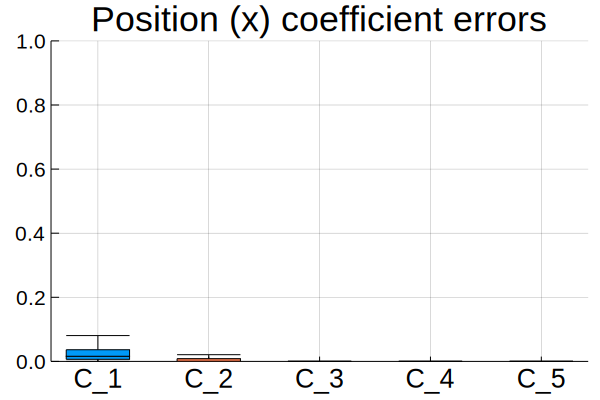

In [47]:
dim = 1
data_this_dim = rpe[:,dim,:]
@show size(data_this_dim)
@show mean(data_this_dim[:,1])
# @show trimmean(data_this_dim)
@show mean(trim(data_this_dim[:,1], prop = 0.3))
@show mean(trim(data_this_dim[:,1], prop = 0.3))
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, titlefontsize = 24)
plot!(ylims=(0,1.0))
title!("Dimension $dim")
title!("Position (x) coefficient errors")

In [48]:
png("xcoeffs.png")

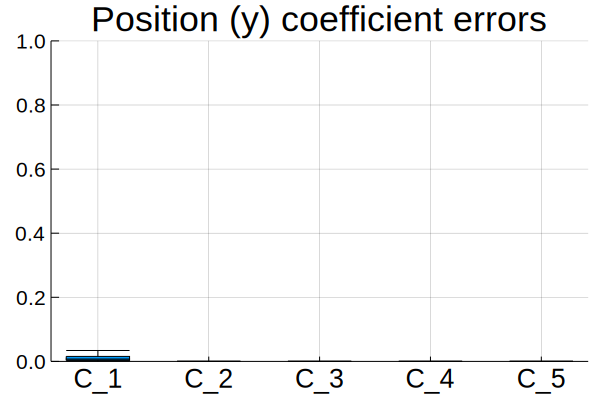

In [49]:
dim = 2
data_this_dim = rpe[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, titlefontsize = 24)
plot!(ylims=(0,1.0))
title!("Dimension $dim")
title!("Position (y) coefficient errors")

In [50]:
png("ycoeffs.png")

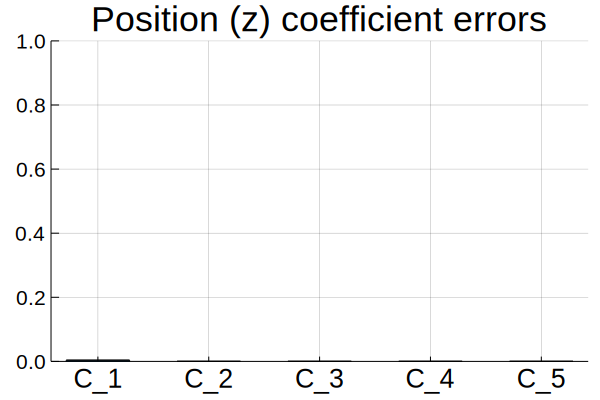

In [51]:
dim = 3
data_this_dim = rpe[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, titlefontsize = 24)
plot!(ylims=(0,1.0))
title!("Dimension $dim")
title!("Position (z) coefficient errors")

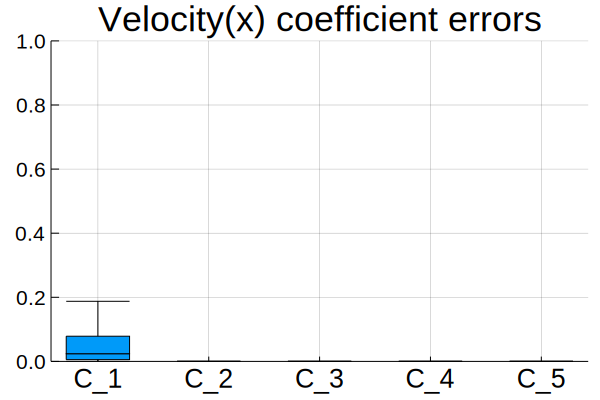

In [52]:
dim = 14
data_this_dim = rpe[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, titlefontsize = 24)
plot!(ylims=(0,1.0))
title!("Dimension $dim")
title!("Velocity(x) coefficient errors")

In [53]:
png("vxcoeffs.png")

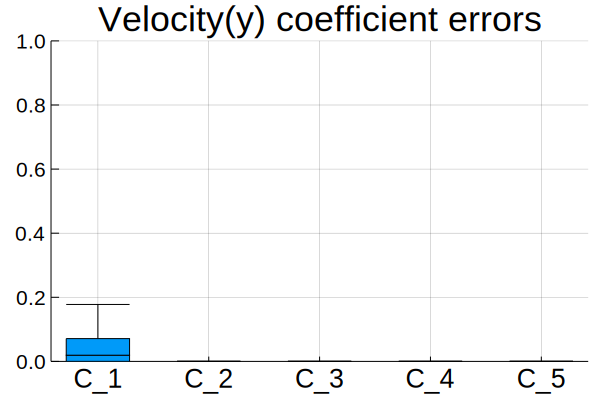

In [54]:
dim = 15
data_this_dim = rpe[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, titlefontsize = 24)
plot!(ylims=(0,1.0))
title!("Dimension $dim")
title!("Velocity(y) coefficient errors")

In [55]:
png("vycoeffs.png")

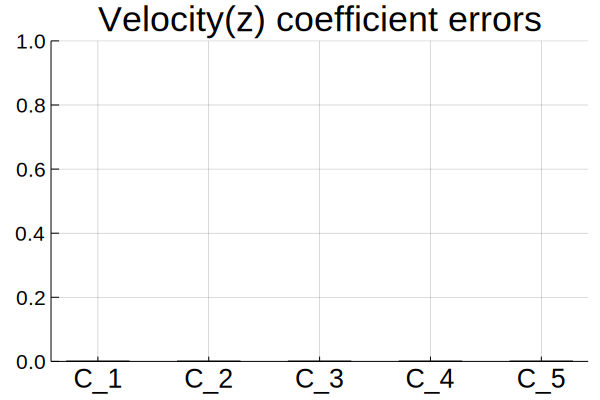

In [42]:
dim = 16
data_this_dim = rpe[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, titlefontsize = 24)
plot!(ylims=(0,1.0))
title!("Dimension $dim")
title!("Velocity(z) coefficient errors")

## Use the symmetric mean absolute percentage error to prevent errors from blowing up

In [30]:
@show extrema(abs.(true_coeffs_matrix))

extrema(abs.(true_coeffs_matrix)) = (1.1481266902236024e-21, 10.039947061851288)


(1.1481266902236024e-21, 10.039947061851288)

In [31]:
# https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
smape = abs.(NN_coeffs_matrix - true_coeffs_matrix)./(abs.(NN_coeffs_matrix) + abs.(true_coeffs_matrix))
@show mean(smape)
@show minimum(smape)
@show maximum(smape)

mean(smape) = 0.5067538042459264
minimum(smape) = 2.173215093694328e-9
maximum(smape) = 1.0


1.0

In [32]:
@show size(smape)

size(smape) = (1130, 19, 5)


(1130, 19, 5)

In [33]:
# Do some error filtering first
for row in 1:size(X_valid_norm,1)
    for dim in 1:(x_dim+u_dim)
        for i in 1:5
            NN_coeff = NN_coeffs_matrix[row,dim,i]
            true_coeff = true_coeffs_matrix[row,dim,i]
            if abs(NN_coeff)<=1e-4 && abs(true_coeff) <= 1e-4
                smape[row,dim,i] = 0.0
            else
                smape[row,dim,i] = abs.(NN_coeff - true_coeff)./(abs.(NN_coeff) + abs.(true_coeff))
            end
        end
    end
end
@show size(smape)

size(smape) = (1130, 19, 5)


(1130, 19, 5)

In [34]:
# using Pkg
# ENV["GRDIR"]=""
# Pkg.build("GR")

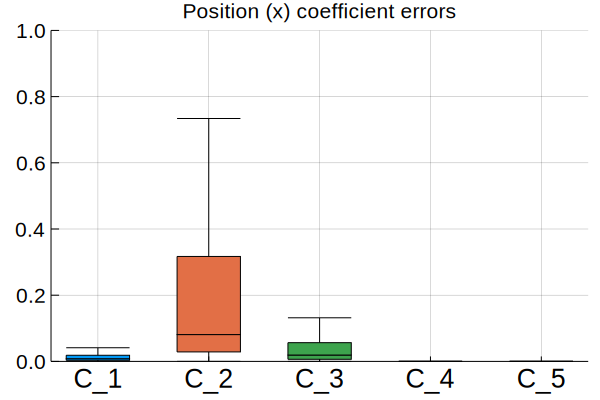

In [35]:
dim = 1
data_this_dim = smape[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3,ylims=(0,1.0))
title!("Dimension $dim")
title!("Position (x) coefficient errors")

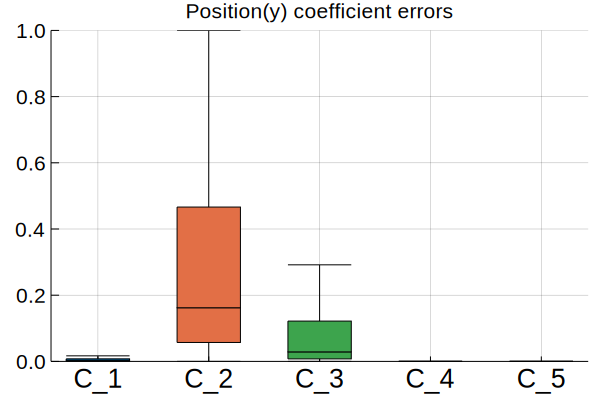

In [36]:
dim = 2
data_this_dim = smape[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3,ylims=(0,1.0))
title!("Dimension $dim")
title!("Position(y) coefficient errors")


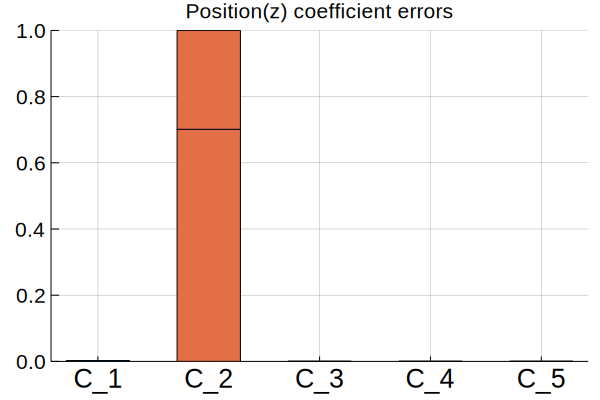

In [37]:
dim = 3
data_this_dim = smape[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3,ylims=(0,1.0))
title!("Dimension $dim")
title!("Position(z) coefficient errors")

# Yeah this looks weird. Just change threshold to 4e-4 instead of 1e-4 and watch errors disappear.

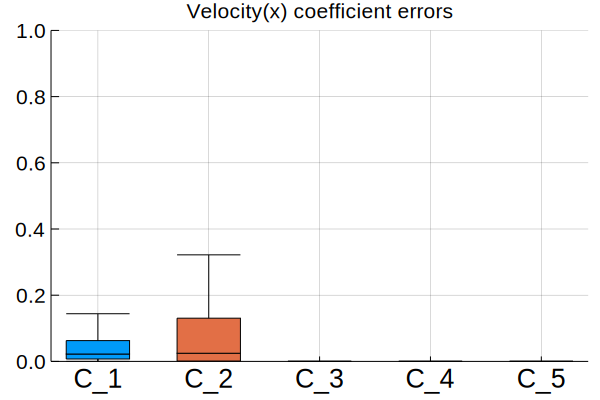

In [38]:
dim = 14
data_this_dim = smape[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3,ylims=(0,1.0))
title!("Dimension $dim")
title!("Velocity(x) coefficient errors")


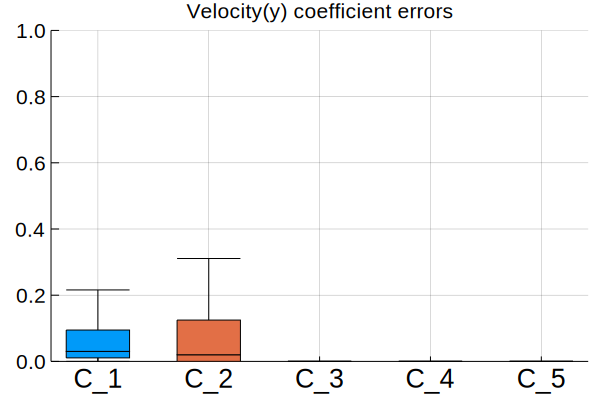

In [39]:
dim = 15
data_this_dim = smape[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3,ylims=(0,1.0))
title!("Dimension $dim")
title!("Velocity(y) coefficient errors")


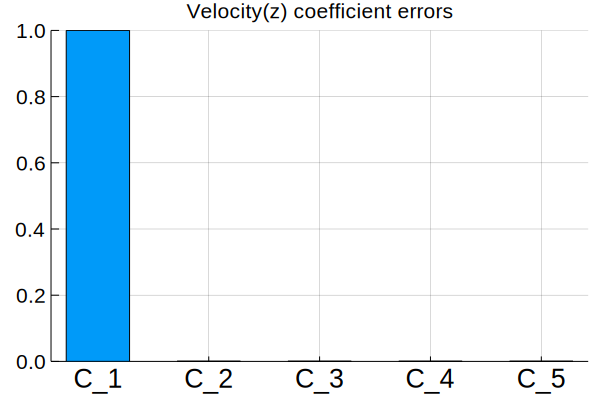

In [123]:
dim = 16
data_this_dim = smape[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3,ylims=(0,1.0))
title!("Dimension $dim")
title!("Velocity(z) coefficient errors")


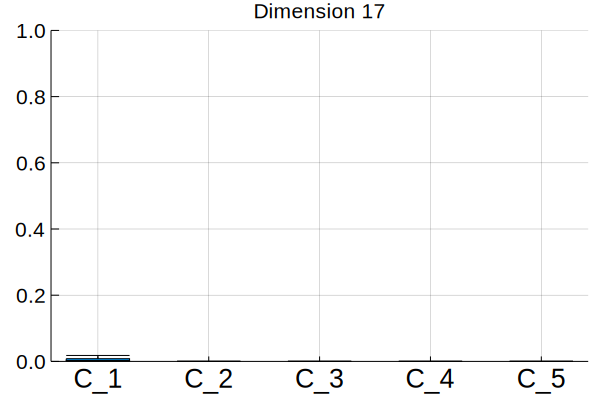

In [87]:
dim = 17
data_this_dim = smape[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3,ylims=(0,1.0))
title!("Dimension $dim")
title!("Dimension $dim")

## Show random coeffs and trajectories to compare

In [35]:
N = 50
tf_guess = 110.
t_array = range(0,stop=tf_guess,length=N)

0.0:2.2448979591836733:110.0

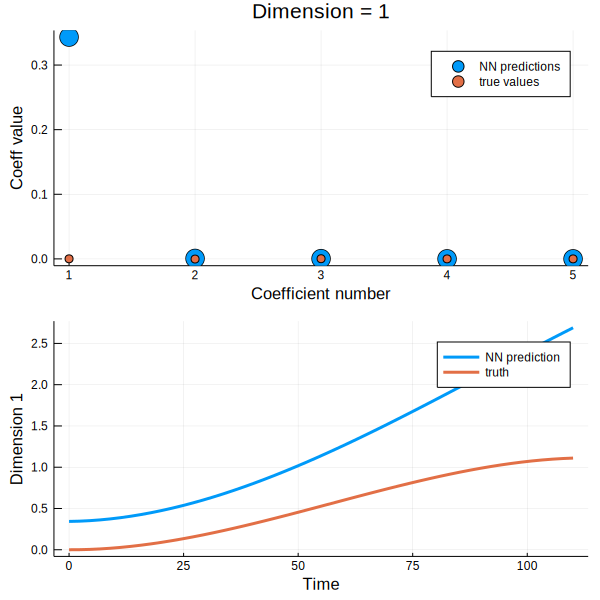

In [36]:
row = 1 # max = size(X_valid_norm,1) == 1130
dim = 1

xs = 1:1:5
NN_coeffs = NN_coeffs_matrix[row,dim,:]
true_coeffs = true_coeffs_matrix[row,dim,:]
p1 = scatter(xs,NN_coeffs,grid=true, label="NN predictions",markersize = 10)
scatter!(xs,true_coeffs,grid=true,label="true values")
title!("Dimension = $dim")
xlabel!("Coefficient number")
ylabel!("Coeff value")
plot!(legend=:best)


NN_traj = recoverXUfromCoeffsSingleDim(NN_coeffs,dim)
true_traj = recoverXUfromCoeffsSingleDim(true_coeffs,dim)
p2 = plot(t_array,NN_traj,label="NN prediction",linewidth = 3)
plot!(t_array,true_traj, label = "truth",linewidth = 3)
xlabel!("Time")
ylabel!("Dimension $dim")
plot!(legend=:best)


plot(p1,p2,
    layout=(2,1))
plot!(size=(600,600))

## Plot X and Y trajectories

x_init = [10.0, 2.22222]
x_final = [8.88889, 7.77778]
NN_coeffs_x = [9.91601, -1.3657e-8, -0.00034411, 1.66384e-6, 1.47345e-9]
true_coeffs_x = [9.99985, 0.000271587, -0.000264001, 1.54396e-6, -4.94547e-12]
NN_coeffs_y = [2.26421, -0.00187322, 0.00134741, -8.17292e-6, 1.18763e-9]
true_coeffs_y = [2.22321, -0.00148285, 0.00135483, -8.00002e-6, -1.90138e-10]


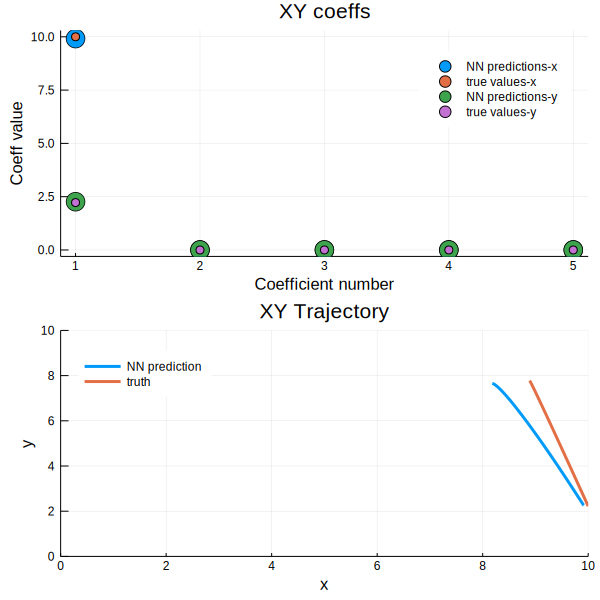

In [211]:
row = 230 # max = size(X_valid_norm,1) == 1130

x_v_norm = X_valid_norm[row,:]
(xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
x_v = x_v_norm.*xRange + xMin
x_init = x_v[1:2]
x_final = x_v[14:15]
@show x_init
@show x_final

NN_coeffs_x = NN_coeffs_matrix[row,1,:]
true_coeffs_x = true_coeffs_matrix[row,1,:]
NN_coeffs_y = NN_coeffs_matrix[row,2,:]
true_coeffs_y = true_coeffs_matrix[row,2,:]

p1 = scatter(xs,NN_coeffs_x,grid=true, label="NN predictions-x",markersize = 10)
scatter!(xs,true_coeffs_x,grid=true,label="true values-x")
scatter!(xs,NN_coeffs_y,grid=true, label="NN predictions-y",markersize = 10)
scatter!(xs,true_coeffs_y,grid=true,label="true values-y")
title!("XY coeffs")
xlabel!("Coefficient number")
ylabel!("Coeff value")
plot!(legend=:best, fg_legend = :transparent)

@show NN_coeffs_x
@show true_coeffs_x
@show NN_coeffs_y
@show true_coeffs_y

NN_x = recoverXUfromCoeffsSingleDim(NN_coeffs_x,1)
true_x = recoverXUfromCoeffsSingleDim(true_coeffs_x,1)
NN_y = recoverXUfromCoeffsSingleDim(NN_coeffs_y,2)
true_y = recoverXUfromCoeffsSingleDim(true_coeffs_y,2)
p2 = plot(NN_x,NN_y,label="NN prediction",linewidth = 3)
plot!(true_x,true_y, label = "truth",linewidth = 3)
title!("XY Trajectory")
xlabel!("x")
ylabel!("y")
plot!(legend=:topleft,fg_legend = :transparent, xlims = (0,10), ylims = (0,10))


plot(p1,p2,
    layout=(2,1))
plot!(size=(600,600))


x_init = [1.8125, 8.0]
x_final = [8.0, 5.0]


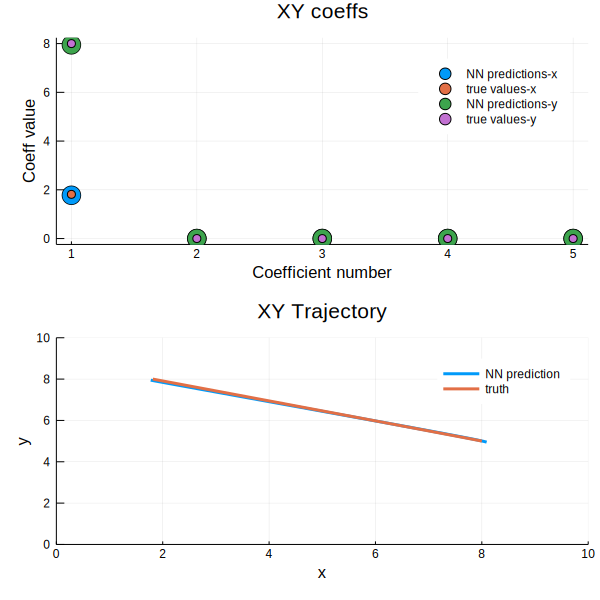

In [128]:
row = 200 # max = size(X_valid_norm,1) == 1130

x_v_norm = X_valid_norm[row,:]
(xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
x_v = x_v_norm.*xRange + xMin
x_init = x_v[1:2]
x_final = x_v[14:15]
@show x_init
@show x_final

NN_coeffs_x = NN_coeffs_matrix[row,1,:]
true_coeffs_x = true_coeffs_matrix[row,1,:]
NN_coeffs_y = NN_coeffs_matrix[row,2,:]
true_coeffs_y = true_coeffs_matrix[row,2,:]

p1 = scatter(xs,NN_coeffs_x,grid=true, label="NN predictions-x",markersize = 10)
scatter!(xs,true_coeffs_x,grid=true,label="true values-x")
scatter!(xs,NN_coeffs_y,grid=true, label="NN predictions-y",markersize = 10)
scatter!(xs,true_coeffs_y,grid=true,label="true values-y")
title!("XY coeffs")
xlabel!("Coefficient number")
ylabel!("Coeff value")
plot!(legend=:best, fg_legend = :transparent)


NN_x = recoverXUfromCoeffsSingleDim(NN_coeffs_x,1)
true_x = recoverXUfromCoeffsSingleDim(true_coeffs_x,1)
NN_y = recoverXUfromCoeffsSingleDim(NN_coeffs_y,2)
true_y = recoverXUfromCoeffsSingleDim(true_coeffs_y,2)
p2 = plot(NN_x,NN_y,label="NN prediction",linewidth = 3)
plot!(true_x,true_y, label = "truth",linewidth = 3)
title!("XY Trajectory")
xlabel!("x")
ylabel!("y")
plot!(legend=:best,fg_legend = :transparent, xlims = (0,10), ylims = (0,10))


plot(p1,p2,
    layout=(2,1))
plot!(size=(600,600))


## Compare x and vx coeffs

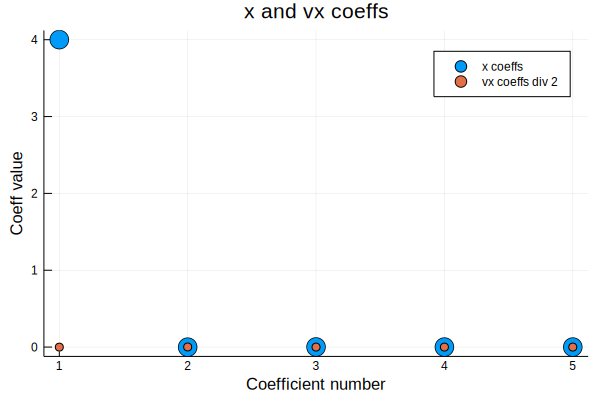

In [50]:
row = 17 # max = size(X_valid_norm,1) == 1130

xs = 1:1:5
# NN_coeffs = NN_coeffs_matrix[row,dim,:]
true_coeffs_x = true_coeffs_matrix[row,1,:]
true_coeffs_vx = true_coeffs_matrix[row,4,:]
p1 = scatter(xs,true_coeffs_x,grid=true, label="x coeffs",markersize = 10)
scatter!(xs,true_coeffs_vx./2.0,grid=true,label="vx coeffs div 2")
title!("x and vx coeffs")
xlabel!("Coefficient number")
ylabel!("Coeff value")
plot!(legend=:best)

## (Older) Manually compute mean and standard deviation

In [51]:
mean_smape = mean(smape, dims = 1)
std_smape = std(smape, dims = 1)
@show size(mean_smape)
@show size(std_smape)
num_dims = x_dim + u_dim
plots = Array{Plots.Plot{Plots.GRBackend}}(undef, num_dims, 1)
for dim in 1:num_dims
    xs = range(1,stop = 5, length = 5)
    μs = mean_smape[1,dim,:]
    σs = std_smape[1,dim,:]

    plots[dim] = scatter(xs,μs,grid=false,yerror=σs)
#     @show typeof(p1)
    title!("Dimension = $dim")
    xlabel!("Coefficient number")
    ylabel!("Relative error between NN and true value")
    plot!(legend=false)
end

size(mean_smape) = (1, 19, 5)
size(std_smape) = (1, 19, 5)


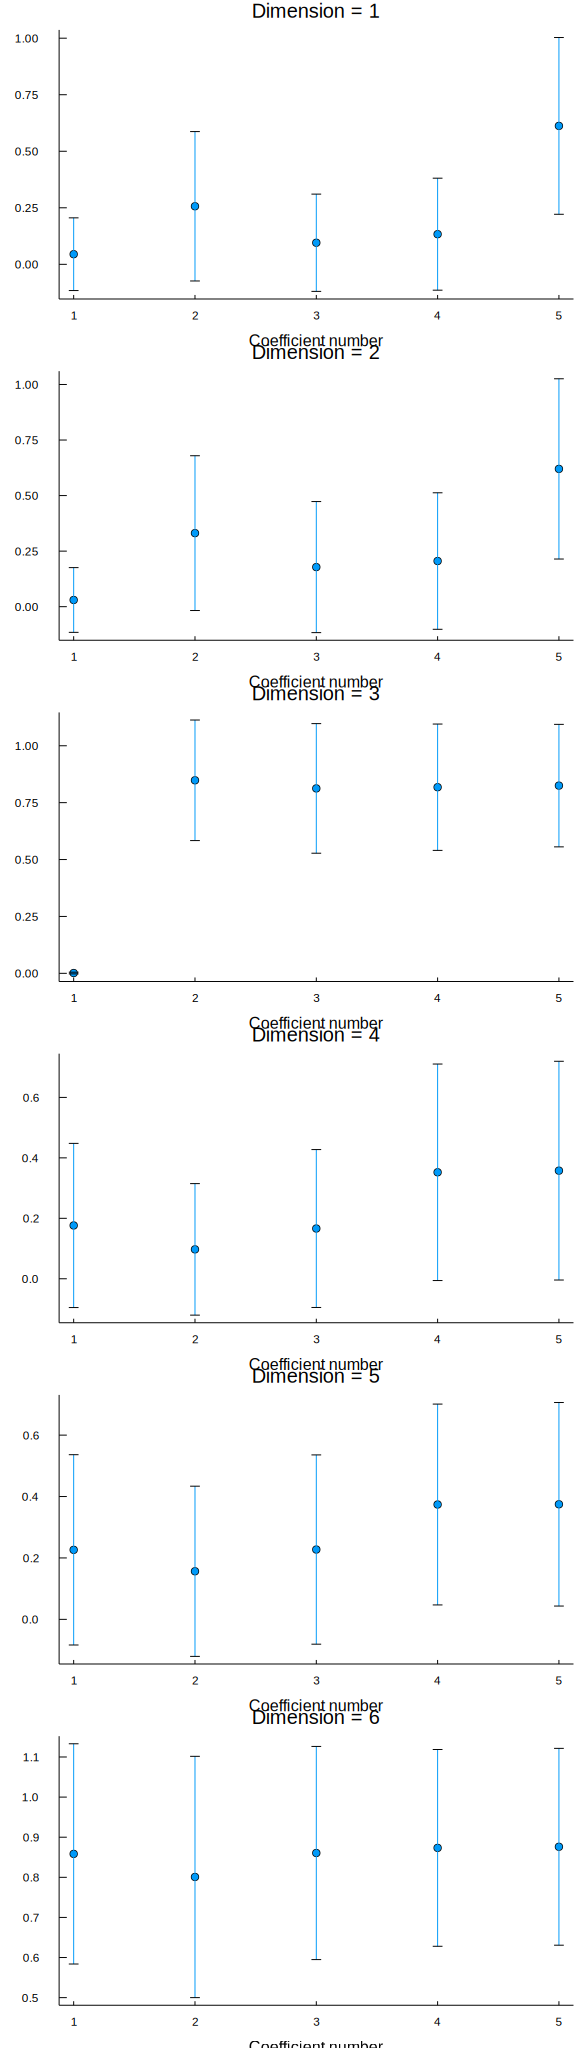

In [52]:
plot(plots[1],plots[2],plots[3],plots[4],plots[5],plots[6],
    layout=(6,1))
plot!(size=(600,6*350))

# Compare cold start and warm start GuSTO performance

### Collect the iteration number and times for each

In [28]:
x_dim = 13
u_dim = 6
num_coeffs = 5

filename = "PolyComboCoeffsNormalized.jld2"
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
(X_valid_norm, Y_valid_norm)  =getXYValid(filename)
X_valid_norm = X_valid_norm'
Y_valid_norm = Y_valid_norm'
# @show size(X_valid_norm)
# @show size(Y_valid_norm)

cold_start_data = zeros(size(X_valid_norm,1), 3)
# NOTE: cold_start_data[row,:] = [converged?, num_iter, solve_time]

warm_start_data = zeros(size(X_valid_norm,1), 3)
# NOTE: warm_start_data[row,:] = [converged?, num_iter, solve_time]

NN_run_data = zeros(size(X_valid_norm,1),1)
# NOTE: NN_run_data[row,:] = NN_solve_time

for row in 1:size(X_valid_norm,1)
# for row in 1:2
    @show row
    # For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
    x_v_norm = X_valid_norm[row,:] # size 26
    # First convert to X_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    x_v = x_v_norm.*xRange + xMin
    x_init = x_v[1:13]
    x_final = x_v[14:26]
    
    model = getModelWithTwoPolyObsOneAtCorner()

    # GuSTO solution time and trajectory
    time_start = time_ns()
    model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model, false)
    gusto_solve_time = (time_ns() - time_start)/10^9
    cold_start_data[row,:]= [isConverged, numIter, gusto_solve_time]
    println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

    # NN prediction time and trajectory
    time_start = time_ns()
    X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
    NN_solve_time = (time_ns() - time_start)/10^9
    NN_run_data[row,1]= NN_solve_time
    @show NN_solve_time

    # GuSTO warm start solution time and trajectory
    time_start = time_ns()
    model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
    gusto_warm_solve_time = (time_ns() - time_start)/10^9
    warm_start_data[row,:]= [isConverged, numIter_warm, gusto_warm_solve_time]
    println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")
    
    println("")

#     plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])

    
    
    
#     # NN prediction time and trajectory
#     NN_coeffs = getNNCoeffsCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
# #     @show size(NN_coeffs)

#     # For the Y_valid_norm, these are 95 coefficients
#     y_v_norm = Y_valid_norm[row,:] # size 95
#     # First convert to Y_valid
#     (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
#     true_coeffs = y_v_norm.*yRange + yMin
# #     @show size(true_coeffs)

#     for dim in 1:(x_dim+u_dim)
#         true_cf_this = true_coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
#         NN_cf_this = NN_coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
#         true_coeffs_matrix[row,dim,:] = true_cf_this
#         NN_coeffs_matrix[row,dim,:] = NN_cf_this
#     end
    if mod(row,10) == 0
        @save "coldstartwarmstartdata.jld2" cold_start_data warm_start_data NN_run_data
        println("Intermediate save")
        println("")
    end
end
@save "coldstartwarmstartdata.jld2" cold_start_data warm_start_data NN_run_data
print("All GuSTO warm start, cold start and NN run times are saved")            

row = 1
GuSTO solve time = 2.714230343 (6 iterations)
NN_solve_time = 0.001656792
GuSTO warm started solve time = 2.532885632 (5 iterations)

row = 2
GuSTO solve time = 3.526867846 (8 iterations)
NN_solve_time = 0.001814397
GuSTO warm started solve time = 5.808556339 (12 iterations)

row = 3
GuSTO solve time = 2.349790236 (5 iterations)
NN_solve_time = 0.001826795
GuSTO warm started solve time = 2.489891548 (5 iterations)

row = 4
GuSTO solve time = 2.60603577 (6 iterations)
NN_solve_time = 0.00174289
GuSTO warm started solve time = 2.249920814 (5 iterations)

row = 5
GuSTO solve time = 2.189115501 (5 iterations)
NN_solve_time = 0.001750169
GuSTO warm started solve time = 2.404912783 (5 iterations)

row = 6
GuSTO solve time = 2.417038132 (5 iterations)
NN_solve_time = 0.001893765
GuSTO warm started solve time = 2.567826798 (5 iterations)

row = 7
GuSTO solve time = 2.162796198 (5 iterations)
NN_solve_time = 0.001820388
GuSTO warm started solve time = 2.698600475 (5 iterations)

row = 8

GuSTO warm started solve time = 2.401300491 (5 iterations)

row = 114
GuSTO solve time = 26.003989594 (51 iterations)
NN_solve_time = 0.001758772
GuSTO warm started solve time = 11.12755476 (21 iterations)

row = 115
GuSTO solve time = 2.153073388 (5 iterations)
NN_solve_time = 0.001832214
GuSTO warm started solve time = 2.196577138 (5 iterations)

row = 116
GuSTO solve time = 13.434173827 (26 iterations)
NN_solve_time = 0.001867643
GuSTO warm started solve time = 5.287806212 (11 iterations)

row = 117
GuSTO solve time = 2.525194575 (5 iterations)
NN_solve_time = 0.002386845
GuSTO warm started solve time = 2.422108837 (5 iterations)

row = 118
GuSTO solve time = 2.300314985 (5 iterations)
NN_solve_time = 0.009134862
GuSTO warm started solve time = 2.402965715 (5 iterations)

row = 119
GuSTO solve time = 4.066994008 (9 iterations)
NN_solve_time = 0.001856667
GuSTO warm started solve time = 3.432905487 (7 iterations)

row = 120
GuSTO solve time = 5.69494748 (12 iterations)
NN_solve_time 

GuSTO warm started solve time = 5.808708117 (12 iterations)

row = 226
GuSTO solve time = 2.082187502 (5 iterations)
NN_solve_time = 0.001833265
GuSTO warm started solve time = 2.098539003 (5 iterations)

row = 227
GuSTO solve time = 1.977450431 (5 iterations)
NN_solve_time = 0.001825161
GuSTO warm started solve time = 2.480741764 (5 iterations)

row = 228
GuSTO solve time = 2.122257909 (5 iterations)
NN_solve_time = 0.001816205
GuSTO warm started solve time = 2.349119409 (5 iterations)

row = 229
GuSTO solve time = 4.294883432 (9 iterations)
NN_solve_time = 0.001793792
GuSTO warm started solve time = 8.23485856 (17 iterations)

row = 230
GuSTO solve time = 2.253543463 (5 iterations)
NN_solve_time = 0.001645739
GuSTO warm started solve time = 2.454437754 (5 iterations)

Intermediate save

row = 231
GuSTO solve time = 2.21146616 (5 iterations)
NN_solve_time = 0.001724284
GuSTO warm started solve time = 2.319425275 (5 iterations)

row = 232
GuSTO solve time = 2.349524374 (5 iterations)
N

GuSTO warm started solve time = 3.557415352 (7 iterations)

row = 338
GuSTO solve time = 2.520341432 (6 iterations)
NN_solve_time = 0.001775881
GuSTO warm started solve time = 2.420223543 (5 iterations)

row = 339
GuSTO solve time = 2.287019757 (5 iterations)
NN_solve_time = 0.001870523
GuSTO warm started solve time = 2.708116822 (5 iterations)

row = 340
GuSTO solve time = 2.28478635 (5 iterations)
NN_solve_time = 0.001725555
GuSTO warm started solve time = 2.409674462 (5 iterations)

Intermediate save

row = 341
GuSTO solve time = 2.466046396 (5 iterations)
NN_solve_time = 0.001800983
GuSTO warm started solve time = 2.498761674 (5 iterations)

row = 342
GuSTO solve time = 2.241050864 (5 iterations)
NN_solve_time = 0.001870924
GuSTO warm started solve time = 2.402587151 (5 iterations)

row = 343
GuSTO solve time = 3.864390552 (9 iterations)
NN_solve_time = 0.001852496
GuSTO warm started solve time = 4.267970948 (9 iterations)

row = 344
GuSTO solve time = 2.215525969 (5 iterations)
NN

GuSTO warm started solve time = 2.501050487 (5 iterations)

row = 450
GuSTO solve time = 2.251423663 (5 iterations)
NN_solve_time = 0.001898689
GuSTO warm started solve time = 2.550594271 (5 iterations)

Intermediate save

row = 451
GuSTO solve time = 7.68105935 (16 iterations)
NN_solve_time = 0.001895982
GuSTO warm started solve time = 3.812436869 (7 iterations)

row = 452
GuSTO solve time = 2.026763149 (5 iterations)
NN_solve_time = 0.001836573
GuSTO warm started solve time = 3.368143637 (7 iterations)

row = 453
GuSTO solve time = 2.189918467 (5 iterations)
NN_solve_time = 0.001842871
GuSTO warm started solve time = 2.580844245 (5 iterations)

row = 454
GuSTO solve time = 2.146882056 (5 iterations)
NN_solve_time = 0.001778392
GuSTO warm started solve time = 2.259146495 (5 iterations)

row = 455
GuSTO solve time = 2.190103417 (5 iterations)
NN_solve_time = 0.001850203
GuSTO warm started solve time = 2.293150135 (5 iterations)

row = 456
GuSTO solve time = 2.553052216 (5 iterations)
N

GuSTO warm started solve time = 7.565944903 (14 iterations)

row = 562
GuSTO solve time = 4.011140791 (9 iterations)
NN_solve_time = 0.001954048
GuSTO warm started solve time = 2.475670238 (5 iterations)

row = 563
GuSTO solve time = 2.745744743 (6 iterations)
NN_solve_time = 0.001931179
GuSTO warm started solve time = 4.391317344 (8 iterations)

row = 564
GuSTO solve time = 2.281541841 (5 iterations)
NN_solve_time = 0.00202622
GuSTO warm started solve time = 2.350754521 (5 iterations)

row = 565
GuSTO solve time = 2.649915004 (5 iterations)
NN_solve_time = 0.00190435
GuSTO warm started solve time = 2.518880258 (5 iterations)

row = 566
GuSTO solve time = 2.317111015 (5 iterations)
NN_solve_time = 0.001845458
GuSTO warm started solve time = 2.31787857 (5 iterations)

row = 567
GuSTO solve time = 2.194169424 (5 iterations)
NN_solve_time = 0.00174038
GuSTO warm started solve time = 2.477134461 (5 iterations)

row = 568
GuSTO solve time = 2.601421266 (5 iterations)
NN_solve_time = 0.00166

GuSTO warm started solve time = 2.394546332 (5 iterations)

row = 674
GuSTO solve time = 4.621995201 (10 iterations)
NN_solve_time = 0.001793693
GuSTO warm started solve time = 19.588378681 (43 iterations)

row = 675
GuSTO solve time = 2.459610168 (5 iterations)
NN_solve_time = 0.001830029
GuSTO warm started solve time = 2.723700686 (5 iterations)

row = 676
GuSTO solve time = 2.718637598 (6 iterations)
NN_solve_time = 0.001675869
GuSTO warm started solve time = 7.225146776 (14 iterations)

row = 677
GuSTO solve time = 3.523291621 (7 iterations)
NN_solve_time = 0.001653039
GuSTO warm started solve time = 6.349209959 (13 iterations)

row = 678
GuSTO solve time = 2.183951857 (5 iterations)
NN_solve_time = 0.001810859
GuSTO warm started solve time = 2.535258816 (5 iterations)

row = 679
GuSTO solve time = 4.112301239 (9 iterations)
NN_solve_time = 0.001769318
GuSTO warm started solve time = 3.047799663 (6 iterations)

row = 680
GuSTO solve time = 7.883145204 (16 iterations)
NN_solve_time 

GuSTO warm started solve time = 2.620650307 (5 iterations)

row = 786
GuSTO solve time = 2.247900333 (5 iterations)
NN_solve_time = 0.001951088
GuSTO warm started solve time = 2.420468559 (5 iterations)

row = 787
GuSTO solve time = 2.391290688 (5 iterations)
NN_solve_time = 0.001960882
GuSTO warm started solve time = 2.427421263 (5 iterations)

row = 788
GuSTO solve time = 2.402108018 (5 iterations)
NN_solve_time = 0.00189965
GuSTO warm started solve time = 2.599629785 (5 iterations)

row = 789
GuSTO solve time = 2.685669275 (6 iterations)
NN_solve_time = 0.00888315
GuSTO warm started solve time = 2.417002425 (5 iterations)

row = 790
GuSTO solve time = 2.150046098 (5 iterations)
NN_solve_time = 0.001846814
GuSTO warm started solve time = 2.519378119 (5 iterations)

Intermediate save

row = 791
GuSTO solve time = 2.476245734 (5 iterations)
NN_solve_time = 0.001879768
GuSTO warm started solve time = 2.443163764 (5 iterations)

row = 792
GuSTO solve time = 9.231260651 (18 iterations)
NN

GuSTO warm started solve time = 2.296387765 (5 iterations)

row = 842
GuSTO solve time = 2.22284533 (5 iterations)
NN_solve_time = 0.001807277
GuSTO warm started solve time = 2.310907963 (5 iterations)

row = 843
GuSTO solve time = 2.214119535 (5 iterations)
NN_solve_time = 0.00182957
GuSTO warm started solve time = 2.406000473 (5 iterations)

row = 844
GuSTO solve time = 2.138973091 (5 iterations)
NN_solve_time = 0.001796936
GuSTO warm started solve time = 2.520253456 (5 iterations)

row = 845
GuSTO solve time = 2.062144906 (5 iterations)
NN_solve_time = 0.001826067
GuSTO warm started solve time = 2.133842597 (5 iterations)

row = 846
GuSTO solve time = 2.412585044 (5 iterations)
NN_solve_time = 0.001812432
GuSTO warm started solve time = 2.560950315 (5 iterations)

row = 847
GuSTO solve time = 2.267419516 (5 iterations)
NN_solve_time = 0.001825008
GuSTO warm started solve time = 2.34983863 (5 iterations)

row = 848
GuSTO solve time = 2.291960684 (5 iterations)
NN_solve_time = 0.00184

GuSTO warm started solve time = 2.378052454 (5 iterations)

row = 954
GuSTO solve time = 2.476572176 (5 iterations)
NN_solve_time = 0.001640359
GuSTO warm started solve time = 2.557154151 (5 iterations)

row = 955
GuSTO solve time = 6.197643896 (13 iterations)
NN_solve_time = 0.001851433
GuSTO warm started solve time = 3.953055238 (8 iterations)

row = 956
GuSTO solve time = 2.118593113 (5 iterations)
NN_solve_time = 0.001830605
GuSTO warm started solve time = 2.374330708 (5 iterations)

row = 957
GuSTO solve time = 22.944757676 (45 iterations)
NN_solve_time = 0.001886686
GuSTO warm started solve time = 13.562818481 (25 iterations)

row = 958
GuSTO solve time = 7.494273201 (15 iterations)
NN_solve_time = 0.001833541
GuSTO warm started solve time = 10.96630337 (22 iterations)

row = 959
GuSTO solve time = 2.345416464 (5 iterations)
NN_solve_time = 0.001801922
GuSTO warm started solve time = 2.403742602 (5 iterations)

row = 960
GuSTO solve time = 3.842573151 (8 iterations)
NN_solve_time

GuSTO warm started solve time = 2.661921948 (5 iterations)

row = 1066
GuSTO solve time = 2.289971459 (5 iterations)
NN_solve_time = 0.001851648
GuSTO warm started solve time = 5.082048334 (10 iterations)

row = 1067
GuSTO solve time = 3.737497706 (8 iterations)
NN_solve_time = 0.001906927
GuSTO warm started solve time = 3.403628555 (7 iterations)

row = 1068
GuSTO solve time = 2.176078623 (5 iterations)
NN_solve_time = 0.001937599
GuSTO warm started solve time = 2.291313222 (5 iterations)

row = 1069
GuSTO solve time = 2.322204817 (5 iterations)
NN_solve_time = 0.001780588
GuSTO warm started solve time = 2.514696869 (5 iterations)

row = 1070
GuSTO solve time = 2.188477748 (5 iterations)
NN_solve_time = 0.001852733
GuSTO warm started solve time = 2.426383444 (5 iterations)

Intermediate save

row = 1071
GuSTO solve time = 2.684005258 (6 iterations)
NN_solve_time = 0.00190139
GuSTO warm started solve time = 4.079183057 (8 iterations)

row = 1072
GuSTO solve time = 2.220556403 (5 iterat

GuSTO warm started solve time = 2.399535338 (5 iterations)

row = 1122
GuSTO solve time = 2.304468323 (5 iterations)
NN_solve_time = 0.001816809
GuSTO warm started solve time = 3.018905101 (6 iterations)

row = 1123
GuSTO solve time = 2.317217608 (5 iterations)
NN_solve_time = 0.002069241
GuSTO warm started solve time = 2.538159896 (5 iterations)

row = 1124
GuSTO solve time = 2.31435733 (5 iterations)
NN_solve_time = 0.001993634
GuSTO warm started solve time = 6.232649001 (13 iterations)

row = 1125
GuSTO solve time = 2.300001984 (5 iterations)
NN_solve_time = 0.001852141
GuSTO warm started solve time = 2.530775791 (5 iterations)

row = 1126
GuSTO solve time = 2.413151003 (5 iterations)
NN_solve_time = 0.001892334
GuSTO warm started solve time = 4.278464441 (8 iterations)

row = 1127
GuSTO solve time = 2.090742698 (5 iterations)
NN_solve_time = 0.002144827
GuSTO warm started solve time = 4.234428201 (9 iterations)

row = 1128
GuSTO solve time = 3.80092553 (9 iterations)
NN_solve_time 

In [29]:
@show cold_start_data

cold_start_data = [1.0 6.0 2.71423; 1.0 8.0 3.52687; 1.0 5.0 2.34979; 1.0 6.0 2.60604; 1.0 5.0 2.18912; 1.0 5.0 2.41704; 1.0 5.0 2.1628; 1.0 5.0 2.28232; 1.0 42.0 21.3166; 1.0 5.0 2.28218; 1.0 5.0 2.63995; 1.0 12.0 6.39065; 1.0 5.0 2.3122; 1.0 11.0 5.06311; 1.0 8.0 3.73068; 1.0 5.0 2.22857; 1.0 5.0 2.37294; 1.0 6.0 2.72134; 1.0 5.0 2.14812; 1.0 6.0 2.72582; 1.0 5.0 2.4651; 1.0 51.0 27.0558; 1.0 5.0 2.1918; 1.0 8.0 3.61413; 1.0 5.0 2.33641; 1.0 5.0 2.32241; 1.0 9.0 4.31091; 1.0 5.0 2.27544; 1.0 5.0 2.16644; 1.0 26.0 12.5022; 1.0 5.0 2.4153; 1.0 5.0 2.28447; 1.0 8.0 3.51976; 1.0 5.0 2.21211; 1.0 5.0 2.22242; 1.0 5.0 2.2984; 1.0 8.0 3.93104; 1.0 17.0 8.0984; 1.0 5.0 2.3678; 1.0 5.0 2.2015; 1.0 15.0 8.29586; 1.0 5.0 2.41873; 1.0 8.0 3.83096; 1.0 5.0 2.04495; 1.0 5.0 2.26785; 1.0 5.0 2.20272; 1.0 6.0 2.68918; 1.0 7.0 3.02827; 1.0 5.0 2.22812; 1.0 5.0 2.20027; 1.0 5.0 2.20577; 1.0 5.0 2.34827; 1.0 7.0 3.02329; 1.0 5.0 2.04379; 1.0 5.0 2.21663; 1.0 16.0 7.5262; 1.0 5.0 2.39078; 1.0 5.0 2.0779

1130×3 Array{Float64,2}:
 1.0   6.0   2.71423
 1.0   8.0   3.52687
 1.0   5.0   2.34979
 1.0   6.0   2.60604
 1.0   5.0   2.18912
 1.0   5.0   2.41704
 1.0   5.0   2.1628 
 1.0   5.0   2.28232
 1.0  42.0  21.3166 
 1.0   5.0   2.28218
 1.0   5.0   2.63995
 1.0  12.0   6.39065
 1.0   5.0   2.3122 
 ⋮                  
 1.0   5.0   2.20794
 1.0   8.0   3.5867 
 1.0   5.0   2.19155
 1.0   5.0   2.30447
 1.0   5.0   2.31722
 1.0   5.0   2.31436
 1.0   5.0   2.3    
 1.0   5.0   2.41315
 1.0   5.0   2.09074
 1.0   9.0   3.80093
 1.0   5.0   2.27735
 1.0   5.0   2.23958

In [30]:
@show warm_start_data

warm_start_data = [1.0 5.0 2.53289; 1.0 12.0 5.80856; 1.0 5.0 2.48989; 1.0 5.0 2.24992; 1.0 5.0 2.40491; 1.0 5.0 2.56783; 1.0 5.0 2.6986; 1.0 5.0 2.31908; 1.0 8.0 3.99792; 1.0 6.0 3.01203; 1.0 5.0 2.62211; 1.0 14.0 7.65857; 1.0 5.0 2.50581; 0.0 200.0 97.8711; 1.0 14.0 7.02225; 1.0 6.0 2.9736; 1.0 5.0 2.58106; 1.0 7.0 3.65646; 1.0 5.0 2.35674; 1.0 11.0 5.45909; 1.0 5.0 2.67582; 1.0 8.0 4.05897; 1.0 5.0 2.38127; 1.0 13.0 6.70558; 1.0 5.0 2.43653; 1.0 5.0 2.46162; 1.0 9.0 4.67482; 1.0 5.0 2.43007; 1.0 5.0 2.34689; 1.0 10.0 5.07161; 1.0 5.0 2.33969; 1.0 5.0 2.64093; 1.0 7.0 3.44349; 1.0 5.0 2.35967; 1.0 5.0 2.27474; 1.0 5.0 2.60259; 1.0 7.0 3.58469; 1.0 20.0 10.9136; 1.0 6.0 3.33027; 1.0 5.0 2.61197; 1.0 23.0 11.4441; 1.0 5.0 2.54937; 1.0 7.0 3.63397; 1.0 5.0 2.37559; 0.0 200.0 91.2079; 1.0 5.0 2.39744; 1.0 5.0 2.40191; 1.0 5.0 2.50833; 1.0 5.0 2.45179; 1.0 6.0 3.13923; 1.0 5.0 2.23186; 1.0 5.0 2.58735; 1.0 8.0 3.79357; 1.0 5.0 2.20335; 1.0 5.0 2.40632; 1.0 14.0 6.47868; 1.0 5.0 2.3292; 1.

1130×3 Array{Float64,2}:
 1.0   5.0   2.53289
 1.0  12.0   5.80856
 1.0   5.0   2.48989
 1.0   5.0   2.24992
 1.0   5.0   2.40491
 1.0   5.0   2.56783
 1.0   5.0   2.6986 
 1.0   5.0   2.31908
 1.0   8.0   3.99792
 1.0   6.0   3.01203
 1.0   5.0   2.62211
 1.0  14.0   7.65857
 1.0   5.0   2.50581
 ⋮                  
 1.0   5.0   2.4559 
 1.0  26.0  13.1949 
 1.0   5.0   2.39954
 1.0   6.0   3.01891
 1.0   5.0   2.53816
 1.0  13.0   6.23265
 1.0   5.0   2.53078
 1.0   8.0   4.27846
 1.0   9.0   4.23443
 1.0   5.0   2.34696
 1.0  13.0   7.04586
 1.0   5.0   2.48265

In [31]:
@show NN_run_data

NN_run_data = [0.00165679; 0.0018144; 0.00182679; 0.00174289; 0.00175017; 0.00189376; 0.00182039; 0.00184479; 0.00160971; 0.00174628; 0.00189155; 0.00176492; 0.00170759; 0.00169011; 0.00185385; 0.00218924; 0.00175421; 0.00224732; 0.0019192; 0.00177926; 0.00165819; 0.00171589; 0.00178922; 0.0018674; 0.00176208; 0.00179761; 0.00170202; 0.00174804; 0.00174904; 0.00184821; 0.00177157; 0.00184495; 0.00802945; 0.0016721; 0.00180566; 0.00180804; 0.0018796; 0.0017064; 0.00183235; 0.00191777; 0.00164081; 0.00190039; 0.00184226; 0.00936382; 0.00188697; 0.00175689; 0.00839397; 0.00176236; 0.0017875; 0.00182665; 0.00181433; 0.00180186; 0.00188078; 0.00182742; 0.00187884; 0.0018955; 0.00180371; 0.00184309; 0.0019237; 0.0018401; 0.00187696; 0.00183809; 0.00185126; 0.00177919; 0.00181702; 0.00188502; 0.00186288; 0.00881063; 0.00183939; 0.0018173; 0.00180789; 0.00180112; 0.00179431; 0.00179558; 0.00186348; 0.00180531; 0.00184266; 0.00181578; 0.00178928; 0.00175748; 0.00180632; 0.00178967; 0.00178325; 

1130×1 Array{Float64,2}:
 0.001656792
 0.001814397
 0.001826795
 0.00174289 
 0.001750169
 0.001893765
 0.001820388
 0.001844792
 0.001609711
 0.001746277
 0.001891553
 0.001764918
 0.001707595
 ⋮          
 0.001897456
 0.001868587
 0.001780532
 0.001816809
 0.002069241
 0.001993634
 0.001852141
 0.001892334
 0.002144827
 0.001945072
 0.001906113
 0.001870961

## Plotting cold and warm start data

In [132]:
@load "coldstartwarmstartdata.jld2" cold_start_data warm_start_data NN_run_data


3-element Array{Symbol,1}:
 :cold_start_data
 :warm_start_data
 :NN_run_data    

In [140]:
@show size(cold_start_data)
cold_conv = cold_start_data[:,1]
@show extrema(cold_conv)
warm_conv = warm_start_data[:,1]
@show extrema(warm_conv)

size(cold_start_data) = (1130, 3)
extrema(cold_conv) = (1.0, 1.0)
extrema(warm_conv) = (0.0, 1.0)


(0.0, 1.0)

In [144]:
for row = 1:size(cold_start_data,1)
    if warm_conv[row] == 0.0
        println("didn't converge")
        @show warm_start_data[row,2]
        continue;
    end
end


didn't converge
didn't converge
didn't converge
didn't converge
didn't converge
didn't converge
didn't converge


In [188]:
w = warm_start_data
c = cold_start_data
w_filt = [w[i,:] for i=1:size(w,1) if w[i,1]==1 && c[i,1]==1]
c_filt = [c[i,:] for i=1:size(c,1) if w[i,1]==1 && c[i,1]==1]
c_filt = Array(hcat(c_filt...)')
w_filt = Array(hcat(w_filt...)')

1123×3 Array{Float64,2}:
 1.0   5.0   2.53289
 1.0  12.0   5.80856
 1.0   5.0   2.48989
 1.0   5.0   2.24992
 1.0   5.0   2.40491
 1.0   5.0   2.56783
 1.0   5.0   2.6986 
 1.0   5.0   2.31908
 1.0   8.0   3.99792
 1.0   6.0   3.01203
 1.0   5.0   2.62211
 1.0  14.0   7.65857
 1.0   5.0   2.50581
 ⋮                  
 1.0   5.0   2.4559 
 1.0  26.0  13.1949 
 1.0   5.0   2.39954
 1.0   6.0   3.01891
 1.0   5.0   2.53816
 1.0  13.0   6.23265
 1.0   5.0   2.53078
 1.0   8.0   4.27846
 1.0   9.0   4.23443
 1.0   5.0   2.34696
 1.0  13.0   7.04586
 1.0   5.0   2.48265

In [191]:
warm_iter = w_filt[:,2]
cold_iter = c_filt[:,2]
@show mean(warm_iter)
@show mean(cold_iter)
warm_time = w_filt[:,3]
cold_time = c_filt[:,3]
@show mean(warm_time)
@show mean(cold_time)

mean(warm_iter) = 8.463045414069457
mean(cold_iter) = 9.219056099732859
mean(warm_time) = 4.232061255051647
mean(cold_time) = 4.434821645786287


4.434821645786287

mean(cold_iter) = 9.219056099732859
mean(warm_iter) = 8.463045414069457
median(cold_iter) = 5.0
median(warm_iter) = 5.0
size(diff_iter) = (1123, 2)


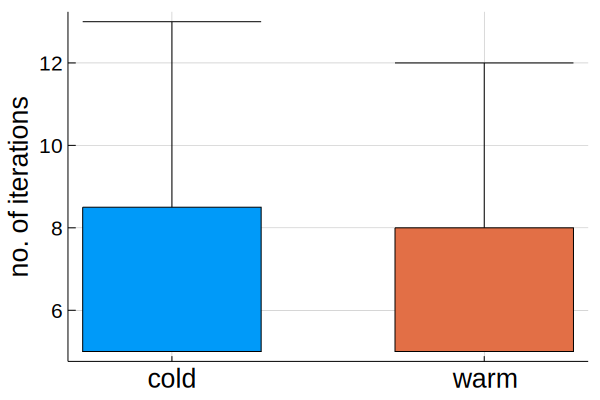

In [227]:
diff_iter = zeros(size(w_filt,1),2)
diff_iter[:,1] = cold_iter
diff_iter[:,2] = warm_iter
@show mean(cold_iter)
@show mean(warm_iter)
@show median(cold_iter)
@show median(warm_iter)

@show size(diff_iter)
boxplot(["cold" "warm"],diff_iter,leg=false; outliers= false)
plot!(yaxis="no. of iterations")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


mean(diff_iter[:, 1]) = 4.434821645786287
mean(diff_iter[:, 2]) = 4.232061255051647
size(diff_iter) = (1123, 2)


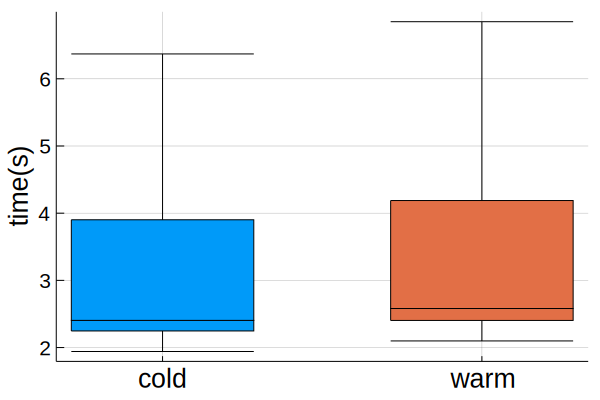

In [204]:
diff_iter = zeros(size(w_filt,1),2)
diff_iter[:,1] = cold_time
diff_iter[:,2] = warm_time
@show mean(diff_iter[:,1])
@show mean(diff_iter[:,2])

@show size(diff_iter)
boxplot(["cold" "warm"],diff_iter,leg=false; outliers= false)
plot!(yaxis="time(s)")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


In [210]:
diff_iter = cold_iter - warm_iter
count(x->x==0.0,diff_iter)
# count(x->x<0.0,diff_iter)

667

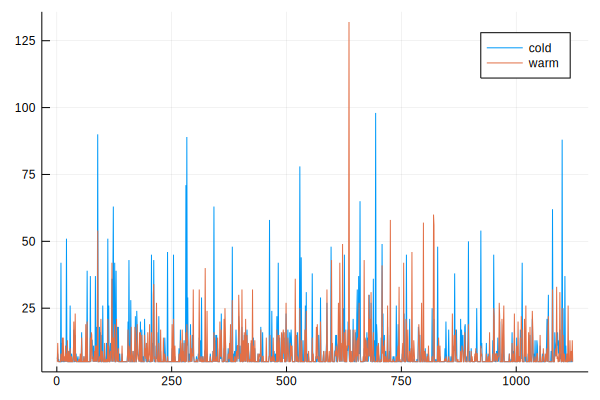

In [218]:
xs = 1:size(w_filt,1)
plot(xs, cold_iter,label="cold")
plot!(xs, warm_iter, label = "warm")


In [222]:
w_filt_large_iter = [w_filt[i,:] for i=1:size(w_filt,1) if c_filt[i,2]>=10]
c_filt_large_iter = [c_filt[i,:] for i=1:size(c_filt,1) if c_filt[i,2]>=10]
c_filt_large_iter = Array(hcat(c_filt_large_iter...)')
w_filt_large_iter = Array(hcat(w_filt_large_iter...)')
@show size(w_filt_large_iter)
@show size(c_filt_large_iter)

size(w_filt_large_iter) = (244, 3)
size(c_filt_large_iter) = (244, 3)


(244, 3)

mean(diff_iter[:, 1]) = 22.327868852459016
mean(diff_iter[:, 2]) = 14.540983606557377
median(diff_iter[:, 1]) = 16.0
median(diff_iter[:, 2]) = 12.0
size(diff_iter) = (244, 2)


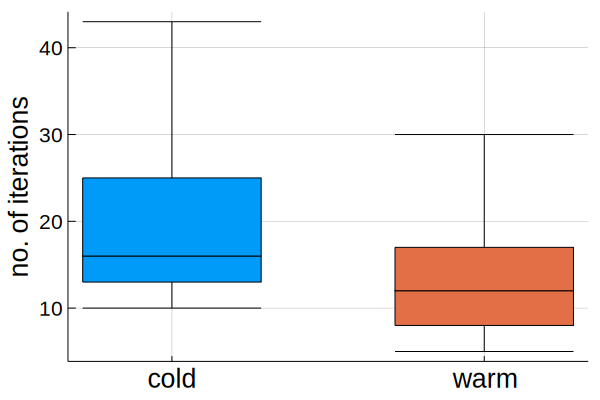

In [228]:
diff_iter = zeros(size(w_filt_large_iter,1),2)
diff_iter[:,1] = c_filt_large_iter[:,2]
diff_iter[:,2] = w_filt_large_iter[:,2]
@show mean(diff_iter[:,1])
@show mean(diff_iter[:,2])
@show median(diff_iter[:,1])
@show median(diff_iter[:,2])

@show size(diff_iter)
boxplot(["cold" "warm"],diff_iter,leg=false; outliers= false)
plot!(yaxis="no. of iterations")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


In [232]:
w_filt_large_iter = [w_filt[i,:] for i=1:size(w_filt,1) if c_filt[i,2]>6]
c_filt_large_iter = [c_filt[i,:] for i=1:size(c_filt,1) if c_filt[i,2]>6]
c_filt_large_iter = Array(hcat(c_filt_large_iter...)')
w_filt_large_iter = Array(hcat(w_filt_large_iter...)')
@show size(w_filt_large_iter)
@show size(c_filt_large_iter)

size(w_filt_large_iter) = (405, 3)
size(c_filt_large_iter) = (405, 3)


(405, 3)

mean(diff_iter[:, 1]) = 16.59259259259259
mean(diff_iter[:, 2]) = 13.57037037037037
median(diff_iter[:, 1]) = 12.0
median(diff_iter[:, 2]) = 10.0
size(diff_iter) = (405, 2)


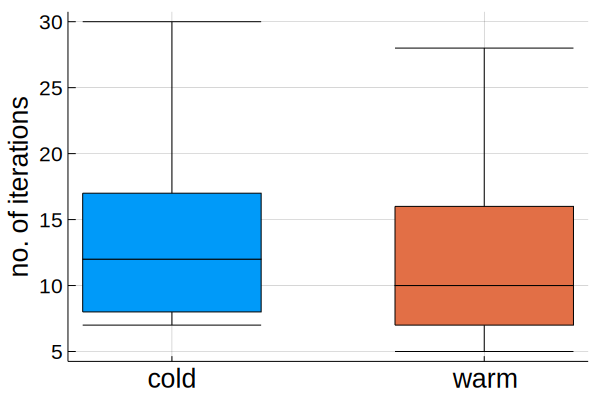

In [235]:
diff_iter = zeros(size(w_filt_large_iter,1),2)
diff_iter[:,1] = c_filt_large_iter[:,2]
diff_iter[:,2] = w_filt_large_iter[:,2]
@show mean(diff_iter[:,1])
@show mean(diff_iter[:,2])
@show median(diff_iter[:,1])
@show median(diff_iter[:,2])

@show size(diff_iter)
boxplot(["cold" "warm"],diff_iter,leg=false; outliers= false)
plot!(yaxis="no. of iterations")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


# Warm-starting
- Find GuSTO solution (time it, plot it)
- Find NN prediction (time it, plot it) 
- Start GuSTO with NN prediction (time it, plot it)

In [ ]:
x_start= [0.0, 7.0, 0.0]
x_goal = [8.0, 7.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


## Refine plots

In [ ]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best, legendfontsize=10)
plot!(size=(550,550))
# xlabel!("x")
# ylabel!("y")
xaxis!(:off)
yaxis!(:off)
plot!(framestyle = :box)

In [ ]:
png("addABorder")

In [ ]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], 2.5, 3, 0.002, 1.78, 1)
# plot!(legend = :best, legendfontsize = 9, fg_legend = :transparent)
# plot!(size = (500,500))
# plot!(aspect_ratio = 1.0)
plot!(legend = :best)


In [ ]:
png("testing")

In [ ]:
x_start= [0.0, 8.0, 0.0]
x_goal = [8.0, 8.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


In [ ]:
x_start= [3.0, 8.0, 0.0]
x_goal = [8.0, 8.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


In [ ]:
x_start= [3.0, 8.0, 0.0]
x_goal = [8.0, 3.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


In [ ]:
x_start= [0.0, 7.0, 0.0]
x_goal = [8.0, 5.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


In [ ]:
x_start= [0.0, 7.0, 0.0]
x_goal = [8.0, 8.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


In [ ]:
x_start= [0.0, 7.0, 0.0]
x_goal = [7.0, 6.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


# Try new poly combo model

In [ ]:
x_start= [5.55555556, 1.11111111, 0.5]
x_goal = [7.77777778, 6.66666667, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("Simple case not bad 2")

In [ ]:
x_start= [0.5, 7.0, 0.5]
x_goal = [6.0, 2.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("2x good speedup")

In [ ]:
x_start= [3.0, 6.0, 0.5]
x_goal = [7.0, 0.5, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# Increase convergence threshold 
model.convergence_threshold = 5.0

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("5x speedup")

In [ ]:
x_start= [0.5, 6.125, 0.5]
x_goal = [9.0, 2.75, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("NN helped you avoid obstacles 3")

# Try to add an obstacle to GuSTO now

In [ ]:
# Solve with one extra obstacle

x_start= [0.5, 6.125, 0.5]
x_goal = [9.0, 2.75, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO original solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_init, U_all_init = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN original prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time


# Add an extra obstacle
poly_obstacles = []
obs = PolygonalObstacle([7.0,4.2,0.5], [0.5, 1.0, 2.0])
push!(model.poly_obstacles, obs)


# GuSTO solution time and trajectory- COLD START
time_start = time_ns()
model, isConverged, numIter, X_all_new_cold, U_all_new_cold = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# GuSTO start solution time and trajectory- WARM START
time_start = time_ns()
model, isConverged, numIter_warm, X_all_new_warm, U_all_new_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

In [ ]:
plot_env_and_trajs(model, [X_all_init[end],X_all_new_cold[end],  X_all_new_warm[end]])

In [ ]:
x_start= [0.9375, 8.0, 0.5]
x_goal = [7.5, 2.1875, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :top)

In [ ]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best, legendfontsize=10)
plot!(size=(550,550))
xlabel!("x", guidefontsize = 13)
ylabel!("y", guidefontsize = 13)
plot!(tickfontsize = 12)


In [ ]:
png("warmstartexample")

# Get four differnt types of trajectories and compare the warm-starting

In [92]:
x_start= [0.9375, 8.0, 0.5]
x_goal = [7.5, 2.1875, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



GuSTO solve time = 17.306617407 (20 iterations)
NN_solve_time = 0.211688264
GuSTO warm started solve time = 5.246600859 (7 iterations)


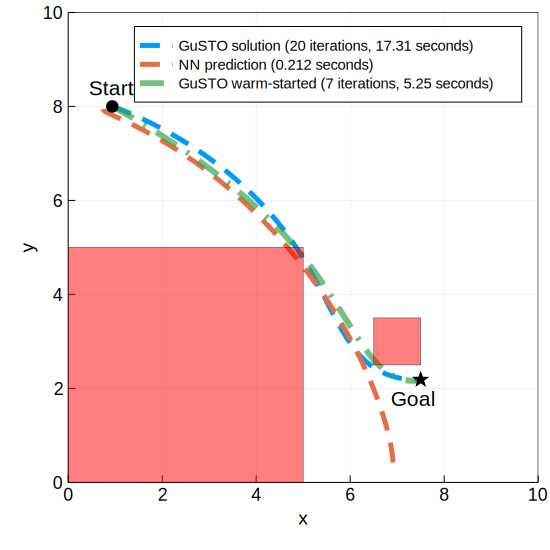

In [93]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :top)
plot!(legend = :best, legendfontsize=10)
plot!(size=(550,550))
xlabel!("x", guidefontsize = 13)
ylabel!("y", guidefontsize = 13)
plot!(tickfontsize = 12)

In [94]:
x_start= [6.0, 1.0, 0.5]
x_goal = [7.5, 5., 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



GuSTO solve time = 11.969854348 (15 iterations)
NN_solve_time = 0.012632869
GuSTO warm started solve time = 5.101178697 (7 iterations)


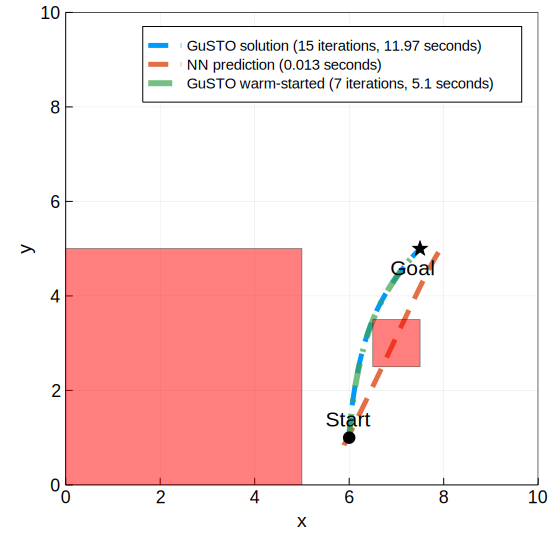

In [95]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :top)
plot!(legend = :best, legendfontsize=10)
plot!(size=(550,550))
xlabel!("x", guidefontsize = 13)
ylabel!("y", guidefontsize = 13)
plot!(tickfontsize = 12)

In [96]:
x_start= [0.5, 6.0, 0.5]
x_goal = [9.0, 1., 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



GuSTO solve time = 15.140566363 (21 iterations)
NN_solve_time = 0.033848478
GuSTO warm started solve time = 21.651715297 (29 iterations)


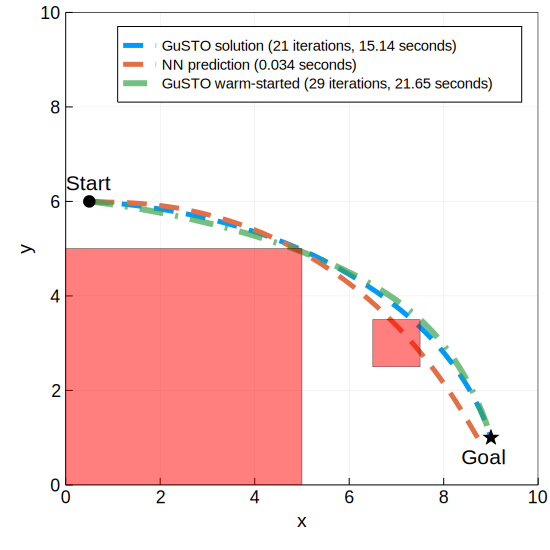

In [97]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :top)
plot!(legend = :best, legendfontsize=10)
plot!(size=(550,550))
xlabel!("x", guidefontsize = 13)
ylabel!("y", guidefontsize = 13)
plot!(tickfontsize = 12)

In [98]:
x_start= [8.0, 1.0, 0.5]
x_goal = [5.0, 6., 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



GuSTO solve time = 11.229065241 (12 iterations)
NN_solve_time = 0.004222941
GuSTO warm started solve time = 8.522013225 (11 iterations)


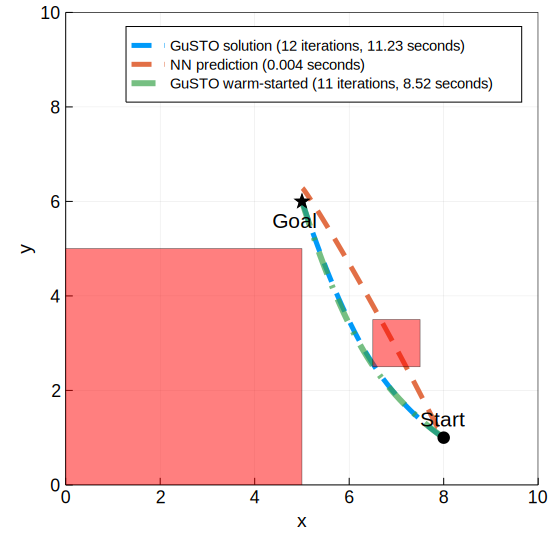

In [99]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :top)
plot!(legend = :best, legendfontsize=10)
plot!(size=(550,550))
xlabel!("x", guidefontsize = 13)
ylabel!("y", guidefontsize = 13)
plot!(tickfontsize = 12)

# Plotting function

In [100]:
function plot_three_comp_no_label(model, X_all, labls = :None, time1="", iter1="", time2 ="", time3="", iter3="")
    N = length(X_all)
    labls = ["GuSTO solution", "NN prediction", "GuSTO warm-started"]
    idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    
    
    
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 1)
        elseif iter == 2
            r = plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 2)
#             @show r.color
        else
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(6, :dashdot), linealpha = 0.7, lab = labls[iter], color = 3)
        end        
    end
    
    st_pt = X_all[1][idx[1]:idx[2],1]
    scatter!([st_pt[1]], [st_pt[2]], shape = :circle, markersize = 6, color = :black, lab = "")
    end_pt = X_all[1][idx[1]:idx[2],end]
    scatter!([end_pt[1]], [end_pt[2]], shape = :star, markersize = 8, color = :black, lab = "")
    annotate!([(st_pt[1]-0.5, st_pt[2]+0.4, text("Start", 14, :black, :left)), 
            (end_pt[1]+0.3, end_pt[2]-0.4, text("Goal", 14, :black, :right))])


    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black, linealpha = 0.7,
                fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(legend = :best, legendfontsize=10)
    plot!(size=(550,550))
    xlabel!("x", guidefontsize = 13)
    ylabel!("y", guidefontsize = 13)
    plot!(tickfontsize = 12)
    return fig
end

plot_three_comp_no_label (generic function with 7 methods)

In [101]:
function simplePlot(x_start, x_goal)
    x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
    x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


    # GuSTO solution time and trajectory
    model = getModelWithTwoPolyObsOneAtCorner()
    model.convergence_threshold = 5.0
    time_start = time_ns()
    model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
    gusto_solve_time = (time_ns() - time_start)/10^9
    println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

    # NN prediction time and trajectory
    paramsFileName = "PolyComboParams.h5"
    jsonFileName = "SimpleAstrobeeTemplate.json"
    weightsFileName = "PolyComboWeights.h5"
    time_start = time_ns()
    X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
    NN_solve_time = (time_ns() - time_start)/10^9
    @show NN_solve_time

    # GuSTO warm start solution time and trajectory
    model = getModelWithTwoPolyObsOneAtCorner()
    model.convergence_threshold = 5.0
    time_start = time_ns()
    model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
    gusto_warm_solve_time = (time_ns() - time_start)/10^9
    println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

    p = plot_three_comp_no_label(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
    return p
end

simplePlot (generic function with 1 method)

# Four plots in one

In [102]:
x_start= [0.9375, 8.0, 0.5]
x_goal = [7.5, 2.1875, 0.5]
p1=simplePlot(x_start, x_goal)
x_start= [6.0, 1.0, 0.5]
x_goal = [7.5, 5., 0.5]
p2=simplePlot(x_start, x_goal)
x_start= [0.5, 6.0, 0.5]
x_goal = [9.0, 1., 0.5]
p3=simplePlot(x_start, x_goal)
x_start= [8.0, 1.0, 0.5]
x_goal = [5.0, 6., 0.5]
p4=simplePlot(x_start, x_goal)
plot()
plot!(p1,p2,p3,p4)

GuSTO solve time = 15.697586834 (20 iterations)
NN_solve_time = 0.004453007
GuSTO warm started solve time = 5.911834876 (7 iterations)
GuSTO solve time = 12.350934483 (15 iterations)
NN_solve_time = 0.002080966
GuSTO warm started solve time = 5.312291175 (7 iterations)
GuSTO solve time = 17.414430276 (21 iterations)
NN_solve_time = 0.003557764
GuSTO warm started solve time = 27.126789249 (29 iterations)
GuSTO solve time = 11.171603788 (12 iterations)
NN_solve_time = 0.004093559
GuSTO warm started solve time = 10.742925575 (11 iterations)


MethodError: MethodError: no method matching Plots.Plot{Plots.GRBackend}(::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char)
Closest candidates are:
  Plots.Plot{Plots.GRBackend}(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any) where T<:AbstractBackend at /home/somrita/.julia/packages/Plots/AXUqs/src/types.jl:68

In [103]:
plot()
plot!(p2)
plot!(p1,p2)
# plot!(p1,p2,p3,p4,layout=(2,2))

MethodError: MethodError: no method matching Plots.Plot{Plots.GRBackend}(::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char)
Closest candidates are:
  Plots.Plot{Plots.GRBackend}(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any) where T<:AbstractBackend at /home/somrita/.julia/packages/Plots/AXUqs/src/types.jl:68

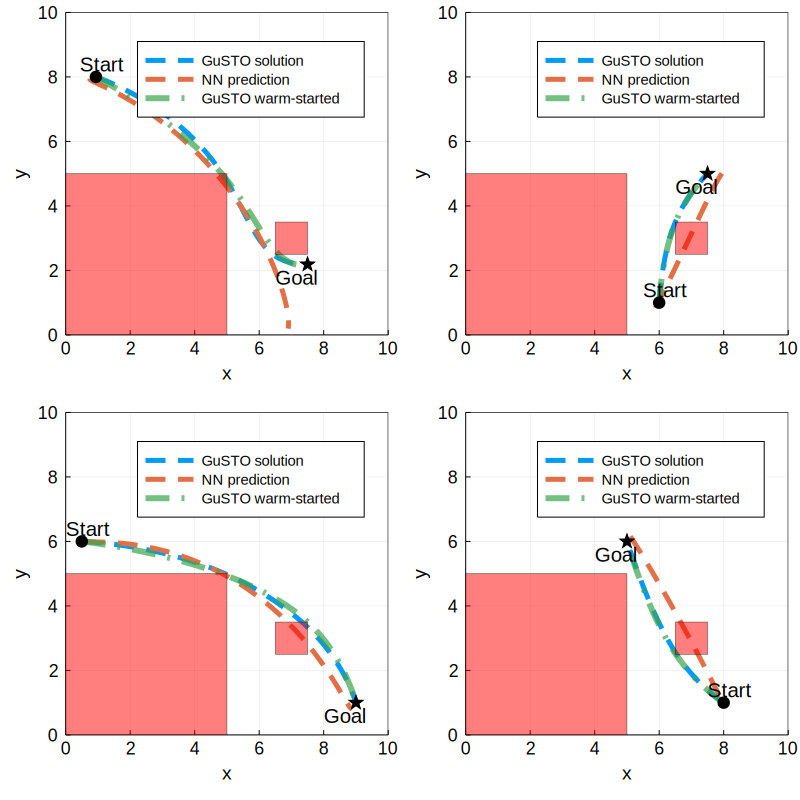

In [104]:
plot(p1,p2,p3,p4,layout=(2,2), size=(800,800))

In [ ]:
png("AllFour")

# Rejected for now

In [ ]:
x_start= [2.0, 6.0, 0.5]
x_goal = [9.0, 2., 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



In [ ]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :top)
plot!(legend = :best, legendfontsize=10)
plot!(size=(550,550))
xlabel!("x", guidefontsize = 13)
ylabel!("y", guidefontsize = 13)
plot!(tickfontsize = 12)

In [ ]:
x_start= [2.222, 10.0, 0.5]
x_goal = [6.6667, 0.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
x_start= [2.25, 5.8125, 0.5]
x_goal = [9.5, 2.1875, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("NN helped you avoid both obstacles 2")

In [ ]:
x_start= [3.125, 7.6875, 0.5]
x_goal = [9.5, 3.875, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :bottomright)

In [ ]:
png("Simple case not bad")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

GuSTO solve time = 40.897764688 (8 iterations)
NN_solve_time = 4.082913327
GuSTO warm started solve time = 7.942292923 (12 iterations)


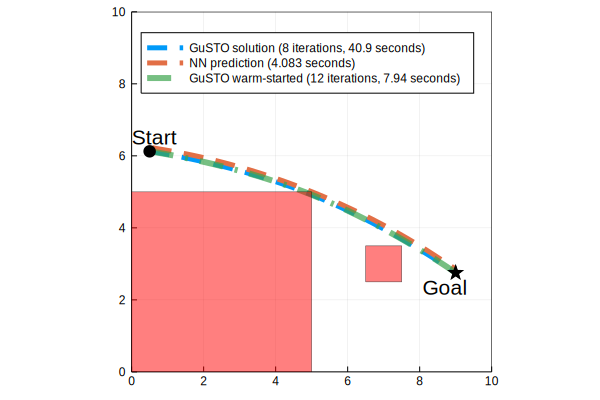

In [25]:
x_start= [0.5, 6.125, 0.5]
x_goal = [9., 2.75, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [87]:
function plot_three_comp_pyplot(model, X_all, labls = :None, time1="", iter1="", time2 ="", time3="", iter3="")
    N = length(X_all)
    labls = ["GuSTO solution", "NN prediction", "GuSTO warm-started"]
    idx = [1,2]
#     local fig
#     fig = plot(framestyle = :box)
    
    
    
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1
            plot!(X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 1)
        elseif iter == 2
            r = plot!(X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 2)
#             @show r.color
        else
            plot!(X[idx[1],:], X[idx[2],:];line=(6, :dashdot), linealpha = 0.7, lab = labls[iter], color = 3)
        end        
    end
    
    st_pt = X_all[1][idx[1]:idx[2],1]
    scatter!([st_pt[1]], [st_pt[2]], shape = :circle, markersize = 6, color = :black, lab = "")
    end_pt = X_all[1][idx[1]:idx[2],end]
    scatter!([end_pt[1]], [end_pt[2]], shape = :star, markersize = 8, color = :black, lab = "")
    annotate!([(st_pt[1]-0.4, st_pt[2]+0.4, text("\$x_{init}\$", 22, :black, :left)), 
            (end_pt[1]+0.4, end_pt[2]-0.4, text("\$x_{final}\$", 22, :black, :right))])


    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        buf = 0.2
        r1 = r1-buf
        r2 = r2-buf
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black, linealpha = 0.7,
                fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(legend = :best, legendfontsize=10)
    plot!(size=(550,550))
    xlabel!("x", guidefontsize = 16)
#     ylabel!("y", guidefontsize = 13)
    annotate!([(-1,5,Plots.text("y",16))])
    plot!(tickfontsize = 12)
#     return fig
end

plot_three_comp_pyplot (generic function with 7 methods)

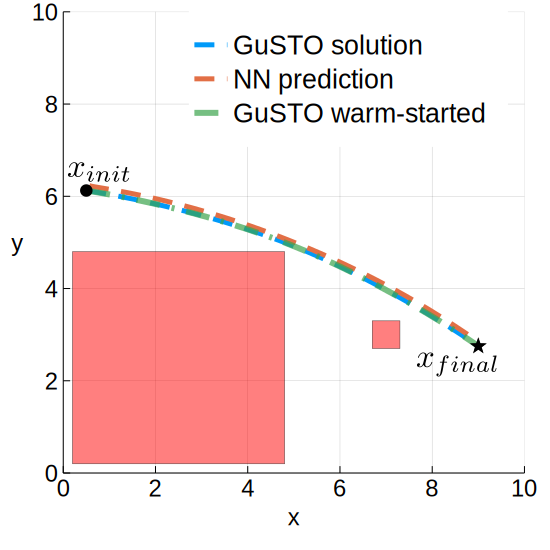

In [88]:
using PyPlot
plot()
plot_three_comp_pyplot(model, [X_all_true[end], X_soln_NN, X_all_warm[end]])
plot!(legendfontsize = 18, fg_legend=:transparent, tickfontsize = 16, guidefontsize = 16, legend=:best,yrotation = 0)
plot!(gridalpha = 0.2)

In [53]:
png("almostperfect-new")

In [262]:
png("Almost perfect 1.5x")

In [104]:
function plot_three_comp_3D_pyplot(model, X_all, labls = :None, time1="", iter1="", time2 ="", time3="", iter3="")
    N = length(X_all)
    labls = ["GuSTO solution", "NN prediction", "GuSTO warm-started"]
    idx = [1,2]
#     local fig
#     fig = plot()
#     fig = plot(framestyle = :box)
    


    for obs_i = 1
        (c1,c2,c3)  =  model.poly_obstacles[obs_i].c
        dx = model.poly_obstacles[obs_i].dx
        dy = model.poly_obstacles[obs_i].dy
        dz = model.poly_obstacles[obs_i].dz
        
        xmin = c1 - dx
        xmax = c1 + dx
        ymin = c2 - dy
        ymax = c2 + dy
        zmin = c3 - dz
        zmax = c3 + dz
        zmin = 0.2
        zmax = 0.8

        a = (zmax-zmin)/0.002
        b = zmax-0.003*a

        # top and bottom surfaces
        x = range(xmin, stop = xmax, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        f(x,y) = zmax
        g(x,y) = zmin
        plot!(x,y,f, seriestype = :surface, fillalpha = 1.0)
        plot!(x,y,g, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        

        dx = range(xmin + 0.001, stop = xmin + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        h(x,y) = a*(x-xmin) +b
        plot!(dx,y,h, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymax + 0.001, stop = ymax + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        m(x,y) = a*(y-ymax)+b
        plot!(x,dy,m, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        
        dx = range(xmax + 0.001, stop = xmax + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        k(x,y) = a*(x-xmax) +b
        plot!(dx,y,k, seriestype = :surface, fillalpha = 1.0)

        
    end
    
    for obs_i = 2
        (c1,c2,c3)  =  model.poly_obstacles[obs_i].c
        dx = model.poly_obstacles[obs_i].dx
        dy = model.poly_obstacles[obs_i].dy
        dz = model.poly_obstacles[obs_i].dz
        
        xmin = c1 - dx
        xmax = c1 + dx
        ymin = c2 - dy
        ymax = c2 + dy
        zmin = c3 - dz
        zmax = c3 + dz
        zmin = 0.2
        zmax = 0.8

        a = (zmax-zmin)/0.002
        b = zmax-0.003*a

        # top and bottom surfaces
        x = range(xmin, stop = xmax, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        f(x,y) = zmax
        g(x,y) = zmin
        plot!(x,y,f, seriestype = :surface, fillalpha = 1.0)
        plot!(x,y,g, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        

        dx = range(xmin + 0.001, stop = xmin + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        h(x,y) = a*(x-xmin) +b
        plot!(dx,y,h, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymax + 0.001, stop = ymax + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        m(x,y) = a*(y-ymax)+b
        plot!(x,dy,m, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        
        dx = range(xmax + 0.001, stop = xmax + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        k(x,y) = a*(x-xmax) +b
        plot!(dx,y,k, seriestype = :surface, fillalpha = 1.0)

        
    end
    
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 6, markershape = :octagon,  markerstrokealpha = 0.5, lab = labls[iter], color = iter )
        elseif iter ==2 
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 4, lab = labls[iter], color = iter )
        else
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 4, markeralpha=0.5,  markerstrokealpha = 0.5, lab = labls[iter], color = iter )
        end       
    end
    
    st_pt = X_all[1][:,1]
    scatter!([st_pt[1]], [st_pt[2]],[st_pt[3]], shape = :circle, markersize = 6, color = :white, lab = "")
    end_pt = X_all[1][:,end]
    scatter!([end_pt[1]], [end_pt[2]],[end_pt[3]], shape = :star, markersize = 8, color = :white, lab = "")

    xlims!((model.x_min[1],model.x_max[1]))
    ylims!((model.x_min[2],model.x_max[2]))
    plot!(zlim = (model.x_min[3]+0.3,model.x_max[3]-0.2), zaxis = "Z")
    plot!(leg =  :best, legfontsize = 10)
    xlabel!("X")
    ylabel!("Y")
    plot!(camera=(120,30), colorbar = :false)
    plot!(size=(700,700,700))
#     annotate!([(st_pt[1]-0.4, st_pt[2]+0.4, text("\$x_{init}\$", 22, :black, :left)), 
#             (end_pt[1]+0.4, end_pt[2]-0.4, text("\$x_{final}\$", 22, :black, :right))])
#     return fig
end

plot_three_comp_3D_pyplot (generic function with 7 methods)

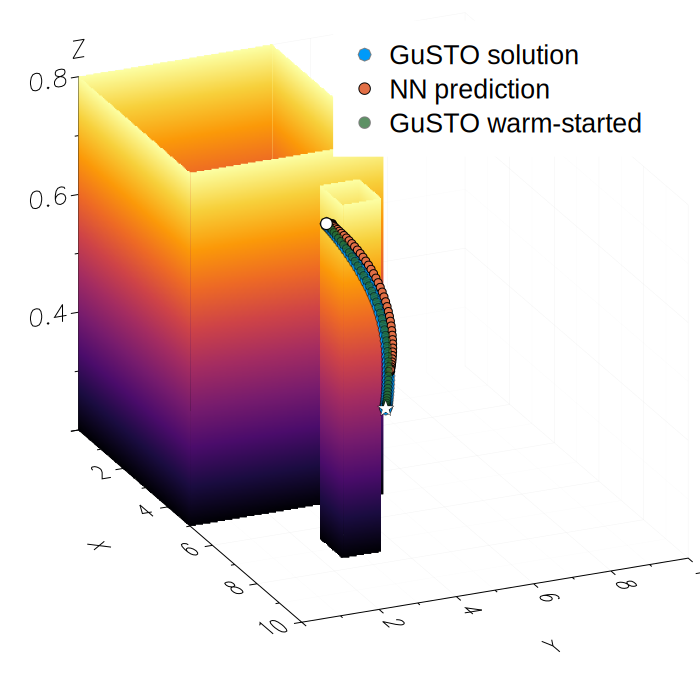

In [108]:
using PyPlot
plot()
# annotate!([(0,0,"hi")])
plot_three_comp_3D_pyplot(model, [X_all_true[end], X_soln_NN, X_all_warm[end]])

plot!(camera=(60,50))
# plot!(legendfontsize = 12, fg_legend = :transparent)
plot!(legendfontsize = 18, fg_legend=:transparent, tickfontsize = 16, guidefontsize = 16, legend=:best,xrotation = 0, yrotation = 0, zrotation=0, rotation=0)
plot!(gridalpha = 0.2)
# plot!(ytickrotation = 90)
yaxis!(rotation = 90)
# annotate!([(0,0,0, text("\$x_{init}\$", 22, :black, :left))])

In [95]:
png("3Dalmostperfect")

In [264]:
png("3DForAlmostPerfectCase")

# Try to add an obstacle to GuSTO now

In [105]:
# Solve with one extra obstacle

x_start= [0.5, 6.125, 0.5]
x_goal = [9., 2.75, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO original solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_init, U_all_init = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN original prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time


# Add an extra obstacle
poly_obstacles = []
obs = PolygonalObstacle([6.0,4.0,0.5], [0.5, 1.0, 2.0])
push!(model.poly_obstacles, obs)


# GuSTO solution time and trajectory- COLD START
time_start = time_ns()
model, isConverged, numIter, X_all_new_cold, U_all_new_cold = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# GuSTO start solution time and trajectory- WARM START
time_start = time_ns()
model, isConverged, numIter_warm, X_all_new_warm, U_all_new_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

GuSTO solve time = 4.541965574 (8 iterations)
NN_solve_time = 0.003088306
GuSTO solve time = 38.964229393 (53 iterations)
GuSTO warm started solve time = 4.793618689 (7 iterations)


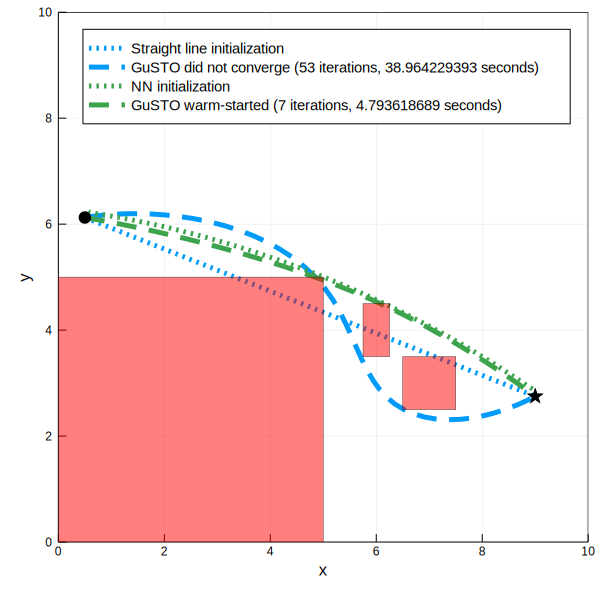

In [109]:
labls = ["Straight line initialization", "GuSTO did not converge ($numIter iterations, $gusto_solve_time seconds)", "NN initialization", "GuSTO warm-started ($numIter_warm iterations, $gusto_warm_solve_time seconds)"]
X_straight = hcat(range(x_init, stop=x_final, length=50)...)
plot_custom(model, [X_straight, X_all_new_cold[end], X_soln_NN,   X_all_new_warm[end]], labls)
plot!(size=(600,600),legend=:best,legendfontsize = 10)
xlabel!("x")
ylabel!("y")

In [ ]:
png("gustoadaptswithwarm")

In [108]:
function plot_custom(model, X_all, labls = :None, time1="", iter1="", time2 ="", time3="", iter3="")
    N = length(X_all)
        idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    
    
    
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1                 
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dot), lab = labls[iter], color = 1)
        elseif iter == 2
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 1)
        elseif iter ==3
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dot), lab = labls[iter], color = 3)
        elseif iter ==4
            r = plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 3)
#             @show r.color
#         else
#             plot!(fig, X[idx[1],:], X[idx[2],:];line=(6, :dashdot), linealpha = 0.7, lab = labls[iter], color = 3)
        end        
    end
    
    st_pt = X_all[1][idx[1]:idx[2],1]
    scatter!([st_pt[1]], [st_pt[2]], shape = :circle, markersize = 6, color = :black, lab = "")
    end_pt = X_all[1][idx[1]:idx[2],end]
    scatter!([end_pt[1]], [end_pt[2]], shape = :star, markersize = 8, color = :black, lab = "")
#     annotate!([(st_pt[1]-0.2, st_pt[2]+0.4, text("Start", 12, :black, :left)), 
#             (end_pt[1]+0.3, end_pt[2]-0.4, text("Goal", 12, :black, :right))])


    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black, linealpha = 0.7,
                fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(leg =  :bottomright)
    return fig
end

plot_custom (generic function with 7 methods)

In [ ]:
x_start= [1.375, 8., 0.5]
x_goal = [5.5, 4.4375, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
x_start= [0.9375, 8., 0.5]
x_goal = [7.5, 2.1875, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
x_start= [2.0, 6., 0.5]
x_goal = [9.0, 2.1875, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("NN helped you avoid both obstacles")

In [ ]:
plot_three_comp_3D(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legendfontsize = 12, fg_legend = :transparent)

In [ ]:
x_start= [2.0, 6., 0.5]
x_goal = [8.0, 1.75, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("NN speedup and switches homotopy class")

In [ ]:
x_start= [5.55555556, 1.11111111, 0.5]
x_goal = [7.77777778, 6.66666667, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
plot_three_comp_3D(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legendfontsize = 12, fg_legend = :transparent)

In [ ]:
x_start= [0.0, 7.0, 0.5]
x_goal = [8.0, 7.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [0.0, 7.0, 0.5]
x_goal = [6.0, 2.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
function plot_three_comp_3D_custom(model, X_all, labls = :None, time1="", iter1="", time2 ="", time3="", iter3="")
    N = length(X_all)
    labls = ["", "", ""]
    idx = [1,2]
    local fig
#     fig = plot()
    fig = plot(framestyle = :box)
    


    for obs_i = 1
        (c1,c2,c3)  =  model.poly_obstacles[obs_i].c
        dx = model.poly_obstacles[obs_i].dx
        dy = model.poly_obstacles[obs_i].dy
        dz = model.poly_obstacles[obs_i].dz
        
        xmin = c1 - dx
        xmax = c1 + dx
        ymin = c2 - dy
        ymax = c2 + dy
        zmin = c3 - dz
        zmax = c3 + dz
        zmin = 0.2
        zmax = 0.8

        a = (zmax-zmin)/0.002
        b = zmax-0.003*a

        # top and bottom surfaces
        x = range(xmin, stop = xmax, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        f(x,y) = zmax
        g(x,y) = zmin
        plot!(x,y,f, seriestype = :surface, fillalpha = 1.0)
        plot!(x,y,g, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        

        dx = range(xmin + 0.001, stop = xmin + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        h(x,y) = a*(x-xmin) +b
        plot!(dx,y,h, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymax + 0.001, stop = ymax + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        m(x,y) = a*(y-ymax)+b
        plot!(x,dy,m, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        
        dx = range(xmax + 0.001, stop = xmax + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        k(x,y) = a*(x-xmax) +b
        plot!(dx,y,k, seriestype = :surface, fillalpha = 1.0)

        
    end
    
    for obs_i = 2
        (c1,c2,c3)  =  model.poly_obstacles[obs_i].c
        dx = model.poly_obstacles[obs_i].dx
        dy = model.poly_obstacles[obs_i].dy
        dz = model.poly_obstacles[obs_i].dz
        
        xmin = c1 - dx
        xmax = c1 + dx
        ymin = c2 - dy
        ymax = c2 + dy
        zmin = c3 - dz
        zmax = c3 + dz
        zmin = 0.2
        zmax = 0.8

        a = (zmax-zmin)/0.002
        b = zmax-0.003*a

        # top and bottom surfaces
        x = range(xmin, stop = xmax, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        f(x,y) = zmax
        g(x,y) = zmin
        plot!(x,y,f, seriestype = :surface, fillalpha = 1.0)
        plot!(x,y,g, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        

        dx = range(xmin + 0.001, stop = xmin + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        h(x,y) = a*(x-xmin) +b
        plot!(dx,y,h, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymax + 0.001, stop = ymax + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        m(x,y) = a*(y-ymax)+b
        plot!(x,dy,m, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        
        dx = range(xmax + 0.001, stop = xmax + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        k(x,y) = a*(x-xmax) +b
        plot!(dx,y,k, seriestype = :surface, fillalpha = 1.0)

        
    end
    
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 6, markershape = :octagon,  markerstrokealpha = 0.5, lab = labls[iter], color = iter )
        elseif iter ==2 
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 4, lab = labls[iter], color = iter )
        else
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 4, markeralpha=0.5,  markerstrokealpha = 0.5, lab = labls[iter], color = iter )
        end       
    end
    
    st_pt = X_all[1][:,1]
    scatter!([st_pt[1]], [st_pt[2]],[st_pt[3]], shape = :circle, markersize = 6, color = :white, lab = "Start point")
    end_pt = X_all[1][:,end]
    scatter!([end_pt[1]], [end_pt[2]],[end_pt[3]], shape = :star, markersize = 8, color = :white, lab = "Goal point")

    xlims!((model.x_min[1],model.x_max[1]))
    ylims!((model.x_min[2],model.x_max[2]))
    plot!(zlim = (model.x_min[3]+0.3,model.x_max[3]-0.2), zaxis = "Z")
    plot!(leg =  :best, legfontsize = 10)
    xlabel!("X")
    ylabel!("Y")
    plot!(camera=(120,30), colorbar = :false)
    plot!(size=(700,700,700))
    return fig
end

In [ ]:
plot_three_comp_3D_custom(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legendfontsize = 12, legend = :top)

In [ ]:
png("3DVizTraj")

In [ ]:
x_start= [0.0, 7.0, 0.5]
x_goal = [2.0, 8.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:bottomright)

In [ ]:
x_start= [4.0, 8.0, 0.5]
x_goal = [8.0, 8.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [4.0, 8.0, 0.5]
x_goal = [9.0, 3.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [4.0, 8.0, 0.5]
x_goal = [8.0, 1.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [5.0, 7.0, 0.5]
x_goal = [8.0, 1.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [3.0, 6.0, 0.5]
x_goal = [6.0, 1.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [3.0, 6.0, 0.5]
x_goal = [7.0, 1.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [3.0, 6.0, 0.5]
x_goal = [7.0, 0.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [3.0, 6.0, 0.5]
x_goal = [7.0, 0.3, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
# Warm starting ONLY the X trajectory
x_start= [3.0, 6.0, 0.5]
x_goal = [7.0, 0.3, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, [])
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [3.0, 6.0, 0.5]
x_goal = [9.0, 2.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
# Warm starting ONLY the x trajectory
x_start= [3.0, 6.0, 0.5]
x_goal = [9.0, 2.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, [])
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [3.0, 8.0, 0.0]
x_goal = [8.0, 3.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeLargeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "SimpleAstrobeeLargeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


In [ ]:
x_start= [0.0, 9.0, 0.0]
x_goal = [8.0, 3.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeLargeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "SimpleAstrobeeLargeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


In [ ]:
x_start= [0.0, 7.0, 0.0]
x_goal = [8.0, 10.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeLargeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "SimpleAstrobeeLargeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


# Not implemented yet

In [ ]:
function carryOutSequence(runs, NNDualParams = nothing, NNDualJSON = nothing, NNDualWeights = nothing)
    println("----------")
    model = getModelWithCornerSpheres()
    

    
#     gusto_setup_time = (time_ns() - time_start)/10^9

#     times = []
    
#     time_start = time_ns()
    # Set up NN if required
    if !(NNDualParams == nothing || NNDualJSON == nothing || NNDualWeights == nothing)
        xMin, yMin, xRange, yRange = getDataParamsFromHDF5(NNDualParams)
        NN = Keras.load(NNDualJSON, NNDualWeights)
    end
    NN_setup_time = (time_ns() - time_start)/10^9
    
    
    # Set up shooting problem
    N = 20
    SP = ShootingProblem(TOP, TOSgusto.SCPS)
    TOSgusto.SS = ShootingSolution(SP, deepcopy(traj_init))
    SS = TOSgusto.SS
    
    println("GuSTO setup time is $gusto_setup_time")
    println("NN setup time is $NN_setup_time")
    
    while length(runs)>0
        run = popfirst!(runs)
        if startswith(run,"GuSTO-")
            num_iter = parse(Int64, run[7:end])
            println("Doing $num_iter iteration(s) of GuSTO")
            traj = Trajectory(traj_X_vec[end], traj_U_vec[end], tf)
            # Set dual to the end of dual_vec
            if !isdefined(TOSgusto, :SCPS)
                println("defining SCPS")
                SCPP = SCPProblem(TOP)
                SCPS = SCPSolution(SCPP, traj)
                TOSgusto.traj, TOSgusto.SCPS = SCPS.traj, SCPS
            end
            TOSgusto.traj = traj
            TOSgusto.SCPS.dual = dual_vec[end]
            solve_gusto_jump!(TOSgusto.SCPS, TOSgusto.SCPS.SCPP, "Ipopt", max_iter=num_iter, print_level=1)

#             solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj, "Ipopt", max_iter=num_iter, print_level=1);
            iter_times = TOSgusto.SCPS.iter_elapsed_times
            @show iter_times
            @show TOSgusto.SCPS.J_true
            num_actual_iter = (length(iter_times)>num_iter+1) ? num_iter : length(iter_times)-1
            append!(times, iter_times[end-(num_actual_iter-1):end])
            push!(dual_vec, TOSgusto.SCPS.dual)
            push!(traj_X_vec, TOSgusto.SCPS.traj.X)
            push!(traj_U_vec, TOSgusto.SCPS.traj.U)
            if (TOSgusto.SCPS.converged)
                println("GuSTO converged!")
                println("Cost reported: $(TOSgusto.SCPS.J_true)")
            end
        elseif startswith(run,"NNDual-")
            num_iter = parse(Int64, run[8:end])
            if (NNDualParams == nothing || NNDualJSON == nothing || NNDualWeights == nothing)
                println("Error: one or more of the NN duals filenames is missing")
            else
                println("Doing $num_iter iteration(s) of NN- dual")
                if isdefined(TOSgusto, :SCPS) && isdefined(TOSgusto.SCPS, :param) && isdefined(TOSgusto.SCPS.param, :alg)
                    ω = TOSgusto.SCPS.param.alg.ω_vec[end]
                    Δ = TOSgusto.SCPS.param.alg.Δ_vec[end]
                else 
                    ω = ω0
                    Δ = Δ0
                end
                NN_input = createNNInput(traj_X_vec[end], traj_U_vec[end], ω, Δ, xMin, xRange, dual_vec[end])
                NN_inter = NN_input
                for i=1:num_iter
                    time_start = time_ns()
                    
                    NN_output = NN(NN_inter)
                    output_dual = recoverDualfromNNOutput(NN_output, yMin, yRange)
                    
                    iter_elapsed_time = (time_ns() - time_start)/10^9
                    push!(times, iter_elapsed_time)
                    
                    push!(dual_vec, output_dual)
                    
                    # Just repeating the same trajectories
                    push!(traj_X_vec, traj_X_vec[end])
                    push!(traj_U_vec, traj_U_vec[end])
                    
                    # output dual is input for next iteration of NN
                    NN_inter = vcat(NN_input[1:182], output_dual)
                end
            end
        elseif startswith(run, "Shooting")
            TOSgusto.SS.SP.p0 = dual_vec[end]
            solve!(TOSgusto.SS, TOSgusto.SS.SP)
            push!(times, TOSgusto.SS.iter_elapsed_times[end])
            if TOSgusto.SS.prob_status[end]== Symbol(:Optimal)
                println("Shooting method converged!")
                println("Costs reported: $(TOSgusto.SS.J_true)")
            else
                println("Shooting method did not converge.")
            end
        else
            println("Error: $run is not a supported command. Make sure to append the number of iterations at the end of a command.")
        end
    end
    @show times
    # @show dual_vec
    println("----------")
    return (dual_vec, traj_X_vec, traj_U_vec, times)
end